In [1]:
import torch
import torch.nn as nn
import torch.utils.data.dataloader as dataloader
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import umap
import umap.plot
import itertools

from sklearn.model_selection import KFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

from torch.utils.tensorboard import SummaryWriter

In [2]:
file_name = 'D://Xin Zhang/Sensor/conbination/processed_data/All_data_twoinputs.npy'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

debug = True
train_proportion = 0.8
val_prop = 0.3 # Proportion from the train 

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)

num_class_level = 1
num_sub_class_level = 0
length_signal = 3000

start_from_checkpoint = False

save_dir = 'Models/Model_v1'

writer1 = SummaryWriter('combination_log')
#writer2 = SummaryWriter('combination_log')

In [3]:
class Classifier(Dataset):
    def __init__(self, file_name):
        
        self.temp_data = np.load( file_name, allow_pickle = True)
                
        self.data_raw = self.temp_data[:,:length_signal]
        self.data_fft = self.temp_data[:,length_signal:-(num_class_level+num_sub_class_level)]
        self.label = self.temp_data[:,-(num_class_level+num_sub_class_level):]

                
    
    def __len__(self):
        
        return len(self.data_raw) 
    
    def __getitem__(self,idx):
        
        
        return self.data_raw[idx,:], self.data_fft[idx,:], self.label[idx]

In [4]:
all_data = Classifier(file_name)

num_samples = len(all_data.data_raw)
print(num_samples)
print(all_data.data_raw.shape)
print(all_data.data_fft.shape)
print(all_data.label.shape)

1263
(1263, 3000)
(1263, 3000)
(1263, 1)


In [5]:
all_data.data_raw = all_data.data_raw.reshape(all_data.data_raw.shape[0], 1, all_data.data_raw.shape[1])
all_data.data_fft = all_data.data_fft.reshape(all_data.data_fft.shape[0], 1, all_data.data_fft.shape[1]) 

# all_data.label = all_data.label.reshape(all_data.label.shape[0], 1, all_data.label.shape[1])
print(all_data.data_raw.shape)
print(all_data.data_fft.shape)
print(all_data.label.shape)

(1263, 1, 3000)
(1263, 1, 3000)
(1263, 1)


In [6]:
batch_size = 10

In [7]:
n_train = round(num_samples * train_proportion)


train_data, test_data = torch.utils.data.random_split(all_data, [n_train, num_samples - n_train])
#train_data, val_data = torch.utils.data.random_split(train_data, [round(n_train * (1-val_prop)), n_train - round(n_train * (1-val_prop))])

#train_loader = dataloader.DataLoader(train_data, shuffle = True, batch_size = batch_size)
#val_loader = dataloader.DataLoader(val_data, shuffle = False, batch_size = batch_size)
test_loader = dataloader.DataLoader(test_data, shuffle = False, batch_size = batch_size)
all_loader = dataloader.DataLoader(all_data, shuffle = False, batch_size = num_samples)

In [8]:
if(debug):
    print('Num samples', num_samples)
    print('Train samples', n_train)
    #print('Valid samples', n_train - round(n_train * (1-val_prop)))
    print('Test samples', num_samples - n_train)
#     print("Num samples", num_samples)
#     print("Train + valid samples", n_train )
#     print("Train samples", round(n_train * (1-val_prop)))
#     print("Test samples", num_samples - n_train )

Num samples 1263
Train samples 1010
Test samples 253


### Linear

In [9]:
class LinearModel_fft(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fft = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(), 
            nn.Dropout(0.3),
            
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256,num_classes))    
        
    def forward(self, t_fft):
        fft_out = self.fft(t_fft)
        return fft_out
    
    
class LinearModel_raw(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.raw = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(), 
            
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256,num_classes)) 
        
    def forward(self, t_raw):
        raw_out = self.raw(t_raw)
        return raw_out 

In [10]:
class LinearModel_1(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.raw = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(), 
            
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU()) 
        
        
        self.fft = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(), 
            nn.Dropout(0.3),
            
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3))
        
        
        self.visu = nn.Sequential(
            nn.Linear(2*256, 128),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 32))
        
        self.out = nn.Sequential(
            nn.Linear(32, num_classes)) 

    def get_weights(self):
        return self.weight
    
    def forward(self, t_raw, t_fft):
        raw_out = self.raw(t_raw)
        fft_out = self.fft(t_fft)
        t_in = torch.cat([raw_out, fft_out], dim=1)
        t_visu = self.visu(t_in)
        out = self.out(t_visu)
        return out

In [11]:
def train(model, device, train_loader, optimizer):
    model.train()
    y_true = []
    y_pred = []
    running_loss = 0
    
    for i in train_loader:
        data_raw, data_fft, target = i
        data_raw, data_fft, target = data_raw.to(device), data_fft.to(device), target.to(device)
        data_raw = torch.squeeze(data_raw)
        data_fft = torch.squeeze(data_fft)
        
        # Forward
        output = model(data_fft.float())
        #output = model(data_raw.float())
        #output = model(data_raw.float(),data_fft.float())
        loss = criterion(output, target.long().squeeze()) 
        running_loss += loss.item()
        
        # Backword
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Predictions
        pred = np.round(output.cpu().detach())
        target = np.round(target.cpu().detach())             
        y_pred.extend(pred.tolist())
        y_true.extend(target.tolist())
    
    y_pred = np.argmax(y_pred, axis=1)
    
    train_loss = running_loss/len(train_loader)
    writer1.add_scalar('train_val_test_loss', train_loss, global_step=epoch)
    train_losses.append(train_loss)
    
    # performance
    train_accuracy = accuracy_score(y_true,y_pred)
    train_acc.append(train_accuracy)
    train_recall = recall_score(y_true,y_pred,average='macro')
    train_precision = precision_score(y_true,y_pred,average='macro')
    train_f1 = f1_score(y_true,y_pred, average='macro')
    
    print("[train metrics] loss:{:.4f} accuracy:{:.4f} recall:{:.4f} precision:{:.4f} f1:{:.4f}".format(train_loss,train_accuracy,train_recall,train_precision,train_f1))

# ==========================================================================================================================================================================
def validation(model, device, validation_loader):
    model.eval()
    y_true = []
    y_pred = []
    running_loss = 0
    
    with torch.no_grad():
        for i in validation_loader:
            data_raw, data_fft, target = i
            data_raw, data_fft, target = data_raw.to(device), data_fft.to(device), target.to(device)
            data_raw = torch.squeeze(data_raw)
            data_fft = torch.squeeze(data_fft)
            
            output = model(data_fft.float())
            #output = model(data_raw.float())
            #output = model(data_raw.float(),data_fft.float())
            loss = criterion(torch.squeeze(output), torch.squeeze(target.long()))
            running_loss += loss.item()
            
            pred = np.round(output.cpu())
            target = target.float()
            y_true.extend(target.cpu().tolist()) 
            y_pred.extend(pred.tolist())
        
    y_pred = np.argmax(y_pred, axis=1)
    val_loss = running_loss/len(validation_loader)
    writer1.add_scalar('train_val_test_loss', val_loss, global_step=epoch)
    eval_losses.append(val_loss)
    
    # performance
    val_accuracy = accuracy_score(y_true,y_pred)
    eval_acc.append(val_accuracy)
    val_recall = recall_score(y_true,y_pred,average='macro')
    val_precision = precision_score(y_true,y_pred,average='macro')
    val_f1 = f1_score(y_true,y_pred, average='macro')
    
    print("[valid  metrics] loss:{:.4f} accuracy:{:.4f} recall:{:.4f} precision:{:.4f} f1:{:.4f}".format(val_loss,val_accuracy,val_recall,val_precision,val_f1))
    
    return val_loss
    
# ==========================================================================================================================================================================
def test(model, device, test_loader):
    #model in eval mode skips Dropout etc
    model.eval()
    y_true = []
    y_pred = []
    running_loss = 0
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in test_loader:
            data_raw, data_fft, target = i
            data_raw, data_fft, target = data_raw.to(device), data_fft.to(device), target.to(device)
            data_raw = torch.squeeze(data_raw)
            data_fft = torch.squeeze(data_fft)

            # the model on the data
            #output = model(data_fft.float())
            #output = model(data_raw.float())
            output = model(data_raw.float(),data_fft.float())
            loss = criterion(torch.squeeze(output), torch.squeeze(target.long()))
            running_loss += loss.item()
            
            # Predictions
            pred = np.round(output.cpu())
            target = target.float()
            y_true.extend(target.cpu().tolist()) 
            y_pred.extend(pred.tolist())
            
    y_pred = np.argmax(y_pred, axis=1)
    
    test_loss = running_loss/len(test_loader)
    writer1.add_scalar('train_val_test_loss', test_loss, global_step=epoch)
    test_losses.append(test_loss)
    
    # performance
    test_accuracy = accuracy_score(y_true,y_pred)
    test_acc.append(test_accuracy)
    test_recall = recall_score(y_true,y_pred,average='macro')
    test_precision = precision_score(y_true,y_pred,average='macro')
    test_f1 = f1_score(y_true,y_pred, average='macro')

    print("[test  metrics] loss:{:.4f} accuracy:{:.4f} recall:{:.4f} precision:{:.4f} f1:{:.4f}".format(test_loss,test_accuracy,test_recall,test_precision,test_f1))
    print("*****************************************************************************************")
    
# ==========================================================================================================================================================================    
def test_metrics(model, device, test_loader):
    #model in eval mode skips Dropout etc
    model.eval()
    y_true = []
    y_pred = []
    y_pred_prob = []
    running_loss = 0
    
    softmax = nn.Softmax()
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in test_loader:
            data_raw, data_fft, target = i
            data_raw, data_fft, target = data_raw.to(device), data_fft.to(device), target.to(device)
            data_raw = torch.squeeze(data_raw)
            data_fft = torch.squeeze(data_fft)
            
            # the model on the data
            #output = model(data_fft.float())
            #output = model(data_raw.float())
            output = model(data_raw.float(),data_fft.float())
            loss = criterion(torch.squeeze(output), torch.squeeze(target.long()))
            running_loss += loss.item()
            
            output = softmax(output)
            
            # Predictions
            pred = np.round(output.cpu())
            target = target.float()
            y_true.extend(target.cpu().tolist())
            y_pred_prob.extend(output.tolist())
            y_pred.extend(pred.tolist())
     

    y_pred = np.argmax(y_pred, axis=1)

    # confusion matrix
    print(classification_report(y_true, y_pred))
    conf_matrix = get_confusion_matrix(y_true, y_pred)
    attack_types = ['Yes','No','One','Two','Shake','Nod','Stretch','Nod+No','Nod+Yes','Shake+No','Shake+Yes']
    plot_confusion_matrix(conf_matrix, classes=attack_types, normalize=True,title='Normalized confusion matrix')
    
    # ROC curve
    y_true_binary = label_binarize(y_true, classes=[i for i in range(11)])
    y_pred_prob = np.array(y_pred_prob)
    get_roc_auc(y_true_binary, y_pred_prob)

# ==========================================================================================================================================================================    
def reset_weights(m):
    for layer in m.children():
        for param in layer.parameters():
            if param.requires_grad==True :
                flag = True
            else:
                flag = False
        if hasattr(layer,'reset_parameters') & flag :
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

# ==========================================================================================================================================================================    
def visualization(model, device, all_loader):
    model.eval()
    with torch.no_grad():
        for i in all_loader:
            data_raw, data_fft, target = i
            data_raw, data_fft, target = data_raw.to(device), data_fft.to(device), target.to(device)
            data_raw = torch.squeeze(data_raw)
            data_fft = torch.squeeze(data_fft)
            
            # the model on the data
            output = model(data_raw.float(),data_fft.float())
    return activation['visu']

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# ==========================================================================================================================================================================    
def get_confusion_matrix(trues, preds):
    labels = [0,1,2,3,4,5,6,7,8,9,10]
    conf_matrix = confusion_matrix(trues, preds, labels)
    return conf_matrix

# def plot_confusion_matrix(conf_matrix):
#     sns.set()
#     f,ax = plt.subplots()
#     sns.heatmap(conf_matrix, annot=True, ax=ax, cmap='Blues')
#     ax.set_title('confusion matrix')
#     ax.set_xlabel('predict')
#     ax.set_ylabel('true')
    
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("显示百分比：")
        np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
        print(cm)
    else:
        print('显示具体数字：')
        print(cm)
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title)
    plt.colorbar(fraction=0.03, pad=0.06)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i,j]!= 0 :
            plt.text(j, i, format(cm[i, j], fmt),verticalalignment="center",horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    #plt.ylabel('Actual Throat Activities',fontsize=13)
    #plt.xlabel('Predicted Throat Activities',fontsize=13)
    plt.savefig('confusion_matrix.png')
    plt.show() 
    
# ==========================================================================================================================================================================        
font = {'size':13, 'weight':'normal', 'color':'black', 'style':'normal'}

def get_roc_auc(trues, preds):
    labels = [0,1,2,3,4,5,6,7,8,9,10]
    nb_classes = len(labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    #print(trues, preds)
    
    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(trues.ravel(), preds.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))
        
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(nb_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            
    # Finally average it and compute AUC
    mean_tpr /= nb_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    lw = 2
    plt.figure()
    plt.xlabel('1 - specificity',fontdict=font,fontweight='bold')
    plt.ylabel('Sensitivity',fontdict=font,fontweight='bold')
#     plt.title('ROC-AUC for all-class',fontdict=font)
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average',color='deeppink', linestyle=':')
    plt.plot(fpr["macro"], tpr["macro"],label='macro-average',color='navy', linestyle=':')
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'gold', 'black', 'pink', 'grey', 'orange'])
    
    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='{0}'.format(i+1))
#         plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='class {0} (AUC={1:0.2f})'.format(i, roc_auc[i]))
#     plt.plot([0, 1], [0, 1], 'k--', lw=lw)

    plt.legend(loc="lower right",fontsize=13,frameon=False,ncol=2)
    plt.savefig("ROC_All-class.png")
    plt.show()
    
# write roc data into csv file ===============================================================================================================
    all_df = pd.DataFrame()
    for i in range(nb_classes):
        fpr_temp_df = pd.DataFrame(fpr[i])
        all_df = pd.concat([all_df,fpr_temp_df],axis=1)
        tpr_temp_df = pd.DataFrame(tpr[i])
        all_df = pd.concat([all_df,tpr_temp_df],axis=1)
    macro_fpr_temp_df = pd.DataFrame(fpr['macro'])
    all_df = pd.concat([all_df,macro_fpr_temp_df],axis=1)
    macro_tpr_temp_df = pd.DataFrame(tpr['macro'])
    all_df = pd.concat([all_df,macro_tpr_temp_df],axis=1)
    micro_fpr_temp_df = pd.DataFrame(fpr['micro'])
    all_df = pd.concat([all_df,micro_fpr_temp_df],axis=1)
    micro_tpr_temp_df = pd.DataFrame(tpr['micro'])
    all_df = pd.concat([all_df,micro_tpr_temp_df],axis=1)
#         print(i,'===============================')
#         print('fpr',fpr[i])
#         print('tpr',tpr[i])
#     print('macro fpr',fpr["macro"])
#     print('macro tpr',tpr["macro"])
#     print('micro fpr',fpr["micro"])
#     print('micro tpr',tpr["micro"])
#     print(type(fpr[0]))
    p_col = ['0 fpr','0 tpr','1 fpr','1 tpr','2 fpr','2 tpr','3 fpr','3 tpr','4 fpr','4 tpr','5 fpr','5 tpr','6 fpr','6 tpr','7 fpr','7 tpr','8 fpr','8 tpr','9 fpr','9 tpr','10 fpr','10 tpr','macro fpr','macro tpr','micro fpr','micro tpr']
    all_df.columns = p_col
    all_df.to_csv('roc_data_all_class.csv')

In [12]:
input_size = 3000
num_classes = 11
num_epochs = 1300
learning_rate = 1e-6

# KFold validation
k = 5
splits = KFold(n_splits=k, shuffle=True, random_state=42)

# Creating model and setting loss and optimizer
model = LinearModel_fft(input_size,num_classes).to(device)
#model = LinearModel_raw(input_size,num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

test_losses = []
test_acc = []

for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(n_train))):
    print('Fold {}'.format(fold+1))
    train_losses = []
    eval_losses = []
    train_acc = []
    eval_acc = []
    
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = dataloader.DataLoader(train_data, batch_size = batch_size, sampler=train_sampler)
    val_loader = dataloader.DataLoader(train_data, batch_size = batch_size, sampler=val_sampler)
    
    # reset the model
    model.apply(reset_weights)
    min_loss= 100 # ramdom big number
    
    for epoch in range(num_epochs):
    
        print('In epoch {}/{}'.format(epoch+1,num_epochs))
        train(model,device,train_loader,optimizer)
        val_loss = validation(model,device,val_loader)
        # test(model,device,test_loader)
        
        if(val_loss<min_loss):
            min_loss = val_loss
            print(f'================================save model_{fold+1}================================')
            torch.save(model.state_dict(), f'Model1_fft_Fold_{fold+1}_allclass_twoinputs_net_parameter.pth')
    
    # plot training & testing loss ======================================================
    plt.plot(train_losses)
    plt.plot(eval_losses)
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid Losses')
    plt.show()

    # plot training & testing accuracy ======================================================
    plt.plot(train_acc)
    plt.plot(eval_acc)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid Accuracy')
    plt.savefig("Accuracy_All-class.png")
    plt.show()   

Fold 1
Reset trainable parameters of layer = Linear(in_features=3000, out_features=1024, bias=True)
Reset trainable parameters of layer = BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=1024, out_features=256, bias=True)
Reset trainable parameters of layer = BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=256, out_features=11, bias=True)
In epoch 1/1300
[train metrics] loss:2.4285 accuracy:0.1040 recall:0.1008 precision:0.1038 f1:0.0858
[valid  metrics] loss:2.3374 accuracy:0.0891 recall:0.1170 precision:0.1312 f1:0.0519
================================save model_1================================
In epoch 2/1300


D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[train metrics] loss:2.4119 accuracy:0.1188 recall:0.1245 precision:0.1135 f1:0.1018
[valid  metrics] loss:2.3091 accuracy:0.0842 recall:0.1094 precision:0.1015 f1:0.0399
================================save model_1================================
In epoch 3/1300
[train metrics] loss:2.3326 accuracy:0.1349 recall:0.1399 precision:0.1932 f1:0.1256
[valid  metrics] loss:2.2534 accuracy:0.1139 recall:0.1386 precision:0.1714 f1:0.0837
================================save model_1================================
In epoch 4/1300
[train metrics] loss:2.3110 accuracy:0.1200 recall:0.1185 precision:0.1510 f1:0.1079
[valid  metrics] loss:2.1910 accuracy:0.1535 recall:0.1874 precision:0.1558 f1:0.1213
================================save model_1================================
In epoch 5/1300
[train metrics] loss:2.2871 accuracy:0.1349 recall:0.1329 precision:0.1651 f1:0.1132
[valid  metrics] loss:2.1735 accuracy:0.2228 recall:0.2164 precision:0.2314 f1:0.1856
================================save 

KeyboardInterrupt: 

### pick the best separate model

[test  metrics] loss:0.4418 accuracy:0.8696 recall:0.8743 precision:0.8807 f1:0.8748
*****************************************************************************************
              precision    recall  f1-score   support

         0.0       0.37      0.95      0.54        20
         1.0       0.86      0.55      0.67        22
         2.0       0.71      0.48      0.57        25
         3.0       0.95      0.79      0.86        24
         4.0       1.00      1.00      1.00        11
         5.0       0.95      0.95      0.95        19
         6.0       0.96      1.00      0.98        26
         7.0       1.00      0.59      0.74        22
         8.0       0.91      0.91      0.91        32
         9.0       0.93      0.90      0.91        29
        10.0       1.00      0.91      0.95        23

    accuracy                           0.81       253
   macro avg       0.88      0.82      0.83       253
weighted avg       0.88      0.81      0.82       253

显示百分比：
[[ 0.

<ipython-input-17-ff5d24fd76cf>:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = softmax(output)
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


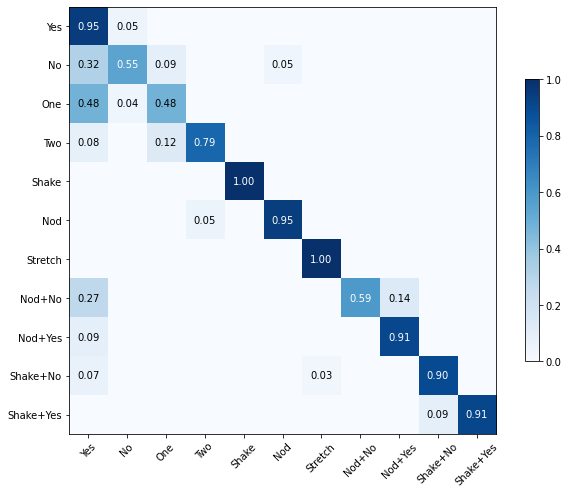

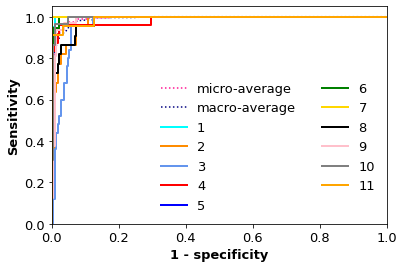

In [18]:
model_final = LinearModel_raw(input_size,num_classes).to(device)
state_dict = torch.load('Model1_raw_Fold_2_allclass_twoinputs_net_parameter.pth')
model_final.load_state_dict(state_dict)

test(model_final,device,test_loader)
test_metrics(model_final,device,test_loader)

### load the separate models & freeze & train last two layers

Fold 1
Reset trainable parameters of layer = Linear(in_features=512, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=11, bias=True)
In epoch 1/1300
[train metrics] loss:2.4590 accuracy:0.0693 recall:0.0704 precision:0.1283 f1:0.0785
[valid  metrics] loss:2.4193 accuracy:0.0297 recall:0.0244 precision:0.0602 f1:0.0273
================================save model_1================================
In epoch 2/1300


D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[train metrics] loss:2.4352 accuracy:0.0594 recall:0.0610 precision:0.1040 f1:0.0647
[valid  metrics] loss:2.3946 accuracy:0.0594 recall:0.0476 precision:0.1384 f1:0.0621
================================save model_1================================
In epoch 3/1300
[train metrics] loss:2.4130 accuracy:0.0668 recall:0.0691 precision:0.0988 f1:0.0652
[valid  metrics] loss:2.3839 accuracy:0.0396 recall:0.0269 precision:0.0697 f1:0.0388
================================save model_1================================
In epoch 4/1300
[train metrics] loss:2.3952 accuracy:0.0730 recall:0.0713 precision:0.1150 f1:0.0765
[valid  metrics] loss:2.3598 accuracy:0.0644 recall:0.0509 precision:0.1349 f1:0.0651
================================save model_1================================
In epoch 5/1300
[train metrics] loss:2.3919 accuracy:0.0953 recall:0.0972 precision:0.1411 f1:0.0976
[valid  metrics] loss:2.3506 accuracy:0.0644 recall:0.0552 precision:0.1256 f1:0.0612
================================save 

[train metrics] loss:2.0130 accuracy:0.3403 recall:0.3362 precision:0.4146 f1:0.3366
[valid  metrics] loss:1.9687 accuracy:0.3267 recall:0.3021 precision:0.3698 f1:0.3177
================================save model_1================================
In epoch 36/1300
[train metrics] loss:2.0136 accuracy:0.3144 recall:0.3173 precision:0.3694 f1:0.3101
[valid  metrics] loss:1.9682 accuracy:0.3564 recall:0.3349 precision:0.4023 f1:0.3450
================================save model_1================================
In epoch 37/1300
[train metrics] loss:2.0028 accuracy:0.3156 recall:0.3121 precision:0.3731 f1:0.3104
[valid  metrics] loss:1.9484 accuracy:0.4010 recall:0.3650 precision:0.4826 f1:0.3914
================================save model_1================================
In epoch 38/1300
[train metrics] loss:1.9974 accuracy:0.3181 recall:0.3101 precision:0.3682 f1:0.3055
[valid  metrics] loss:1.9542 accuracy:0.3713 recall:0.3712 precision:0.4377 f1:0.3834
In epoch 39/1300
[train metrics] l

[train metrics] loss:1.7183 accuracy:0.5087 recall:0.5095 precision:0.5386 f1:0.4927
[valid  metrics] loss:1.6334 accuracy:0.7178 recall:0.7282 precision:0.7457 f1:0.7071
In epoch 72/1300
[train metrics] loss:1.7076 accuracy:0.4790 recall:0.4743 precision:0.5148 f1:0.4618
[valid  metrics] loss:1.6110 accuracy:0.7129 recall:0.7244 precision:0.7416 f1:0.7069
================================save model_1================================
In epoch 73/1300
[train metrics] loss:1.6855 accuracy:0.5161 recall:0.5133 precision:0.5510 f1:0.5007
[valid  metrics] loss:1.5935 accuracy:0.7079 recall:0.7238 precision:0.7435 f1:0.7038
================================save model_1================================
In epoch 74/1300
[train metrics] loss:1.6946 accuracy:0.5074 recall:0.5029 precision:0.5431 f1:0.4973
[valid  metrics] loss:1.6079 accuracy:0.6881 recall:0.7219 precision:0.7426 f1:0.6970
In epoch 75/1300
[train metrics] loss:1.6927 accuracy:0.5272 recall:0.5186 precision:0.5461 f1:0.5056
[valid  m

[train metrics] loss:1.4869 accuracy:0.5804 recall:0.5823 precision:0.6265 f1:0.5715
[valid  metrics] loss:1.3401 accuracy:0.8119 recall:0.8197 precision:0.8276 f1:0.8117
================================save model_1================================
In epoch 108/1300
[train metrics] loss:1.4655 accuracy:0.6151 recall:0.6139 precision:0.6595 f1:0.6088
[valid  metrics] loss:1.3376 accuracy:0.7475 recall:0.7480 precision:0.7811 f1:0.7464
================================save model_1================================
In epoch 109/1300
[train metrics] loss:1.4761 accuracy:0.5755 recall:0.5700 precision:0.6187 f1:0.5649
[valid  metrics] loss:1.3183 accuracy:0.7574 recall:0.7557 precision:0.8025 f1:0.7594
================================save model_1================================
In epoch 110/1300
[train metrics] loss:1.4695 accuracy:0.5965 recall:0.6006 precision:0.6321 f1:0.5897
[valid  metrics] loss:1.3664 accuracy:0.7574 recall:0.7805 precision:0.8189 f1:0.7791
In epoch 111/1300
[train metric

[train metrics] loss:1.3126 accuracy:0.6572 recall:0.6654 precision:0.6913 f1:0.6612
[valid  metrics] loss:1.1662 accuracy:0.8317 recall:0.8370 precision:0.8847 f1:0.8470
In epoch 147/1300
[train metrics] loss:1.2811 accuracy:0.6547 recall:0.6609 precision:0.6939 f1:0.6569
[valid  metrics] loss:1.1226 accuracy:0.8218 recall:0.8283 precision:0.8645 f1:0.8353
================================save model_1================================
In epoch 148/1300
[train metrics] loss:1.2856 accuracy:0.6522 recall:0.6600 precision:0.6827 f1:0.6506
[valid  metrics] loss:1.1090 accuracy:0.7871 recall:0.8207 precision:0.8361 f1:0.8129
================================save model_1================================
In epoch 149/1300
[train metrics] loss:1.3258 accuracy:0.6522 recall:0.6510 precision:0.6869 f1:0.6462
[valid  metrics] loss:1.1370 accuracy:0.8119 recall:0.8292 precision:0.8750 f1:0.8348
In epoch 150/1300
[train metrics] loss:1.2896 accuracy:0.6584 recall:0.6580 precision:0.6922 f1:0.6533
[vali

[train metrics] loss:1.1550 accuracy:0.7153 recall:0.7206 precision:0.7382 f1:0.7178
[valid  metrics] loss:1.0014 accuracy:0.8713 recall:0.8720 precision:0.8834 f1:0.8738
In epoch 187/1300
[train metrics] loss:1.1577 accuracy:0.7054 recall:0.7046 precision:0.7395 f1:0.7056
[valid  metrics] loss:0.9617 accuracy:0.7822 recall:0.7873 precision:0.8387 f1:0.7925
================================save model_1================================
In epoch 188/1300
[train metrics] loss:1.1538 accuracy:0.6869 recall:0.6906 precision:0.7094 f1:0.6836
[valid  metrics] loss:0.9723 accuracy:0.7921 recall:0.7955 precision:0.8533 f1:0.8040
In epoch 189/1300
[train metrics] loss:1.1459 accuracy:0.7215 recall:0.7306 precision:0.7521 f1:0.7275
[valid  metrics] loss:0.9726 accuracy:0.8020 recall:0.8056 precision:0.8450 f1:0.8086
In epoch 190/1300
[train metrics] loss:1.1425 accuracy:0.7141 recall:0.7162 precision:0.7330 f1:0.7136
[valid  metrics] loss:0.9767 accuracy:0.8366 recall:0.8301 precision:0.8703 f1:0.8

[train metrics] loss:1.0216 accuracy:0.7438 recall:0.7465 precision:0.7539 f1:0.7413
[valid  metrics] loss:0.8942 accuracy:0.8366 recall:0.8277 precision:0.8634 f1:0.8275
In epoch 227/1300
[train metrics] loss:1.0528 accuracy:0.7265 recall:0.7334 precision:0.7383 f1:0.7264
[valid  metrics] loss:0.8901 accuracy:0.8069 recall:0.8098 precision:0.8392 f1:0.8076
In epoch 228/1300
[train metrics] loss:1.0610 accuracy:0.7339 recall:0.7378 precision:0.7439 f1:0.7343
[valid  metrics] loss:0.8674 accuracy:0.8366 recall:0.8387 precision:0.8606 f1:0.8403
In epoch 229/1300
[train metrics] loss:1.0474 accuracy:0.7240 recall:0.7303 precision:0.7491 f1:0.7282
[valid  metrics] loss:0.8448 accuracy:0.8564 recall:0.8585 precision:0.8783 f1:0.8603
In epoch 230/1300
[train metrics] loss:1.0026 accuracy:0.7463 recall:0.7560 precision:0.7612 f1:0.7482
[valid  metrics] loss:0.9047 accuracy:0.7921 recall:0.7929 precision:0.8347 f1:0.7891
In epoch 231/1300
[train metrics] loss:1.0165 accuracy:0.7512 recall:0.75

[train metrics] loss:0.9540 accuracy:0.7710 recall:0.7802 precision:0.7824 f1:0.7743
[valid  metrics] loss:0.7436 accuracy:0.8614 recall:0.8746 precision:0.8807 f1:0.8700
In epoch 268/1300
[train metrics] loss:0.9522 accuracy:0.7537 recall:0.7629 precision:0.7707 f1:0.7595
[valid  metrics] loss:0.7523 accuracy:0.8762 recall:0.8887 precision:0.8908 f1:0.8844
In epoch 269/1300
[train metrics] loss:0.9713 accuracy:0.7649 recall:0.7757 precision:0.7743 f1:0.7675
[valid  metrics] loss:0.7307 accuracy:0.8762 recall:0.8918 precision:0.8924 f1:0.8843
================================save model_1================================
In epoch 270/1300
[train metrics] loss:0.9505 accuracy:0.7710 recall:0.7776 precision:0.7778 f1:0.7739
[valid  metrics] loss:0.7694 accuracy:0.8861 recall:0.8988 precision:0.9028 f1:0.8945
In epoch 271/1300
[train metrics] loss:0.9633 accuracy:0.7438 recall:0.7527 precision:0.7548 f1:0.7464
[valid  metrics] loss:0.7866 accuracy:0.8614 recall:0.8786 precision:0.8805 f1:0.8

[train metrics] loss:0.8623 accuracy:0.7809 recall:0.7843 precision:0.7926 f1:0.7818
[valid  metrics] loss:0.6885 accuracy:0.8960 recall:0.8996 precision:0.9091 f1:0.9016
In epoch 309/1300
[train metrics] loss:0.8803 accuracy:0.7624 recall:0.7705 precision:0.7780 f1:0.7670
[valid  metrics] loss:0.6585 accuracy:0.8861 recall:0.8945 precision:0.9039 f1:0.8965
In epoch 310/1300
[train metrics] loss:0.8605 accuracy:0.7822 recall:0.7883 precision:0.7931 f1:0.7857
[valid  metrics] loss:0.6977 accuracy:0.9059 recall:0.9091 precision:0.9214 f1:0.9125
In epoch 311/1300
[train metrics] loss:0.8544 accuracy:0.7797 recall:0.7906 precision:0.7962 f1:0.7862
[valid  metrics] loss:0.6756 accuracy:0.9010 recall:0.9083 precision:0.9163 f1:0.9093
In epoch 312/1300
[train metrics] loss:0.9098 accuracy:0.7649 recall:0.7757 precision:0.7733 f1:0.7687
[valid  metrics] loss:0.6598 accuracy:0.8762 recall:0.8870 precision:0.9018 f1:0.8895
In epoch 313/1300
[train metrics] loss:0.8824 accuracy:0.7611 recall:0.77

[train metrics] loss:0.8038 accuracy:0.7983 recall:0.8041 precision:0.8112 f1:0.8033
[valid  metrics] loss:0.5894 accuracy:0.9208 recall:0.9290 precision:0.9330 f1:0.9293
================================save model_1================================
In epoch 350/1300
[train metrics] loss:0.8104 accuracy:0.7859 recall:0.7908 precision:0.7991 f1:0.7896
[valid  metrics] loss:0.6121 accuracy:0.9208 recall:0.9258 precision:0.9359 f1:0.9273
In epoch 351/1300
[train metrics] loss:0.8281 accuracy:0.7847 recall:0.7925 precision:0.7949 f1:0.7884
[valid  metrics] loss:0.5937 accuracy:0.8960 recall:0.9079 precision:0.9159 f1:0.9102
In epoch 352/1300
[train metrics] loss:0.8425 accuracy:0.7760 recall:0.7830 precision:0.7896 f1:0.7820
[valid  metrics] loss:0.6133 accuracy:0.9059 recall:0.9160 precision:0.9195 f1:0.9146
In epoch 353/1300
[train metrics] loss:0.8168 accuracy:0.7933 recall:0.8013 precision:0.8066 f1:0.7988
[valid  metrics] loss:0.6328 accuracy:0.9059 recall:0.9113 precision:0.9223 f1:0.9

[train metrics] loss:0.7489 accuracy:0.8069 recall:0.8155 precision:0.8142 f1:0.8121
[valid  metrics] loss:0.5390 accuracy:0.9208 recall:0.9279 precision:0.9302 f1:0.9270
In epoch 392/1300
[train metrics] loss:0.8131 accuracy:0.7710 recall:0.7788 precision:0.7928 f1:0.7777
[valid  metrics] loss:0.5426 accuracy:0.9208 recall:0.9279 precision:0.9363 f1:0.9302
In epoch 393/1300
[train metrics] loss:0.7395 accuracy:0.8119 recall:0.8228 precision:0.8183 f1:0.8170
[valid  metrics] loss:0.5407 accuracy:0.9158 recall:0.9231 precision:0.9325 f1:0.9258
In epoch 394/1300
[train metrics] loss:0.7528 accuracy:0.8106 recall:0.8190 precision:0.8228 f1:0.8172
[valid  metrics] loss:0.5753 accuracy:0.9059 recall:0.9149 precision:0.9216 f1:0.9150
In epoch 395/1300
[train metrics] loss:0.7674 accuracy:0.7983 recall:0.8044 precision:0.8109 f1:0.8040
[valid  metrics] loss:0.5649 accuracy:0.9059 recall:0.9166 precision:0.9293 f1:0.9198
In epoch 396/1300
[train metrics] loss:0.7724 accuracy:0.7859 recall:0.78

[train metrics] loss:0.7109 accuracy:0.8131 recall:0.8187 precision:0.8229 f1:0.8173
[valid  metrics] loss:0.4957 accuracy:0.9109 recall:0.9152 precision:0.9283 f1:0.9194
In epoch 433/1300
[train metrics] loss:0.7319 accuracy:0.7970 recall:0.8070 precision:0.8051 f1:0.8035
[valid  metrics] loss:0.4904 accuracy:0.9257 recall:0.9366 precision:0.9450 f1:0.9373
In epoch 434/1300
[train metrics] loss:0.7306 accuracy:0.8082 recall:0.8162 precision:0.8207 f1:0.8141
[valid  metrics] loss:0.4993 accuracy:0.9109 recall:0.9189 precision:0.9236 f1:0.9195
In epoch 435/1300
[train metrics] loss:0.7216 accuracy:0.8119 recall:0.8191 precision:0.8220 f1:0.8173
[valid  metrics] loss:0.5082 accuracy:0.9158 recall:0.9164 precision:0.9314 f1:0.9202
In epoch 436/1300
[train metrics] loss:0.7341 accuracy:0.8205 recall:0.8286 precision:0.8269 f1:0.8251
[valid  metrics] loss:0.4826 accuracy:0.9307 recall:0.9416 precision:0.9414 f1:0.9407
In epoch 437/1300
[train metrics] loss:0.7122 accuracy:0.7983 recall:0.80

[train metrics] loss:0.6930 accuracy:0.7946 recall:0.7993 precision:0.8062 f1:0.7993
[valid  metrics] loss:0.4650 accuracy:0.9158 recall:0.9178 precision:0.9315 f1:0.9224
In epoch 476/1300
[train metrics] loss:0.6753 accuracy:0.8094 recall:0.8158 precision:0.8140 f1:0.8129
[valid  metrics] loss:0.4581 accuracy:0.9257 recall:0.9318 precision:0.9362 f1:0.9333
In epoch 477/1300
[train metrics] loss:0.6866 accuracy:0.8007 recall:0.8034 precision:0.8115 f1:0.8040
[valid  metrics] loss:0.4614 accuracy:0.9257 recall:0.9304 precision:0.9413 f1:0.9331
In epoch 478/1300
[train metrics] loss:0.6853 accuracy:0.8094 recall:0.8154 precision:0.8159 f1:0.8118
[valid  metrics] loss:0.4653 accuracy:0.9307 recall:0.9416 precision:0.9408 f1:0.9404
In epoch 479/1300
[train metrics] loss:0.7018 accuracy:0.7896 recall:0.8004 precision:0.8023 f1:0.7990
[valid  metrics] loss:0.4848 accuracy:0.9307 recall:0.9413 precision:0.9410 f1:0.9403
In epoch 480/1300
[train metrics] loss:0.6559 accuracy:0.8168 recall:0.82

[train metrics] loss:0.6754 accuracy:0.8193 recall:0.8215 precision:0.8297 f1:0.8234
[valid  metrics] loss:0.4184 accuracy:0.9208 recall:0.9343 precision:0.9307 f1:0.9321
In epoch 518/1300
[train metrics] loss:0.6681 accuracy:0.8032 recall:0.8076 precision:0.8096 f1:0.8048
[valid  metrics] loss:0.4085 accuracy:0.9257 recall:0.9340 precision:0.9371 f1:0.9351
================================save model_1================================
In epoch 519/1300
[train metrics] loss:0.6723 accuracy:0.8193 recall:0.8236 precision:0.8294 f1:0.8232
[valid  metrics] loss:0.4372 accuracy:0.9208 recall:0.9279 precision:0.9358 f1:0.9304
In epoch 520/1300
[train metrics] loss:0.6285 accuracy:0.8267 recall:0.8308 precision:0.8342 f1:0.8298
[valid  metrics] loss:0.4236 accuracy:0.9158 recall:0.9228 precision:0.9300 f1:0.9252
In epoch 521/1300
[train metrics] loss:0.6768 accuracy:0.7896 recall:0.7991 precision:0.8010 f1:0.7952
[valid  metrics] loss:0.4277 accuracy:0.9307 recall:0.9416 precision:0.9432 f1:0.9

[train metrics] loss:0.6526 accuracy:0.7958 recall:0.8000 precision:0.8012 f1:0.7979
[valid  metrics] loss:0.4109 accuracy:0.9208 recall:0.9290 precision:0.9362 f1:0.9312
In epoch 559/1300
[train metrics] loss:0.6149 accuracy:0.8255 recall:0.8287 precision:0.8320 f1:0.8279
[valid  metrics] loss:0.4024 accuracy:0.9158 recall:0.9239 precision:0.9292 f1:0.9257
In epoch 560/1300
[train metrics] loss:0.6085 accuracy:0.8193 recall:0.8261 precision:0.8277 f1:0.8235
[valid  metrics] loss:0.4008 accuracy:0.9257 recall:0.9377 precision:0.9399 f1:0.9383
In epoch 561/1300
[train metrics] loss:0.6564 accuracy:0.8020 recall:0.8078 precision:0.8060 f1:0.8050
[valid  metrics] loss:0.4025 accuracy:0.9158 recall:0.9310 precision:0.9307 f1:0.9300
In epoch 562/1300
[train metrics] loss:0.6608 accuracy:0.8082 recall:0.8134 precision:0.8130 f1:0.8111
[valid  metrics] loss:0.3883 accuracy:0.9059 recall:0.9181 precision:0.9219 f1:0.9189
================================save model_1=============================

[train metrics] loss:0.6262 accuracy:0.8255 recall:0.8305 precision:0.8308 f1:0.8285
[valid  metrics] loss:0.4157 accuracy:0.9356 recall:0.9441 precision:0.9485 f1:0.9453
In epoch 600/1300
[train metrics] loss:0.6487 accuracy:0.8057 recall:0.8058 precision:0.8127 f1:0.8069
[valid  metrics] loss:0.3772 accuracy:0.9109 recall:0.9217 precision:0.9258 f1:0.9228
In epoch 601/1300
[train metrics] loss:0.5884 accuracy:0.8366 recall:0.8442 precision:0.8375 f1:0.8394
[valid  metrics] loss:0.3737 accuracy:0.9010 recall:0.9144 precision:0.9225 f1:0.9172
In epoch 602/1300
[train metrics] loss:0.5962 accuracy:0.8329 recall:0.8338 precision:0.8417 f1:0.8361
[valid  metrics] loss:0.4232 accuracy:0.9109 recall:0.9197 precision:0.9311 f1:0.9229
In epoch 603/1300
[train metrics] loss:0.6312 accuracy:0.7921 recall:0.8037 precision:0.7954 f1:0.7974
[valid  metrics] loss:0.3959 accuracy:0.9109 recall:0.9189 precision:0.9271 f1:0.9214
In epoch 604/1300
[train metrics] loss:0.6460 accuracy:0.7995 recall:0.80

[train metrics] loss:0.5923 accuracy:0.8193 recall:0.8253 precision:0.8279 f1:0.8238
[valid  metrics] loss:0.3622 accuracy:0.9109 recall:0.9189 precision:0.9264 f1:0.9212
In epoch 642/1300
[train metrics] loss:0.5858 accuracy:0.8354 recall:0.8376 precision:0.8467 f1:0.8405
[valid  metrics] loss:0.3688 accuracy:0.9109 recall:0.9236 precision:0.9294 f1:0.9237
In epoch 643/1300
[train metrics] loss:0.5881 accuracy:0.8304 recall:0.8353 precision:0.8328 f1:0.8304
[valid  metrics] loss:0.3908 accuracy:0.9109 recall:0.9217 precision:0.9263 f1:0.9226
In epoch 644/1300
[train metrics] loss:0.5747 accuracy:0.8280 recall:0.8344 precision:0.8352 f1:0.8330
[valid  metrics] loss:0.3580 accuracy:0.9109 recall:0.9203 precision:0.9279 f1:0.9226
In epoch 645/1300
[train metrics] loss:0.5927 accuracy:0.8218 recall:0.8261 precision:0.8286 f1:0.8249
[valid  metrics] loss:0.3510 accuracy:0.9010 recall:0.9130 precision:0.9178 f1:0.9144
In epoch 646/1300
[train metrics] loss:0.6018 accuracy:0.8181 recall:0.82

[train metrics] loss:0.5461 accuracy:0.8304 recall:0.8415 precision:0.8348 f1:0.8366
[valid  metrics] loss:0.3283 accuracy:0.9257 recall:0.9326 precision:0.9392 f1:0.9347
In epoch 685/1300
[train metrics] loss:0.5759 accuracy:0.8119 recall:0.8189 precision:0.8135 f1:0.8142
[valid  metrics] loss:0.3631 accuracy:0.9109 recall:0.9225 precision:0.9315 f1:0.9258
In epoch 686/1300
[train metrics] loss:0.5799 accuracy:0.8342 recall:0.8421 precision:0.8405 f1:0.8393
[valid  metrics] loss:0.3621 accuracy:0.9010 recall:0.9094 precision:0.9234 f1:0.9152
In epoch 687/1300
[train metrics] loss:0.5817 accuracy:0.8193 recall:0.8258 precision:0.8279 f1:0.8254
[valid  metrics] loss:0.3272 accuracy:0.9208 recall:0.9290 precision:0.9344 f1:0.9307
In epoch 688/1300
[train metrics] loss:0.5654 accuracy:0.8379 recall:0.8452 precision:0.8450 f1:0.8444
[valid  metrics] loss:0.3311 accuracy:0.9109 recall:0.9296 precision:0.9269 f1:0.9257
In epoch 689/1300
[train metrics] loss:0.5737 accuracy:0.8255 recall:0.83

[train metrics] loss:0.5327 accuracy:0.8478 recall:0.8542 precision:0.8507 f1:0.8498
[valid  metrics] loss:0.3363 accuracy:0.9059 recall:0.9181 precision:0.9252 f1:0.9207
In epoch 728/1300
[train metrics] loss:0.5662 accuracy:0.8342 recall:0.8355 precision:0.8371 f1:0.8341
[valid  metrics] loss:0.3619 accuracy:0.9158 recall:0.9239 precision:0.9264 f1:0.9238
In epoch 729/1300
[train metrics] loss:0.5615 accuracy:0.8441 recall:0.8465 precision:0.8506 f1:0.8469
[valid  metrics] loss:0.3232 accuracy:0.9257 recall:0.9301 precision:0.9451 f1:0.9337
In epoch 730/1300
[train metrics] loss:0.5383 accuracy:0.8354 recall:0.8397 precision:0.8385 f1:0.8363
[valid  metrics] loss:0.3059 accuracy:0.9356 recall:0.9449 precision:0.9528 f1:0.9469
================================save model_1================================
In epoch 731/1300
[train metrics] loss:0.5674 accuracy:0.8156 recall:0.8175 precision:0.8216 f1:0.8170
[valid  metrics] loss:0.3260 accuracy:0.9059 recall:0.9169 precision:0.9238 f1:0.9

[train metrics] loss:0.5165 accuracy:0.8391 recall:0.8445 precision:0.8442 f1:0.8426
[valid  metrics] loss:0.3008 accuracy:0.9257 recall:0.9388 precision:0.9366 f1:0.9369
In epoch 770/1300
[train metrics] loss:0.5556 accuracy:0.8280 recall:0.8333 precision:0.8345 f1:0.8323
[valid  metrics] loss:0.3496 accuracy:0.9406 recall:0.9489 precision:0.9565 f1:0.9507
In epoch 771/1300
[train metrics] loss:0.5458 accuracy:0.8218 recall:0.8270 precision:0.8278 f1:0.8261
[valid  metrics] loss:0.3303 accuracy:0.9158 recall:0.9242 precision:0.9301 f1:0.9260
In epoch 772/1300
[train metrics] loss:0.5247 accuracy:0.8391 recall:0.8443 precision:0.8425 f1:0.8413
[valid  metrics] loss:0.3043 accuracy:0.9406 recall:0.9492 precision:0.9538 f1:0.9491
In epoch 773/1300
[train metrics] loss:0.5782 accuracy:0.8280 recall:0.8346 precision:0.8290 f1:0.8295
[valid  metrics] loss:0.3125 accuracy:0.9257 recall:0.9362 precision:0.9390 f1:0.9358
In epoch 774/1300
[train metrics] loss:0.5347 accuracy:0.8416 recall:0.84

[train metrics] loss:0.5343 accuracy:0.8441 recall:0.8486 precision:0.8497 f1:0.8478
[valid  metrics] loss:0.3024 accuracy:0.9307 recall:0.9355 precision:0.9446 f1:0.9380
In epoch 813/1300
[train metrics] loss:0.5430 accuracy:0.8181 recall:0.8260 precision:0.8230 f1:0.8224
[valid  metrics] loss:0.3368 accuracy:0.9257 recall:0.9315 precision:0.9377 f1:0.9333
In epoch 814/1300
[train metrics] loss:0.5267 accuracy:0.8342 recall:0.8380 precision:0.8378 f1:0.8367
[valid  metrics] loss:0.2933 accuracy:0.9208 recall:0.9326 precision:0.9356 f1:0.9322
In epoch 815/1300
[train metrics] loss:0.5000 accuracy:0.8527 recall:0.8568 precision:0.8582 f1:0.8560
[valid  metrics] loss:0.2878 accuracy:0.9307 recall:0.9427 precision:0.9423 f1:0.9416
In epoch 816/1300
[train metrics] loss:0.5580 accuracy:0.8243 recall:0.8296 precision:0.8292 f1:0.8281
[valid  metrics] loss:0.3132 accuracy:0.9208 recall:0.9293 precision:0.9334 f1:0.9304
In epoch 817/1300
[train metrics] loss:0.5437 accuracy:0.8354 recall:0.83

[train metrics] loss:0.5134 accuracy:0.8267 recall:0.8342 precision:0.8378 f1:0.8336
[valid  metrics] loss:0.2918 accuracy:0.9208 recall:0.9343 precision:0.9340 f1:0.9331
In epoch 856/1300
[train metrics] loss:0.5289 accuracy:0.8267 recall:0.8325 precision:0.8364 f1:0.8320
[valid  metrics] loss:0.2945 accuracy:0.9208 recall:0.9343 precision:0.9327 f1:0.9328
In epoch 857/1300
[train metrics] loss:0.5128 accuracy:0.8502 recall:0.8578 precision:0.8556 f1:0.8553
[valid  metrics] loss:0.3288 accuracy:0.9208 recall:0.9343 precision:0.9332 f1:0.9331
In epoch 858/1300
[train metrics] loss:0.5490 accuracy:0.8218 recall:0.8257 precision:0.8295 f1:0.8259
[valid  metrics] loss:0.2948 accuracy:0.9257 recall:0.9366 precision:0.9387 f1:0.9349
In epoch 859/1300
[train metrics] loss:0.5173 accuracy:0.8379 recall:0.8442 precision:0.8463 f1:0.8434
[valid  metrics] loss:0.2883 accuracy:0.9356 recall:0.9452 precision:0.9478 f1:0.9450
In epoch 860/1300
[train metrics] loss:0.5034 accuracy:0.8515 recall:0.85

[train metrics] loss:0.4939 accuracy:0.8465 recall:0.8466 precision:0.8546 f1:0.8492
[valid  metrics] loss:0.2653 accuracy:0.9208 recall:0.9343 precision:0.9344 f1:0.9335
In epoch 899/1300
[train metrics] loss:0.5272 accuracy:0.8280 recall:0.8328 precision:0.8313 f1:0.8308
[valid  metrics] loss:0.2734 accuracy:0.9307 recall:0.9402 precision:0.9408 f1:0.9393
In epoch 900/1300
[train metrics] loss:0.5048 accuracy:0.8465 recall:0.8505 precision:0.8499 f1:0.8486
[valid  metrics] loss:0.2965 accuracy:0.9257 recall:0.9366 precision:0.9372 f1:0.9356
In epoch 901/1300
[train metrics] loss:0.5142 accuracy:0.8428 recall:0.8473 precision:0.8514 f1:0.8469
[valid  metrics] loss:0.2683 accuracy:0.9208 recall:0.9343 precision:0.9340 f1:0.9331
In epoch 902/1300
[train metrics] loss:0.5136 accuracy:0.8329 recall:0.8370 precision:0.8375 f1:0.8362
[valid  metrics] loss:0.2699 accuracy:0.9356 recall:0.9453 precision:0.9451 f1:0.9444
In epoch 903/1300
[train metrics] loss:0.5182 accuracy:0.8366 recall:0.84

[train metrics] loss:0.4789 accuracy:0.8601 recall:0.8599 precision:0.8691 f1:0.8622
[valid  metrics] loss:0.2755 accuracy:0.9158 recall:0.9307 precision:0.9297 f1:0.9293
In epoch 941/1300
[train metrics] loss:0.4893 accuracy:0.8601 recall:0.8647 precision:0.8647 f1:0.8628
[valid  metrics] loss:0.2660 accuracy:0.9307 recall:0.9416 precision:0.9429 f1:0.9410
In epoch 942/1300
[train metrics] loss:0.5226 accuracy:0.8441 recall:0.8488 precision:0.8498 f1:0.8481
[valid  metrics] loss:0.2751 accuracy:0.9208 recall:0.9363 precision:0.9327 f1:0.9320
In epoch 943/1300
[train metrics] loss:0.5019 accuracy:0.8292 recall:0.8339 precision:0.8381 f1:0.8336
[valid  metrics] loss:0.2752 accuracy:0.9257 recall:0.9366 precision:0.9385 f1:0.9359
In epoch 944/1300
[train metrics] loss:0.4958 accuracy:0.8540 recall:0.8539 precision:0.8637 f1:0.8573
[valid  metrics] loss:0.3177 accuracy:0.9307 recall:0.9402 precision:0.9418 f1:0.9395
In epoch 945/1300
[train metrics] loss:0.4966 accuracy:0.8453 recall:0.85

[train metrics] loss:0.5303 accuracy:0.8379 recall:0.8431 precision:0.8446 f1:0.8429
[valid  metrics] loss:0.2715 accuracy:0.9158 recall:0.9296 precision:0.9292 f1:0.9283
In epoch 984/1300
[train metrics] loss:0.5160 accuracy:0.8317 recall:0.8370 precision:0.8352 f1:0.8339
[valid  metrics] loss:0.2657 accuracy:0.9257 recall:0.9380 precision:0.9406 f1:0.9376
In epoch 985/1300
[train metrics] loss:0.4851 accuracy:0.8552 recall:0.8580 precision:0.8582 f1:0.8575
[valid  metrics] loss:0.2562 accuracy:0.9257 recall:0.9380 precision:0.9340 f1:0.9349
In epoch 986/1300
[train metrics] loss:0.4862 accuracy:0.8403 recall:0.8460 precision:0.8464 f1:0.8438
[valid  metrics] loss:0.2844 accuracy:0.9158 recall:0.9307 precision:0.9317 f1:0.9297
In epoch 987/1300
[train metrics] loss:0.4862 accuracy:0.8354 recall:0.8429 precision:0.8437 f1:0.8415
[valid  metrics] loss:0.2662 accuracy:0.9257 recall:0.9380 precision:0.9364 f1:0.9365
In epoch 988/1300
[train metrics] loss:0.4870 accuracy:0.8379 recall:0.84

[train metrics] loss:0.4745 accuracy:0.8639 recall:0.8695 precision:0.8673 f1:0.8671
[valid  metrics] loss:0.2710 accuracy:0.9356 recall:0.9464 precision:0.9434 f1:0.9442
In epoch 1027/1300
[train metrics] loss:0.4474 accuracy:0.8601 recall:0.8596 precision:0.8646 f1:0.8610
[valid  metrics] loss:0.2613 accuracy:0.9158 recall:0.9307 precision:0.9302 f1:0.9294
In epoch 1028/1300
[train metrics] loss:0.4686 accuracy:0.8441 recall:0.8528 precision:0.8519 f1:0.8507
[valid  metrics] loss:0.2600 accuracy:0.9257 recall:0.9380 precision:0.9375 f1:0.9369
In epoch 1029/1300
[train metrics] loss:0.4485 accuracy:0.8688 recall:0.8741 precision:0.8756 f1:0.8735
[valid  metrics] loss:0.2514 accuracy:0.9208 recall:0.9329 precision:0.9332 f1:0.9320
In epoch 1030/1300
[train metrics] loss:0.5459 accuracy:0.8255 recall:0.8340 precision:0.8288 f1:0.8302
[valid  metrics] loss:0.2492 accuracy:0.9356 recall:0.9438 precision:0.9490 f1:0.9427
In epoch 1031/1300
[train metrics] loss:0.4579 accuracy:0.8540 recall

[train metrics] loss:0.5063 accuracy:0.8379 recall:0.8411 precision:0.8456 f1:0.8426
[valid  metrics] loss:0.2662 accuracy:0.9356 recall:0.9438 precision:0.9490 f1:0.9438
In epoch 1070/1300
[train metrics] loss:0.4880 accuracy:0.8453 recall:0.8518 precision:0.8447 f1:0.8469
[valid  metrics] loss:0.2541 accuracy:0.9257 recall:0.9380 precision:0.9364 f1:0.9365
In epoch 1071/1300
[train metrics] loss:0.4928 accuracy:0.8391 recall:0.8445 precision:0.8418 f1:0.8418
[valid  metrics] loss:0.2750 accuracy:0.9208 recall:0.9329 precision:0.9332 f1:0.9320
In epoch 1072/1300
[train metrics] loss:0.4873 accuracy:0.8354 recall:0.8413 precision:0.8429 f1:0.8408
[valid  metrics] loss:0.2504 accuracy:0.9257 recall:0.9394 precision:0.9364 f1:0.9373
In epoch 1073/1300
[train metrics] loss:0.4850 accuracy:0.8416 recall:0.8475 precision:0.8456 f1:0.8451
[valid  metrics] loss:0.2348 accuracy:0.9307 recall:0.9430 precision:0.9405 f1:0.9404
In epoch 1074/1300
[train metrics] loss:0.4942 accuracy:0.8478 recall

[train metrics] loss:0.4797 accuracy:0.8490 recall:0.8543 precision:0.8500 f1:0.8500
[valid  metrics] loss:0.2381 accuracy:0.9406 recall:0.9475 precision:0.9550 f1:0.9479
In epoch 1113/1300
[train metrics] loss:0.4563 accuracy:0.8614 recall:0.8705 precision:0.8643 f1:0.8661
[valid  metrics] loss:0.2426 accuracy:0.9307 recall:0.9416 precision:0.9422 f1:0.9409
In epoch 1114/1300
[train metrics] loss:0.5004 accuracy:0.8478 recall:0.8553 precision:0.8494 f1:0.8509
[valid  metrics] loss:0.2988 accuracy:0.9406 recall:0.9492 precision:0.9533 f1:0.9502
In epoch 1115/1300
[train metrics] loss:0.4663 accuracy:0.8379 recall:0.8451 precision:0.8433 f1:0.8427
[valid  metrics] loss:0.2456 accuracy:0.9307 recall:0.9430 precision:0.9450 f1:0.9433
In epoch 1116/1300
[train metrics] loss:0.4428 accuracy:0.8552 recall:0.8607 precision:0.8644 f1:0.8614
[valid  metrics] loss:0.2343 accuracy:0.9158 recall:0.9279 precision:0.9305 f1:0.9274
In epoch 1117/1300
[train metrics] loss:0.4357 accuracy:0.8663 recall

[train metrics] loss:0.4436 accuracy:0.8601 recall:0.8626 precision:0.8661 f1:0.8632
[valid  metrics] loss:0.2384 accuracy:0.9356 recall:0.9464 precision:0.9451 f1:0.9451
In epoch 1155/1300
[train metrics] loss:0.4563 accuracy:0.8428 recall:0.8504 precision:0.8461 f1:0.8472
[valid  metrics] loss:0.2375 accuracy:0.9208 recall:0.9343 precision:0.9322 f1:0.9327
In epoch 1156/1300
[train metrics] loss:0.4049 accuracy:0.8787 recall:0.8798 precision:0.8791 f1:0.8783
[valid  metrics] loss:0.2479 accuracy:0.9307 recall:0.9402 precision:0.9447 f1:0.9402
In epoch 1157/1300
[train metrics] loss:0.4593 accuracy:0.8478 recall:0.8506 precision:0.8502 f1:0.8499
[valid  metrics] loss:0.2420 accuracy:0.9158 recall:0.9307 precision:0.9289 f1:0.9292
In epoch 1158/1300
[train metrics] loss:0.4963 accuracy:0.8329 recall:0.8418 precision:0.8412 f1:0.8404
[valid  metrics] loss:0.2250 accuracy:0.9158 recall:0.9321 precision:0.9302 f1:0.9297
In epoch 1159/1300
[train metrics] loss:0.4707 accuracy:0.8342 recall

[train metrics] loss:0.4676 accuracy:0.8564 recall:0.8620 precision:0.8647 f1:0.8615
[valid  metrics] loss:0.2221 accuracy:0.9208 recall:0.9369 precision:0.9352 f1:0.9344
In epoch 1198/1300
[train metrics] loss:0.4648 accuracy:0.8453 recall:0.8528 precision:0.8558 f1:0.8530
[valid  metrics] loss:0.2305 accuracy:0.9257 recall:0.9380 precision:0.9425 f1:0.9393
In epoch 1199/1300
[train metrics] loss:0.4497 accuracy:0.8527 recall:0.8559 precision:0.8512 f1:0.8517
[valid  metrics] loss:0.2413 accuracy:0.9158 recall:0.9321 precision:0.9302 f1:0.9297
In epoch 1200/1300
[train metrics] loss:0.4362 accuracy:0.8515 recall:0.8573 precision:0.8603 f1:0.8574
[valid  metrics] loss:0.2240 accuracy:0.9356 recall:0.9452 precision:0.9512 f1:0.9469
In epoch 1201/1300
[train metrics] loss:0.4596 accuracy:0.8540 recall:0.8608 precision:0.8583 f1:0.8580
[valid  metrics] loss:0.2345 accuracy:0.9356 recall:0.9450 precision:0.9446 f1:0.9441
In epoch 1202/1300
[train metrics] loss:0.4567 accuracy:0.8453 recall

[train metrics] loss:0.4258 accuracy:0.8750 recall:0.8769 precision:0.8843 f1:0.8795
[valid  metrics] loss:0.2135 accuracy:0.9208 recall:0.9343 precision:0.9322 f1:0.9327
In epoch 1241/1300
[train metrics] loss:0.4352 accuracy:0.8527 recall:0.8590 precision:0.8581 f1:0.8571
[valid  metrics] loss:0.2645 accuracy:0.9307 recall:0.9416 precision:0.9410 f1:0.9405
In epoch 1242/1300
[train metrics] loss:0.4442 accuracy:0.8540 recall:0.8615 precision:0.8603 f1:0.8593
[valid  metrics] loss:0.2274 accuracy:0.9307 recall:0.9385 precision:0.9500 f1:0.9393
In epoch 1243/1300
[train metrics] loss:0.4687 accuracy:0.8441 recall:0.8483 precision:0.8468 f1:0.8465
[valid  metrics] loss:0.2287 accuracy:0.9455 recall:0.9523 precision:0.9543 f1:0.9518
In epoch 1244/1300
[train metrics] loss:0.4582 accuracy:0.8552 recall:0.8587 precision:0.8587 f1:0.8571
[valid  metrics] loss:0.2458 accuracy:0.9257 recall:0.9380 precision:0.9365 f1:0.9366
In epoch 1245/1300
[train metrics] loss:0.4736 accuracy:0.8478 recall

[train metrics] loss:0.4553 accuracy:0.8515 recall:0.8565 precision:0.8527 f1:0.8537
[valid  metrics] loss:0.2323 accuracy:0.9257 recall:0.9380 precision:0.9422 f1:0.9392
In epoch 1284/1300
[train metrics] loss:0.4551 accuracy:0.8465 recall:0.8484 precision:0.8530 f1:0.8487
[valid  metrics] loss:0.2182 accuracy:0.9208 recall:0.9343 precision:0.9313 f1:0.9325
In epoch 1285/1300
[train metrics] loss:0.4572 accuracy:0.8540 recall:0.8552 precision:0.8606 f1:0.8567
[valid  metrics] loss:0.2645 accuracy:0.9158 recall:0.9346 precision:0.9366 f1:0.9328
In epoch 1286/1300
[train metrics] loss:0.4503 accuracy:0.8527 recall:0.8576 precision:0.8555 f1:0.8555
[valid  metrics] loss:0.2200 accuracy:0.9257 recall:0.9394 precision:0.9364 f1:0.9373
In epoch 1287/1300
[train metrics] loss:0.4439 accuracy:0.8465 recall:0.8515 precision:0.8547 f1:0.8521
[valid  metrics] loss:0.2234 accuracy:0.9307 recall:0.9416 precision:0.9410 f1:0.9405
In epoch 1288/1300
[train metrics] loss:0.4040 accuracy:0.8725 recall

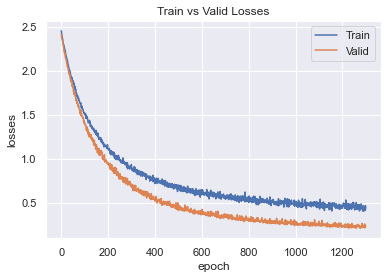

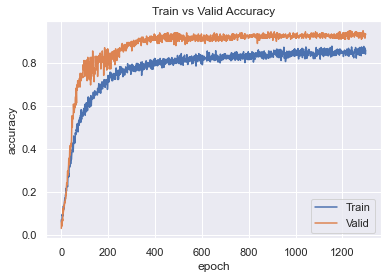

Fold 2
Reset trainable parameters of layer = Linear(in_features=512, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=11, bias=True)
In epoch 1/1300
[train metrics] loss:2.4294 accuracy:0.0705 recall:0.0779 precision:0.0829 f1:0.0388
[valid  metrics] loss:2.3990 accuracy:0.0594 recall:0.0890 precision:0.0289 f1:0.0207
================================save model_2================================
In epoch 2/1300
[train metrics] loss:2.4227 accuracy:0.0817 recall:0.0923 precision:0.0969 f1:0.0584
[valid  metrics] loss:2.3766 accuracy:0.0594 recall:0.0966 precision:0.1148 f1:0.0453
================================save model_2================================
In epoch 3/1300
[train metrics] loss:2.3922 accuracy:0.0879 recall:0.0897 pr

[train metrics] loss:1.9480 accuracy:0.3243 recall:0.3293 precision:0.4823 f1:0.3434
[valid  metrics] loss:1.9228 accuracy:0.4109 recall:0.4463 precision:0.6211 f1:0.4356
In epoch 35/1300
[train metrics] loss:1.9577 accuracy:0.3082 recall:0.3108 precision:0.4492 f1:0.3248
[valid  metrics] loss:1.8930 accuracy:0.3911 recall:0.4449 precision:0.4979 f1:0.4212
================================save model_2================================
In epoch 36/1300
[train metrics] loss:1.9543 accuracy:0.3379 recall:0.3332 precision:0.4736 f1:0.3441
[valid  metrics] loss:1.9094 accuracy:0.3960 recall:0.4520 precision:0.4738 f1:0.4135
In epoch 37/1300
[train metrics] loss:1.9456 accuracy:0.3366 recall:0.3372 precision:0.4989 f1:0.3564
[valid  metrics] loss:1.8807 accuracy:0.4109 recall:0.4687 precision:0.6014 f1:0.4447
================================save model_2================================
In epoch 38/1300
[train metrics] loss:1.9424 accuracy:0.3193 recall:0.3218 precision:0.4853 f1:0.3403
[valid  m

[train metrics] loss:1.6494 accuracy:0.5012 recall:0.5038 precision:0.5996 f1:0.5107
[valid  metrics] loss:1.6301 accuracy:0.5248 recall:0.6034 precision:0.6392 f1:0.5338
In epoch 73/1300
[train metrics] loss:1.6302 accuracy:0.5173 recall:0.5153 precision:0.6055 f1:0.5197
[valid  metrics] loss:1.5449 accuracy:0.5545 recall:0.6229 precision:0.6683 f1:0.5618
================================save model_2================================
In epoch 74/1300
[train metrics] loss:1.6190 accuracy:0.5111 recall:0.5234 precision:0.6032 f1:0.5264
[valid  metrics] loss:1.5807 accuracy:0.5495 recall:0.6142 precision:0.6316 f1:0.5512
In epoch 75/1300
[train metrics] loss:1.6294 accuracy:0.5458 recall:0.5504 precision:0.6388 f1:0.5595
[valid  metrics] loss:1.5704 accuracy:0.5446 recall:0.6079 precision:0.6570 f1:0.5595
In epoch 76/1300
[train metrics] loss:1.6196 accuracy:0.5384 recall:0.5454 precision:0.6224 f1:0.5513
[valid  metrics] loss:1.5569 accuracy:0.5495 recall:0.6041 precision:0.6408 f1:0.5629


[train metrics] loss:1.4207 accuracy:0.6473 recall:0.6548 precision:0.6990 f1:0.6506
[valid  metrics] loss:1.3584 accuracy:0.7327 recall:0.7573 precision:0.7432 f1:0.7114
================================save model_2================================
In epoch 111/1300
[train metrics] loss:1.4152 accuracy:0.6411 recall:0.6419 precision:0.6912 f1:0.6423
[valid  metrics] loss:1.3706 accuracy:0.7426 recall:0.7687 precision:0.7605 f1:0.7249
In epoch 112/1300
[train metrics] loss:1.3967 accuracy:0.6498 recall:0.6564 precision:0.6957 f1:0.6543
[valid  metrics] loss:1.3637 accuracy:0.7030 recall:0.7299 precision:0.7436 f1:0.6899
In epoch 113/1300
[train metrics] loss:1.3831 accuracy:0.6733 recall:0.6765 precision:0.7151 f1:0.6737
[valid  metrics] loss:1.3288 accuracy:0.7475 recall:0.7667 precision:0.7818 f1:0.7348
================================save model_2================================
In epoch 114/1300
[train metrics] loss:1.4014 accuracy:0.6374 recall:0.6413 precision:0.6895 f1:0.6439
[vali

[train metrics] loss:1.2401 accuracy:0.7166 recall:0.7273 precision:0.7437 f1:0.7208
[valid  metrics] loss:1.1779 accuracy:0.7673 recall:0.7795 precision:0.7706 f1:0.7427
In epoch 150/1300
[train metrics] loss:1.2250 accuracy:0.7030 recall:0.7014 precision:0.7348 f1:0.6996
[valid  metrics] loss:1.1752 accuracy:0.7574 recall:0.7837 precision:0.7941 f1:0.7500
In epoch 151/1300
[train metrics] loss:1.2284 accuracy:0.7215 recall:0.7296 precision:0.7518 f1:0.7262
[valid  metrics] loss:1.1761 accuracy:0.7871 recall:0.8073 precision:0.8023 f1:0.7788
In epoch 152/1300
[train metrics] loss:1.2060 accuracy:0.7314 recall:0.7382 precision:0.7585 f1:0.7317
[valid  metrics] loss:1.1521 accuracy:0.7673 recall:0.7892 precision:0.7811 f1:0.7561
In epoch 153/1300
[train metrics] loss:1.2200 accuracy:0.7141 recall:0.7137 precision:0.7383 f1:0.7115
[valid  metrics] loss:1.1710 accuracy:0.7475 recall:0.7713 precision:0.7641 f1:0.7329
In epoch 154/1300
[train metrics] loss:1.1952 accuracy:0.7104 recall:0.71

[train metrics] loss:1.0873 accuracy:0.7673 recall:0.7748 precision:0.7932 f1:0.7718
[valid  metrics] loss:1.1040 accuracy:0.7624 recall:0.7944 precision:0.7865 f1:0.7529
In epoch 190/1300
[train metrics] loss:1.0905 accuracy:0.7426 recall:0.7438 precision:0.7632 f1:0.7419
[valid  metrics] loss:1.0394 accuracy:0.7921 recall:0.8158 precision:0.8006 f1:0.7758
In epoch 191/1300
[train metrics] loss:1.0839 accuracy:0.7550 recall:0.7591 precision:0.7732 f1:0.7562
[valid  metrics] loss:1.0198 accuracy:0.7673 recall:0.7947 precision:0.7799 f1:0.7568
================================save model_2================================
In epoch 192/1300
[train metrics] loss:1.0685 accuracy:0.7587 recall:0.7686 precision:0.7791 f1:0.7629
[valid  metrics] loss:1.0324 accuracy:0.7822 recall:0.8066 precision:0.7790 f1:0.7673
In epoch 193/1300
[train metrics] loss:1.0882 accuracy:0.7413 recall:0.7499 precision:0.7554 f1:0.7413
[valid  metrics] loss:1.0257 accuracy:0.7871 recall:0.8164 precision:0.7951 f1:0.7

[train metrics] loss:0.9717 accuracy:0.7772 recall:0.7784 precision:0.7924 f1:0.7770
[valid  metrics] loss:0.9324 accuracy:0.7970 recall:0.8208 precision:0.7825 f1:0.7818
In epoch 230/1300
[train metrics] loss:0.9642 accuracy:0.7735 recall:0.7810 precision:0.7906 f1:0.7781
[valid  metrics] loss:0.9123 accuracy:0.7970 recall:0.8201 precision:0.7950 f1:0.7892
In epoch 231/1300
[train metrics] loss:0.9837 accuracy:0.7748 recall:0.7795 precision:0.7854 f1:0.7746
[valid  metrics] loss:0.9116 accuracy:0.7970 recall:0.8220 precision:0.7943 f1:0.7881
In epoch 232/1300
[train metrics] loss:0.9693 accuracy:0.7946 recall:0.8012 precision:0.8042 f1:0.7970
[valid  metrics] loss:0.9191 accuracy:0.7871 recall:0.8101 precision:0.7775 f1:0.7719
In epoch 233/1300
[train metrics] loss:0.9626 accuracy:0.8007 recall:0.8078 precision:0.8136 f1:0.8025
[valid  metrics] loss:0.9674 accuracy:0.8020 recall:0.8263 precision:0.7926 f1:0.7933
In epoch 234/1300
[train metrics] loss:0.9420 accuracy:0.8205 recall:0.83

[train metrics] loss:0.8809 accuracy:0.7983 recall:0.8015 precision:0.8083 f1:0.7974
[valid  metrics] loss:0.8207 accuracy:0.7921 recall:0.8178 precision:0.7839 f1:0.7797
In epoch 271/1300
[train metrics] loss:0.8926 accuracy:0.7884 recall:0.7931 precision:0.7972 f1:0.7897
[valid  metrics] loss:0.8543 accuracy:0.7970 recall:0.8229 precision:0.7880 f1:0.7885
In epoch 272/1300
[train metrics] loss:0.8760 accuracy:0.8131 recall:0.8169 precision:0.8164 f1:0.8111
[valid  metrics] loss:0.9038 accuracy:0.7871 recall:0.8132 precision:0.7874 f1:0.7762
In epoch 273/1300
[train metrics] loss:0.8921 accuracy:0.7908 recall:0.7968 precision:0.8024 f1:0.7944
[valid  metrics] loss:0.8172 accuracy:0.8069 recall:0.8300 precision:0.7947 f1:0.7990
================================save model_2================================
In epoch 274/1300
[train metrics] loss:0.8870 accuracy:0.7995 recall:0.8076 precision:0.8110 f1:0.8020
[valid  metrics] loss:0.8397 accuracy:0.8020 recall:0.8280 precision:0.7886 f1:0.7

[train metrics] loss:0.7758 accuracy:0.8280 recall:0.8364 precision:0.8369 f1:0.8320
[valid  metrics] loss:0.7680 accuracy:0.8218 recall:0.8403 precision:0.8084 f1:0.8128
In epoch 313/1300
[train metrics] loss:0.7880 accuracy:0.8218 recall:0.8283 precision:0.8262 f1:0.8226
[valid  metrics] loss:0.7623 accuracy:0.8119 recall:0.8327 precision:0.7987 f1:0.8013
In epoch 314/1300
[train metrics] loss:0.8170 accuracy:0.8280 recall:0.8346 precision:0.8412 f1:0.8337
[valid  metrics] loss:0.7771 accuracy:0.8218 recall:0.8373 precision:0.8049 f1:0.8064
In epoch 315/1300
[train metrics] loss:0.8305 accuracy:0.7748 recall:0.7858 precision:0.7877 f1:0.7815
[valid  metrics] loss:0.7482 accuracy:0.8168 recall:0.8336 precision:0.8107 f1:0.8059
================================save model_2================================
In epoch 316/1300
[train metrics] loss:0.8072 accuracy:0.8094 recall:0.8131 precision:0.8176 f1:0.8105
[valid  metrics] loss:0.7861 accuracy:0.7921 recall:0.8113 precision:0.7906 f1:0.7

[train metrics] loss:0.7182 accuracy:0.8218 recall:0.8297 precision:0.8355 f1:0.8299
[valid  metrics] loss:0.6926 accuracy:0.8317 recall:0.8432 precision:0.8186 f1:0.8201
================================save model_2================================
In epoch 354/1300
[train metrics] loss:0.7727 accuracy:0.8119 recall:0.8181 precision:0.8215 f1:0.8159
[valid  metrics] loss:0.7100 accuracy:0.8317 recall:0.8456 precision:0.8209 f1:0.8199
In epoch 355/1300
[train metrics] loss:0.7476 accuracy:0.7995 recall:0.8006 precision:0.8091 f1:0.8004
[valid  metrics] loss:0.7131 accuracy:0.8267 recall:0.8459 precision:0.8196 f1:0.8211
In epoch 356/1300
[train metrics] loss:0.7287 accuracy:0.8267 recall:0.8321 precision:0.8344 f1:0.8300
[valid  metrics] loss:0.7361 accuracy:0.8218 recall:0.8381 precision:0.8062 f1:0.8123
In epoch 357/1300
[train metrics] loss:0.7799 accuracy:0.7983 recall:0.8067 precision:0.8052 f1:0.8015
[valid  metrics] loss:0.6924 accuracy:0.8267 recall:0.8447 precision:0.8067 f1:0.8

[train metrics] loss:0.6998 accuracy:0.8304 recall:0.8363 precision:0.8390 f1:0.8352
[valid  metrics] loss:0.6600 accuracy:0.8366 recall:0.8457 precision:0.8225 f1:0.8268
================================save model_2================================
In epoch 395/1300
[train metrics] loss:0.7118 accuracy:0.8354 recall:0.8421 precision:0.8372 f1:0.8363
[valid  metrics] loss:0.6844 accuracy:0.8317 recall:0.8507 precision:0.8187 f1:0.8217
In epoch 396/1300
[train metrics] loss:0.6945 accuracy:0.8379 recall:0.8453 precision:0.8460 f1:0.8433
[valid  metrics] loss:0.6953 accuracy:0.8218 recall:0.8379 precision:0.8162 f1:0.8116
In epoch 397/1300
[train metrics] loss:0.7313 accuracy:0.8304 recall:0.8384 precision:0.8402 f1:0.8352
[valid  metrics] loss:0.6844 accuracy:0.8317 recall:0.8479 precision:0.8104 f1:0.8204
In epoch 398/1300
[train metrics] loss:0.7155 accuracy:0.8131 recall:0.8182 precision:0.8186 f1:0.8150
[valid  metrics] loss:0.6786 accuracy:0.8317 recall:0.8434 precision:0.8223 f1:0.8

[train metrics] loss:0.6381 accuracy:0.8478 recall:0.8580 precision:0.8574 f1:0.8558
[valid  metrics] loss:0.6540 accuracy:0.8416 recall:0.8504 precision:0.8261 f1:0.8293
In epoch 436/1300
[train metrics] loss:0.6747 accuracy:0.8379 recall:0.8452 precision:0.8433 f1:0.8416
[valid  metrics] loss:0.6138 accuracy:0.8317 recall:0.8460 precision:0.8184 f1:0.8254
================================save model_2================================
In epoch 437/1300
[train metrics] loss:0.6828 accuracy:0.8205 recall:0.8257 precision:0.8267 f1:0.8214
[valid  metrics] loss:0.6725 accuracy:0.8416 recall:0.8534 precision:0.8266 f1:0.8299
In epoch 438/1300
[train metrics] loss:0.6471 accuracy:0.8465 recall:0.8526 precision:0.8503 f1:0.8487
[valid  metrics] loss:0.6830 accuracy:0.8366 recall:0.8489 precision:0.8226 f1:0.8250
In epoch 439/1300
[train metrics] loss:0.6670 accuracy:0.8366 recall:0.8449 precision:0.8447 f1:0.8427
[valid  metrics] loss:0.6147 accuracy:0.8515 recall:0.8621 precision:0.8331 f1:0.8

[train metrics] loss:0.6221 accuracy:0.8379 recall:0.8445 precision:0.8411 f1:0.8403
[valid  metrics] loss:0.5998 accuracy:0.8267 recall:0.8416 precision:0.8078 f1:0.8141
In epoch 478/1300
[train metrics] loss:0.6296 accuracy:0.8416 recall:0.8507 precision:0.8447 f1:0.8454
[valid  metrics] loss:0.6519 accuracy:0.8416 recall:0.8549 precision:0.8264 f1:0.8308
In epoch 479/1300
[train metrics] loss:0.6522 accuracy:0.8329 recall:0.8415 precision:0.8423 f1:0.8387
[valid  metrics] loss:0.6032 accuracy:0.8267 recall:0.8397 precision:0.8115 f1:0.8129
In epoch 480/1300
[train metrics] loss:0.6164 accuracy:0.8490 recall:0.8527 precision:0.8588 f1:0.8526
[valid  metrics] loss:0.6170 accuracy:0.8465 recall:0.8578 precision:0.8312 f1:0.8390
In epoch 481/1300
[train metrics] loss:0.6552 accuracy:0.8329 recall:0.8357 precision:0.8438 f1:0.8377
[valid  metrics] loss:0.6284 accuracy:0.8317 recall:0.8461 precision:0.8140 f1:0.8195
In epoch 482/1300
[train metrics] loss:0.6273 accuracy:0.8366 recall:0.84

[train metrics] loss:0.6138 accuracy:0.8416 recall:0.8461 precision:0.8485 f1:0.8454
[valid  metrics] loss:0.6166 accuracy:0.8614 recall:0.8689 precision:0.8436 f1:0.8507
In epoch 521/1300
[train metrics] loss:0.5559 accuracy:0.8540 recall:0.8598 precision:0.8621 f1:0.8582
[valid  metrics] loss:0.5627 accuracy:0.8564 recall:0.8647 precision:0.8433 f1:0.8489
In epoch 522/1300
[train metrics] loss:0.6101 accuracy:0.8416 recall:0.8471 precision:0.8471 f1:0.8447
[valid  metrics] loss:0.5432 accuracy:0.8515 recall:0.8614 precision:0.8375 f1:0.8445
================================save model_2================================
In epoch 523/1300
[train metrics] loss:0.5835 accuracy:0.8502 recall:0.8554 precision:0.8575 f1:0.8546
[valid  metrics] loss:0.5810 accuracy:0.8317 recall:0.8426 precision:0.8141 f1:0.8201
In epoch 524/1300
[train metrics] loss:0.6007 accuracy:0.8416 recall:0.8487 precision:0.8507 f1:0.8465
[valid  metrics] loss:0.5709 accuracy:0.8267 recall:0.8426 precision:0.8073 f1:0.8

[train metrics] loss:0.5603 accuracy:0.8379 recall:0.8453 precision:0.8460 f1:0.8436
[valid  metrics] loss:0.5685 accuracy:0.8564 recall:0.8656 precision:0.8385 f1:0.8448
In epoch 564/1300
[train metrics] loss:0.5666 accuracy:0.8366 recall:0.8415 precision:0.8406 f1:0.8389
[valid  metrics] loss:0.5398 accuracy:0.8515 recall:0.8658 precision:0.8373 f1:0.8461
In epoch 565/1300
[train metrics] loss:0.5592 accuracy:0.8391 recall:0.8432 precision:0.8515 f1:0.8445
[valid  metrics] loss:0.5469 accuracy:0.8416 recall:0.8553 precision:0.8274 f1:0.8346
In epoch 566/1300
[train metrics] loss:0.5560 accuracy:0.8651 recall:0.8699 precision:0.8729 f1:0.8704
[valid  metrics] loss:0.5412 accuracy:0.8515 recall:0.8604 precision:0.8340 f1:0.8380
In epoch 567/1300
[train metrics] loss:0.5575 accuracy:0.8663 recall:0.8722 precision:0.8732 f1:0.8709
[valid  metrics] loss:0.5670 accuracy:0.8465 recall:0.8578 precision:0.8340 f1:0.8396
In epoch 568/1300
[train metrics] loss:0.5962 accuracy:0.8366 recall:0.84

[train metrics] loss:0.5645 accuracy:0.8366 recall:0.8408 precision:0.8382 f1:0.8373
[valid  metrics] loss:0.5383 accuracy:0.8465 recall:0.8575 precision:0.8316 f1:0.8330
In epoch 607/1300
[train metrics] loss:0.5494 accuracy:0.8601 recall:0.8640 precision:0.8642 f1:0.8627
[valid  metrics] loss:0.5912 accuracy:0.8663 recall:0.8772 precision:0.8504 f1:0.8535
In epoch 608/1300
[train metrics] loss:0.5266 accuracy:0.8540 recall:0.8631 precision:0.8590 f1:0.8587
[valid  metrics] loss:0.5455 accuracy:0.8515 recall:0.8687 precision:0.8297 f1:0.8407
In epoch 609/1300
[train metrics] loss:0.5425 accuracy:0.8515 recall:0.8596 precision:0.8638 f1:0.8588
[valid  metrics] loss:0.5673 accuracy:0.8663 recall:0.8761 precision:0.8511 f1:0.8581
In epoch 610/1300
[train metrics] loss:0.5321 accuracy:0.8577 recall:0.8642 precision:0.8637 f1:0.8619
[valid  metrics] loss:0.5452 accuracy:0.8416 recall:0.8589 precision:0.8247 f1:0.8327
In epoch 611/1300
[train metrics] loss:0.5692 accuracy:0.8441 recall:0.84

[train metrics] loss:0.5436 accuracy:0.8403 recall:0.8468 precision:0.8470 f1:0.8449
[valid  metrics] loss:0.5196 accuracy:0.8713 recall:0.8804 precision:0.8597 f1:0.8641
In epoch 650/1300
[train metrics] loss:0.5265 accuracy:0.8540 recall:0.8597 precision:0.8554 f1:0.8549
[valid  metrics] loss:0.5208 accuracy:0.8614 recall:0.8730 precision:0.8473 f1:0.8547
In epoch 651/1300
[train metrics] loss:0.4787 accuracy:0.8738 recall:0.8757 precision:0.8814 f1:0.8765
[valid  metrics] loss:0.5142 accuracy:0.8614 recall:0.8731 precision:0.8484 f1:0.8544
In epoch 652/1300
[train metrics] loss:0.5086 accuracy:0.8676 recall:0.8768 precision:0.8749 f1:0.8738
[valid  metrics] loss:0.5055 accuracy:0.8564 recall:0.8700 precision:0.8435 f1:0.8502
In epoch 653/1300
[train metrics] loss:0.5150 accuracy:0.8527 recall:0.8520 precision:0.8589 f1:0.8542
[valid  metrics] loss:0.5743 accuracy:0.8465 recall:0.8574 precision:0.8383 f1:0.8408
In epoch 654/1300
[train metrics] loss:0.5222 accuracy:0.8552 recall:0.86

[train metrics] loss:0.4960 accuracy:0.8577 recall:0.8641 precision:0.8664 f1:0.8641
[valid  metrics] loss:0.5063 accuracy:0.8564 recall:0.8648 precision:0.8449 f1:0.8488
In epoch 693/1300
[train metrics] loss:0.4825 accuracy:0.8725 recall:0.8799 precision:0.8757 f1:0.8763
[valid  metrics] loss:0.5106 accuracy:0.8713 recall:0.8832 precision:0.8588 f1:0.8658
In epoch 694/1300
[train metrics] loss:0.4976 accuracy:0.8651 recall:0.8726 precision:0.8717 f1:0.8711
[valid  metrics] loss:0.5316 accuracy:0.8614 recall:0.8674 precision:0.8428 f1:0.8469
In epoch 695/1300
[train metrics] loss:0.4929 accuracy:0.8700 recall:0.8768 precision:0.8788 f1:0.8761
[valid  metrics] loss:0.5004 accuracy:0.8713 recall:0.8827 precision:0.8638 f1:0.8679
In epoch 696/1300
[train metrics] loss:0.5386 accuracy:0.8552 recall:0.8608 precision:0.8600 f1:0.8592
[valid  metrics] loss:0.4992 accuracy:0.8762 recall:0.8791 precision:0.8644 f1:0.8653
In epoch 697/1300
[train metrics] loss:0.4912 accuracy:0.8527 recall:0.85

[train metrics] loss:0.5088 accuracy:0.8552 recall:0.8639 precision:0.8604 f1:0.8606
[valid  metrics] loss:0.4843 accuracy:0.8614 recall:0.8695 precision:0.8503 f1:0.8541
In epoch 736/1300
[train metrics] loss:0.5349 accuracy:0.8243 recall:0.8259 precision:0.8330 f1:0.8276
[valid  metrics] loss:0.4929 accuracy:0.8465 recall:0.8570 precision:0.8391 f1:0.8358
In epoch 737/1300
[train metrics] loss:0.4855 accuracy:0.8676 recall:0.8724 precision:0.8728 f1:0.8711
[valid  metrics] loss:0.5152 accuracy:0.8614 recall:0.8677 precision:0.8508 f1:0.8533
In epoch 738/1300
[train metrics] loss:0.5171 accuracy:0.8416 recall:0.8512 precision:0.8554 f1:0.8516
[valid  metrics] loss:0.5210 accuracy:0.8366 recall:0.8483 precision:0.8297 f1:0.8295
In epoch 739/1300
[train metrics] loss:0.4982 accuracy:0.8527 recall:0.8584 precision:0.8560 f1:0.8557
[valid  metrics] loss:0.4880 accuracy:0.8515 recall:0.8605 precision:0.8380 f1:0.8416
In epoch 740/1300
[train metrics] loss:0.4764 accuracy:0.8700 recall:0.87

[train metrics] loss:0.4581 accuracy:0.8738 recall:0.8786 precision:0.8786 f1:0.8775
[valid  metrics] loss:0.5318 accuracy:0.8762 recall:0.8812 precision:0.8757 f1:0.8698
In epoch 779/1300
[train metrics] loss:0.4495 accuracy:0.8676 recall:0.8736 precision:0.8765 f1:0.8737
[valid  metrics] loss:0.4895 accuracy:0.8218 recall:0.8383 precision:0.8146 f1:0.8209
In epoch 780/1300
[train metrics] loss:0.4934 accuracy:0.8490 recall:0.8524 precision:0.8595 f1:0.8542
[valid  metrics] loss:0.4733 accuracy:0.8564 recall:0.8701 precision:0.8493 f1:0.8484
In epoch 781/1300
[train metrics] loss:0.4755 accuracy:0.8663 recall:0.8716 precision:0.8711 f1:0.8705
[valid  metrics] loss:0.4684 accuracy:0.8713 recall:0.8836 precision:0.8649 f1:0.8706
================================save model_2================================
In epoch 782/1300
[train metrics] loss:0.4831 accuracy:0.8441 recall:0.8545 precision:0.8523 f1:0.8517
[valid  metrics] loss:0.4777 accuracy:0.8416 recall:0.8540 precision:0.8302 f1:0.8

[train metrics] loss:0.4360 accuracy:0.8725 recall:0.8793 precision:0.8759 f1:0.8755
[valid  metrics] loss:0.4712 accuracy:0.8812 recall:0.8846 precision:0.8776 f1:0.8765
In epoch 822/1300
[train metrics] loss:0.4674 accuracy:0.8676 recall:0.8736 precision:0.8754 f1:0.8728
[valid  metrics] loss:0.4720 accuracy:0.8465 recall:0.8561 precision:0.8361 f1:0.8410
In epoch 823/1300
[train metrics] loss:0.4997 accuracy:0.8391 recall:0.8484 precision:0.8453 f1:0.8454
[valid  metrics] loss:0.4582 accuracy:0.8416 recall:0.8537 precision:0.8400 f1:0.8405
In epoch 824/1300
[train metrics] loss:0.4810 accuracy:0.8738 recall:0.8758 precision:0.8828 f1:0.8783
[valid  metrics] loss:0.4824 accuracy:0.8861 recall:0.8918 precision:0.8820 f1:0.8818
In epoch 825/1300
[train metrics] loss:0.4874 accuracy:0.8589 recall:0.8621 precision:0.8614 f1:0.8603
[valid  metrics] loss:0.4920 accuracy:0.8515 recall:0.8638 precision:0.8370 f1:0.8437
In epoch 826/1300
[train metrics] loss:0.4747 accuracy:0.8465 recall:0.85

[train metrics] loss:0.4412 accuracy:0.8614 recall:0.8681 precision:0.8669 f1:0.8660
[valid  metrics] loss:0.5039 accuracy:0.8812 recall:0.8861 precision:0.8723 f1:0.8747
In epoch 865/1300
[train metrics] loss:0.4365 accuracy:0.8527 recall:0.8622 precision:0.8634 f1:0.8617
[valid  metrics] loss:0.4802 accuracy:0.8564 recall:0.8708 precision:0.8499 f1:0.8535
In epoch 866/1300
[train metrics] loss:0.4512 accuracy:0.8688 recall:0.8737 precision:0.8761 f1:0.8734
[valid  metrics] loss:0.4549 accuracy:0.8614 recall:0.8700 precision:0.8545 f1:0.8586
In epoch 867/1300
[train metrics] loss:0.4264 accuracy:0.8639 recall:0.8699 precision:0.8727 f1:0.8691
[valid  metrics] loss:0.4668 accuracy:0.8564 recall:0.8750 precision:0.8484 f1:0.8567
In epoch 868/1300
[train metrics] loss:0.4751 accuracy:0.8552 recall:0.8610 precision:0.8612 f1:0.8595
[valid  metrics] loss:0.4694 accuracy:0.8465 recall:0.8635 precision:0.8341 f1:0.8432
In epoch 869/1300
[train metrics] loss:0.4380 accuracy:0.8688 recall:0.87

[train metrics] loss:0.4757 accuracy:0.8515 recall:0.8597 precision:0.8604 f1:0.8584
[valid  metrics] loss:0.4560 accuracy:0.8762 recall:0.8810 precision:0.8673 f1:0.8684
In epoch 908/1300
[train metrics] loss:0.4688 accuracy:0.8614 recall:0.8680 precision:0.8706 f1:0.8676
[valid  metrics] loss:0.4728 accuracy:0.8762 recall:0.8809 precision:0.8582 f1:0.8618
In epoch 909/1300
[train metrics] loss:0.4227 accuracy:0.8713 recall:0.8758 precision:0.8746 f1:0.8742
[valid  metrics] loss:0.4521 accuracy:0.8564 recall:0.8658 precision:0.8487 f1:0.8509
In epoch 910/1300
[train metrics] loss:0.4614 accuracy:0.8725 recall:0.8770 precision:0.8755 f1:0.8755
[valid  metrics] loss:0.4731 accuracy:0.8515 recall:0.8607 precision:0.8428 f1:0.8451
In epoch 911/1300
[train metrics] loss:0.4468 accuracy:0.8564 recall:0.8608 precision:0.8592 f1:0.8581
[valid  metrics] loss:0.4502 accuracy:0.8614 recall:0.8703 precision:0.8562 f1:0.8552
In epoch 912/1300
[train metrics] loss:0.4077 accuracy:0.8849 recall:0.89

[train metrics] loss:0.3997 accuracy:0.8725 recall:0.8838 precision:0.8807 f1:0.8802
[valid  metrics] loss:0.4493 accuracy:0.8416 recall:0.8556 precision:0.8386 f1:0.8435
In epoch 951/1300
[train metrics] loss:0.4238 accuracy:0.8676 recall:0.8740 precision:0.8782 f1:0.8743
[valid  metrics] loss:0.4946 accuracy:0.8713 recall:0.8817 precision:0.8597 f1:0.8639
In epoch 952/1300
[train metrics] loss:0.5025 accuracy:0.8317 recall:0.8389 precision:0.8439 f1:0.8404
[valid  metrics] loss:0.4637 accuracy:0.8713 recall:0.8773 precision:0.8590 f1:0.8576
In epoch 953/1300
[train metrics] loss:0.4252 accuracy:0.8651 recall:0.8731 precision:0.8718 f1:0.8710
[valid  metrics] loss:0.5047 accuracy:0.8713 recall:0.8765 precision:0.8695 f1:0.8642
In epoch 954/1300
[train metrics] loss:0.4169 accuracy:0.8663 recall:0.8718 precision:0.8714 f1:0.8710
[valid  metrics] loss:0.4482 accuracy:0.8713 recall:0.8768 precision:0.8578 f1:0.8630
In epoch 955/1300
[train metrics] loss:0.4341 accuracy:0.8626 recall:0.86

[train metrics] loss:0.3981 accuracy:0.8725 recall:0.8794 precision:0.8754 f1:0.8759
[valid  metrics] loss:0.4373 accuracy:0.8416 recall:0.8545 precision:0.8391 f1:0.8440
In epoch 994/1300
[train metrics] loss:0.4163 accuracy:0.8626 recall:0.8708 precision:0.8683 f1:0.8675
[valid  metrics] loss:0.4415 accuracy:0.8366 recall:0.8501 precision:0.8296 f1:0.8356
In epoch 995/1300
[train metrics] loss:0.4525 accuracy:0.8651 recall:0.8688 precision:0.8738 f1:0.8705
[valid  metrics] loss:0.4730 accuracy:0.8515 recall:0.8641 precision:0.8345 f1:0.8442
In epoch 996/1300
[train metrics] loss:0.4295 accuracy:0.8601 recall:0.8620 precision:0.8649 f1:0.8627
[valid  metrics] loss:0.4584 accuracy:0.8564 recall:0.8665 precision:0.8484 f1:0.8478
In epoch 997/1300
[train metrics] loss:0.4346 accuracy:0.8552 recall:0.8626 precision:0.8627 f1:0.8615
[valid  metrics] loss:0.4582 accuracy:0.8663 recall:0.8731 precision:0.8587 f1:0.8602
In epoch 998/1300
[train metrics] loss:0.3878 accuracy:0.8775 recall:0.88

[train metrics] loss:0.4087 accuracy:0.8713 recall:0.8764 precision:0.8769 f1:0.8752
[valid  metrics] loss:0.4982 accuracy:0.8564 recall:0.8652 precision:0.8560 f1:0.8578
In epoch 1038/1300
[train metrics] loss:0.4264 accuracy:0.8738 recall:0.8810 precision:0.8793 f1:0.8788
[valid  metrics] loss:0.4256 accuracy:0.8663 recall:0.8747 precision:0.8642 f1:0.8622
================================save model_2================================
In epoch 1039/1300
[train metrics] loss:0.3866 accuracy:0.8911 recall:0.8958 precision:0.8967 f1:0.8957
[valid  metrics] loss:0.4399 accuracy:0.8713 recall:0.8761 precision:0.8634 f1:0.8647
In epoch 1040/1300
[train metrics] loss:0.4164 accuracy:0.8589 recall:0.8658 precision:0.8679 f1:0.8639
[valid  metrics] loss:0.4805 accuracy:0.8614 recall:0.8692 precision:0.8560 f1:0.8559
In epoch 1041/1300
[train metrics] loss:0.4220 accuracy:0.8725 recall:0.8808 precision:0.8760 f1:0.8774
[valid  metrics] loss:0.4475 accuracy:0.8465 recall:0.8580 precision:0.8331 f1

[train metrics] loss:0.4100 accuracy:0.8676 recall:0.8755 precision:0.8737 f1:0.8735
[valid  metrics] loss:0.4363 accuracy:0.8564 recall:0.8627 precision:0.8480 f1:0.8503
In epoch 1080/1300
[train metrics] loss:0.4132 accuracy:0.8614 recall:0.8675 precision:0.8749 f1:0.8692
[valid  metrics] loss:0.4520 accuracy:0.8713 recall:0.8756 precision:0.8591 f1:0.8600
In epoch 1081/1300
[train metrics] loss:0.4195 accuracy:0.8688 recall:0.8742 precision:0.8714 f1:0.8716
[valid  metrics] loss:0.4413 accuracy:0.8564 recall:0.8637 precision:0.8464 f1:0.8503
In epoch 1082/1300
[train metrics] loss:0.4158 accuracy:0.8651 recall:0.8745 precision:0.8731 f1:0.8724
[valid  metrics] loss:0.4491 accuracy:0.8812 recall:0.8852 precision:0.8777 f1:0.8728
In epoch 1083/1300
[train metrics] loss:0.3950 accuracy:0.8800 recall:0.8887 precision:0.8889 f1:0.8873
[valid  metrics] loss:0.4397 accuracy:0.8762 recall:0.8808 precision:0.8684 f1:0.8679
In epoch 1084/1300
[train metrics] loss:0.4150 accuracy:0.8688 recall

[train metrics] loss:0.4109 accuracy:0.8750 recall:0.8802 precision:0.8781 f1:0.8788
[valid  metrics] loss:0.4334 accuracy:0.8713 recall:0.8788 precision:0.8637 f1:0.8647
In epoch 1123/1300
[train metrics] loss:0.4127 accuracy:0.8601 recall:0.8650 precision:0.8655 f1:0.8641
[valid  metrics] loss:0.4374 accuracy:0.8564 recall:0.8661 precision:0.8457 f1:0.8469
In epoch 1124/1300
[train metrics] loss:0.3945 accuracy:0.8688 recall:0.8735 precision:0.8731 f1:0.8719
[valid  metrics] loss:0.4294 accuracy:0.8564 recall:0.8686 precision:0.8436 f1:0.8478
In epoch 1125/1300
[train metrics] loss:0.4044 accuracy:0.8589 recall:0.8643 precision:0.8635 f1:0.8628
[valid  metrics] loss:0.4329 accuracy:0.8564 recall:0.8630 precision:0.8467 f1:0.8473
In epoch 1126/1300
[train metrics] loss:0.3841 accuracy:0.8812 recall:0.8863 precision:0.8866 f1:0.8860
[valid  metrics] loss:0.4537 accuracy:0.8564 recall:0.8658 precision:0.8449 f1:0.8476
In epoch 1127/1300
[train metrics] loss:0.4101 accuracy:0.8738 recall

[train metrics] loss:0.4058 accuracy:0.8787 recall:0.8826 precision:0.8837 f1:0.8818
[valid  metrics] loss:0.4703 accuracy:0.8663 recall:0.8727 precision:0.8563 f1:0.8582
In epoch 1166/1300
[train metrics] loss:0.4305 accuracy:0.8725 recall:0.8801 precision:0.8809 f1:0.8793
[valid  metrics] loss:0.4545 accuracy:0.8614 recall:0.8689 precision:0.8574 f1:0.8589
In epoch 1167/1300
[train metrics] loss:0.4406 accuracy:0.8614 recall:0.8678 precision:0.8694 f1:0.8673
[valid  metrics] loss:0.4134 accuracy:0.8564 recall:0.8668 precision:0.8524 f1:0.8567
================================save model_2================================
In epoch 1168/1300
[train metrics] loss:0.3898 accuracy:0.8738 recall:0.8799 precision:0.8814 f1:0.8799
[valid  metrics] loss:0.4274 accuracy:0.8614 recall:0.8642 precision:0.8552 f1:0.8532
In epoch 1169/1300
[train metrics] loss:0.3857 accuracy:0.8725 recall:0.8800 precision:0.8789 f1:0.8781
[valid  metrics] loss:0.4228 accuracy:0.8515 recall:0.8604 precision:0.8409 f1

[train metrics] loss:0.3797 accuracy:0.8651 recall:0.8706 precision:0.8677 f1:0.8681
[valid  metrics] loss:0.4283 accuracy:0.8515 recall:0.8567 precision:0.8415 f1:0.8414
In epoch 1209/1300
[train metrics] loss:0.3728 accuracy:0.8800 recall:0.8867 precision:0.8825 f1:0.8831
[valid  metrics] loss:0.4239 accuracy:0.8564 recall:0.8639 precision:0.8433 f1:0.8449
In epoch 1210/1300
[train metrics] loss:0.4114 accuracy:0.8614 recall:0.8687 precision:0.8651 f1:0.8656
[valid  metrics] loss:0.4250 accuracy:0.8663 recall:0.8756 precision:0.8608 f1:0.8651
In epoch 1211/1300
[train metrics] loss:0.4119 accuracy:0.8738 recall:0.8803 precision:0.8769 f1:0.8777
[valid  metrics] loss:0.4211 accuracy:0.8614 recall:0.8677 precision:0.8581 f1:0.8592
In epoch 1212/1300
[train metrics] loss:0.3793 accuracy:0.8800 recall:0.8838 precision:0.8864 f1:0.8840
[valid  metrics] loss:0.4643 accuracy:0.8861 recall:0.8884 precision:0.8815 f1:0.8803
In epoch 1213/1300
[train metrics] loss:0.3805 accuracy:0.8812 recall

[train metrics] loss:0.4040 accuracy:0.8688 recall:0.8782 precision:0.8741 f1:0.8747
[valid  metrics] loss:0.4337 accuracy:0.8663 recall:0.8725 precision:0.8591 f1:0.8601
In epoch 1252/1300
[train metrics] loss:0.3916 accuracy:0.8700 recall:0.8753 precision:0.8786 f1:0.8756
[valid  metrics] loss:0.4388 accuracy:0.8812 recall:0.8896 precision:0.8713 f1:0.8751
In epoch 1253/1300
[train metrics] loss:0.3881 accuracy:0.8663 recall:0.8690 precision:0.8709 f1:0.8690
[valid  metrics] loss:0.4335 accuracy:0.8663 recall:0.8710 precision:0.8624 f1:0.8629
In epoch 1254/1300
[train metrics] loss:0.4176 accuracy:0.8676 recall:0.8726 precision:0.8763 f1:0.8735
[valid  metrics] loss:0.4386 accuracy:0.8416 recall:0.8482 precision:0.8306 f1:0.8319
In epoch 1255/1300
[train metrics] loss:0.4148 accuracy:0.8626 recall:0.8684 precision:0.8714 f1:0.8693
[valid  metrics] loss:0.4435 accuracy:0.8465 recall:0.8567 precision:0.8431 f1:0.8402
In epoch 1256/1300
[train metrics] loss:0.3848 accuracy:0.8725 recall

[train metrics] loss:0.3933 accuracy:0.8725 recall:0.8778 precision:0.8802 f1:0.8782
[valid  metrics] loss:0.4119 accuracy:0.8564 recall:0.8629 precision:0.8528 f1:0.8549
In epoch 1294/1300
[train metrics] loss:0.3891 accuracy:0.8800 recall:0.8883 precision:0.8867 f1:0.8868
[valid  metrics] loss:0.4129 accuracy:0.8713 recall:0.8752 precision:0.8642 f1:0.8639
In epoch 1295/1300
[train metrics] loss:0.3707 accuracy:0.8713 recall:0.8743 precision:0.8801 f1:0.8758
[valid  metrics] loss:0.4120 accuracy:0.8762 recall:0.8829 precision:0.8730 f1:0.8716
In epoch 1296/1300
[train metrics] loss:0.3796 accuracy:0.8775 recall:0.8815 precision:0.8831 f1:0.8814
[valid  metrics] loss:0.4094 accuracy:0.8564 recall:0.8661 precision:0.8532 f1:0.8574
In epoch 1297/1300
[train metrics] loss:0.3939 accuracy:0.8812 recall:0.8888 precision:0.8860 f1:0.8860
[valid  metrics] loss:0.4251 accuracy:0.8663 recall:0.8683 precision:0.8602 f1:0.8566
In epoch 1298/1300
[train metrics] loss:0.3907 accuracy:0.8824 recall

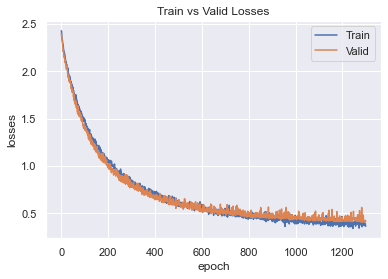

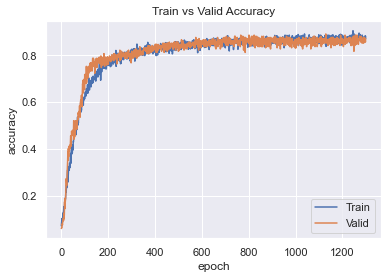

Fold 3
Reset trainable parameters of layer = Linear(in_features=512, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=11, bias=True)
In epoch 1/1300
[train metrics] loss:2.4834 accuracy:0.0978 recall:0.1117 precision:0.1074 f1:0.0834
[valid  metrics] loss:2.4166 accuracy:0.1832 recall:0.2029 precision:0.2084 f1:0.1338
================================save model_3================================
In epoch 2/1300
[train metrics] loss:2.4477 accuracy:0.0978 recall:0.1076 precision:0.1064 f1:0.0829
[valid  metrics] loss:2.4108 accuracy:0.1634 recall:0.1848 precision:0.2135 f1:0.1180
================================save model_3================================
In epoch 3/1300
[train metrics] loss:2.3975 accuracy:0.1287 recall:0.1389 pr

[train metrics] loss:2.0492 accuracy:0.3280 recall:0.3253 precision:0.3416 f1:0.2996
[valid  metrics] loss:1.9572 accuracy:0.5000 recall:0.4812 precision:0.4786 f1:0.4323
================================save model_3================================
In epoch 33/1300
[train metrics] loss:2.0297 accuracy:0.3230 recall:0.3217 precision:0.3387 f1:0.3031
[valid  metrics] loss:1.9587 accuracy:0.5297 recall:0.5135 precision:0.5248 f1:0.4738
In epoch 34/1300
[train metrics] loss:2.0340 accuracy:0.3379 recall:0.3417 precision:0.3407 f1:0.3092
[valid  metrics] loss:1.9507 accuracy:0.5396 recall:0.5207 precision:0.5045 f1:0.4694
================================save model_3================================
In epoch 35/1300
[train metrics] loss:2.0205 accuracy:0.3502 recall:0.3440 precision:0.3496 f1:0.3193
[valid  metrics] loss:1.9172 accuracy:0.5545 recall:0.5324 precision:0.5508 f1:0.4962
================================save model_3================================
In epoch 36/1300
[train metrics] l

[train metrics] loss:1.7654 accuracy:0.4356 recall:0.4319 precision:0.4792 f1:0.4046
[valid  metrics] loss:1.6626 accuracy:0.6535 recall:0.6193 precision:0.5641 f1:0.5597
In epoch 68/1300
[train metrics] loss:1.7588 accuracy:0.4851 recall:0.4835 precision:0.4877 f1:0.4502
[valid  metrics] loss:1.6258 accuracy:0.6980 recall:0.6698 precision:0.6516 f1:0.6271
================================save model_3================================
In epoch 69/1300
[train metrics] loss:1.7468 accuracy:0.4629 recall:0.4590 precision:0.4774 f1:0.4233
[valid  metrics] loss:1.6197 accuracy:0.5990 recall:0.5869 precision:0.5805 f1:0.5391
================================save model_3================================
In epoch 70/1300
[train metrics] loss:1.7382 accuracy:0.4666 recall:0.4761 precision:0.4831 f1:0.4467
[valid  metrics] loss:1.6371 accuracy:0.6040 recall:0.5942 precision:0.5564 f1:0.5368
In epoch 71/1300
[train metrics] loss:1.7438 accuracy:0.4740 recall:0.4724 precision:0.4894 f1:0.4425
[valid  m

[train metrics] loss:1.5319 accuracy:0.5483 recall:0.5638 precision:0.5828 f1:0.5321
[valid  metrics] loss:1.3847 accuracy:0.6980 recall:0.7001 precision:0.6931 f1:0.6709
================================save model_3================================
In epoch 105/1300
[train metrics] loss:1.5424 accuracy:0.5408 recall:0.5512 precision:0.5862 f1:0.5253
[valid  metrics] loss:1.3406 accuracy:0.6832 recall:0.6942 precision:0.7074 f1:0.6619
================================save model_3================================
In epoch 106/1300
[train metrics] loss:1.5225 accuracy:0.5705 recall:0.5862 precision:0.6168 f1:0.5585
[valid  metrics] loss:1.3741 accuracy:0.7129 recall:0.7204 precision:0.7125 f1:0.6906
In epoch 107/1300
[train metrics] loss:1.5273 accuracy:0.5631 recall:0.5803 precision:0.6425 f1:0.5596
[valid  metrics] loss:1.3854 accuracy:0.7475 recall:0.7485 precision:0.7151 f1:0.7150
In epoch 108/1300
[train metrics] loss:1.5328 accuracy:0.5730 recall:0.5934 precision:0.6244 f1:0.5656
[vali

[train metrics] loss:1.3663 accuracy:0.6436 recall:0.6682 precision:0.6762 f1:0.6364
[valid  metrics] loss:1.1824 accuracy:0.8218 recall:0.8163 precision:0.8756 f1:0.8026
In epoch 144/1300
[train metrics] loss:1.3499 accuracy:0.6337 recall:0.6630 precision:0.6793 f1:0.6332
[valid  metrics] loss:1.1642 accuracy:0.8069 recall:0.8060 precision:0.8434 f1:0.7830
In epoch 145/1300
[train metrics] loss:1.3129 accuracy:0.6609 recall:0.6894 precision:0.6970 f1:0.6575
[valid  metrics] loss:1.1647 accuracy:0.8168 recall:0.8163 precision:0.8704 f1:0.7986
In epoch 146/1300
[train metrics] loss:1.3406 accuracy:0.6386 recall:0.6674 precision:0.7326 f1:0.6378
[valid  metrics] loss:1.1734 accuracy:0.8218 recall:0.8163 precision:0.8756 f1:0.8026
In epoch 147/1300
[train metrics] loss:1.3564 accuracy:0.6312 recall:0.6552 precision:0.6590 f1:0.6186
[valid  metrics] loss:1.1654 accuracy:0.8267 recall:0.8248 precision:0.8628 f1:0.8105
In epoch 148/1300
[train metrics] loss:1.3256 accuracy:0.6473 recall:0.68

[train metrics] loss:1.2259 accuracy:0.6683 recall:0.6889 precision:0.7116 f1:0.6625
[valid  metrics] loss:1.0217 accuracy:0.8020 recall:0.7966 precision:0.8587 f1:0.7823
In epoch 183/1300
[train metrics] loss:1.2455 accuracy:0.6646 recall:0.6836 precision:0.6969 f1:0.6531
[valid  metrics] loss:0.9923 accuracy:0.8515 recall:0.8511 precision:0.8848 f1:0.8367
In epoch 184/1300
[train metrics] loss:1.2296 accuracy:0.6733 recall:0.7018 precision:0.7079 f1:0.6703
[valid  metrics] loss:0.9798 accuracy:0.8168 recall:0.8141 precision:0.8680 f1:0.7996
In epoch 185/1300
[train metrics] loss:1.2088 accuracy:0.6993 recall:0.7243 precision:0.7187 f1:0.6932
[valid  metrics] loss:0.9947 accuracy:0.8564 recall:0.8548 precision:0.8856 f1:0.8391
In epoch 186/1300
[train metrics] loss:1.2066 accuracy:0.7054 recall:0.7306 precision:0.7537 f1:0.7036
[valid  metrics] loss:0.9896 accuracy:0.8119 recall:0.8117 precision:0.8784 f1:0.7930
In epoch 187/1300
[train metrics] loss:1.2241 accuracy:0.6683 recall:0.69

[train metrics] loss:1.1026 accuracy:0.7005 recall:0.7226 precision:0.7371 f1:0.6937
[valid  metrics] loss:0.8370 accuracy:0.8366 recall:0.8368 precision:0.8778 f1:0.8119
================================save model_3================================
In epoch 223/1300
[train metrics] loss:1.0995 accuracy:0.7017 recall:0.7264 precision:0.7419 f1:0.7047
[valid  metrics] loss:0.8577 accuracy:0.8416 recall:0.8405 precision:0.8858 f1:0.8287
In epoch 224/1300
[train metrics] loss:1.1262 accuracy:0.7092 recall:0.7282 precision:0.7496 f1:0.7068
[valid  metrics] loss:0.8082 accuracy:0.8614 recall:0.8563 precision:0.8961 f1:0.8411
================================save model_3================================
In epoch 225/1300
[train metrics] loss:1.0611 accuracy:0.7351 recall:0.7548 precision:0.7751 f1:0.7310
[valid  metrics] loss:0.8671 accuracy:0.8663 recall:0.8684 precision:0.8831 f1:0.8515
In epoch 226/1300
[train metrics] loss:1.0979 accuracy:0.7215 recall:0.7377 precision:0.7419 f1:0.7181
[vali

[train metrics] loss:0.9610 accuracy:0.7735 recall:0.7939 precision:0.7908 f1:0.7752
[valid  metrics] loss:0.7573 accuracy:0.8911 recall:0.8911 precision:0.9105 f1:0.8814
In epoch 264/1300
[train metrics] loss:1.0012 accuracy:0.7302 recall:0.7480 precision:0.7509 f1:0.7339
[valid  metrics] loss:0.7410 accuracy:0.8614 recall:0.8548 precision:0.8783 f1:0.8450
In epoch 265/1300
[train metrics] loss:1.0199 accuracy:0.7463 recall:0.7676 precision:0.7658 f1:0.7489
[valid  metrics] loss:0.7445 accuracy:0.8663 recall:0.8623 precision:0.8904 f1:0.8505
In epoch 266/1300
[train metrics] loss:1.0222 accuracy:0.7389 recall:0.7590 precision:0.7664 f1:0.7428
[valid  metrics] loss:0.7565 accuracy:0.8663 recall:0.8608 precision:0.8961 f1:0.8535
In epoch 267/1300
[train metrics] loss:1.0042 accuracy:0.7327 recall:0.7538 precision:0.7521 f1:0.7294
[valid  metrics] loss:0.7612 accuracy:0.8762 recall:0.8729 precision:0.8967 f1:0.8699
In epoch 268/1300
[train metrics] loss:1.0281 accuracy:0.7512 recall:0.77

[train metrics] loss:0.9223 accuracy:0.7723 recall:0.7924 precision:0.7896 f1:0.7757
[valid  metrics] loss:0.6871 accuracy:0.9059 recall:0.9002 precision:0.9085 f1:0.8975
In epoch 306/1300
[train metrics] loss:0.9425 accuracy:0.7537 recall:0.7729 precision:0.7723 f1:0.7595
[valid  metrics] loss:0.6231 accuracy:0.9010 recall:0.8942 precision:0.9058 f1:0.8914
================================save model_3================================
In epoch 307/1300
[train metrics] loss:0.9494 accuracy:0.7550 recall:0.7745 precision:0.7711 f1:0.7609
[valid  metrics] loss:0.6407 accuracy:0.9059 recall:0.9048 precision:0.9146 f1:0.8980
In epoch 308/1300
[train metrics] loss:0.9185 accuracy:0.7649 recall:0.7836 precision:0.7834 f1:0.7692
[valid  metrics] loss:0.6320 accuracy:0.8960 recall:0.8896 precision:0.8971 f1:0.8860
In epoch 309/1300
[train metrics] loss:0.9380 accuracy:0.7636 recall:0.7827 precision:0.7748 f1:0.7686
[valid  metrics] loss:0.6666 accuracy:0.9208 recall:0.9154 precision:0.9221 f1:0.9

[train metrics] loss:0.8789 accuracy:0.7958 recall:0.8106 precision:0.8083 f1:0.8020
[valid  metrics] loss:0.5847 accuracy:0.9010 recall:0.8979 precision:0.9040 f1:0.8941
In epoch 347/1300
[train metrics] loss:0.8722 accuracy:0.7611 recall:0.7811 precision:0.7768 f1:0.7683
[valid  metrics] loss:0.6113 accuracy:0.8812 recall:0.8782 precision:0.8833 f1:0.8727
In epoch 348/1300
[train metrics] loss:0.8409 accuracy:0.7908 recall:0.8017 precision:0.7995 f1:0.7934
[valid  metrics] loss:0.5730 accuracy:0.9010 recall:0.8972 precision:0.9056 f1:0.8928
In epoch 349/1300
[train metrics] loss:0.8768 accuracy:0.7624 recall:0.7778 precision:0.7791 f1:0.7674
[valid  metrics] loss:0.5528 accuracy:0.9158 recall:0.9123 precision:0.9170 f1:0.9098
In epoch 350/1300
[train metrics] loss:0.8837 accuracy:0.7599 recall:0.7785 precision:0.7678 f1:0.7622
[valid  metrics] loss:0.5604 accuracy:0.9109 recall:0.9093 precision:0.9167 f1:0.9060
In epoch 351/1300
[train metrics] loss:0.8674 accuracy:0.7735 recall:0.78

[train metrics] loss:0.8196 accuracy:0.7933 recall:0.8098 precision:0.8036 f1:0.8026
[valid  metrics] loss:0.5376 accuracy:0.8861 recall:0.8827 precision:0.8874 f1:0.8775
In epoch 389/1300
[train metrics] loss:0.7836 accuracy:0.7946 recall:0.8089 precision:0.8074 f1:0.8018
[valid  metrics] loss:0.5423 accuracy:0.9109 recall:0.9078 precision:0.9139 f1:0.9051
In epoch 390/1300
[train metrics] loss:0.7650 accuracy:0.8045 recall:0.8233 precision:0.8174 f1:0.8125
[valid  metrics] loss:0.5380 accuracy:0.9059 recall:0.9017 precision:0.9058 f1:0.8985
In epoch 391/1300
[train metrics] loss:0.8045 accuracy:0.7921 recall:0.8079 precision:0.8074 f1:0.8024
[valid  metrics] loss:0.5054 accuracy:0.9158 recall:0.9154 precision:0.9248 f1:0.9112
In epoch 392/1300
[train metrics] loss:0.8032 accuracy:0.7834 recall:0.7991 precision:0.8008 f1:0.7936
[valid  metrics] loss:0.5358 accuracy:0.9158 recall:0.9139 precision:0.9220 f1:0.9113
In epoch 393/1300
[train metrics] loss:0.8135 accuracy:0.7834 recall:0.79

[train metrics] loss:0.7844 accuracy:0.7884 recall:0.8044 precision:0.7917 f1:0.7941
[valid  metrics] loss:0.4426 accuracy:0.9010 recall:0.8987 precision:0.9040 f1:0.8941
================================save model_3================================
In epoch 429/1300
[train metrics] loss:0.7818 accuracy:0.7834 recall:0.7975 precision:0.7934 f1:0.7920
[valid  metrics] loss:0.4731 accuracy:0.9208 recall:0.9214 precision:0.9274 f1:0.9166
In epoch 430/1300
[train metrics] loss:0.7333 accuracy:0.8131 recall:0.8196 precision:0.8154 f1:0.8143
[valid  metrics] loss:0.4642 accuracy:0.9158 recall:0.9139 precision:0.9152 f1:0.9107
In epoch 431/1300
[train metrics] loss:0.7755 accuracy:0.7958 recall:0.8059 precision:0.8054 f1:0.8032
[valid  metrics] loss:0.4950 accuracy:0.9109 recall:0.9093 precision:0.9142 f1:0.9050
In epoch 432/1300
[train metrics] loss:0.7531 accuracy:0.7896 recall:0.8003 precision:0.7979 f1:0.7950
[valid  metrics] loss:0.4743 accuracy:0.9208 recall:0.9199 precision:0.9274 f1:0.9

[train metrics] loss:0.7146 accuracy:0.8069 recall:0.8223 precision:0.8079 f1:0.8110
[valid  metrics] loss:0.4196 accuracy:0.9307 recall:0.9290 precision:0.9313 f1:0.9266
In epoch 471/1300
[train metrics] loss:0.7055 accuracy:0.8156 recall:0.8280 precision:0.8196 f1:0.8207
[valid  metrics] loss:0.4570 accuracy:0.9010 recall:0.8987 precision:0.9040 f1:0.8941
In epoch 472/1300
[train metrics] loss:0.7114 accuracy:0.8119 recall:0.8235 precision:0.8191 f1:0.8179
[valid  metrics] loss:0.4366 accuracy:0.9059 recall:0.9063 precision:0.9174 f1:0.9018
In epoch 473/1300
[train metrics] loss:0.7057 accuracy:0.8094 recall:0.8235 precision:0.8105 f1:0.8140
[valid  metrics] loss:0.4467 accuracy:0.9307 recall:0.9305 precision:0.9297 f1:0.9278
In epoch 474/1300
[train metrics] loss:0.6820 accuracy:0.8255 recall:0.8367 precision:0.8299 f1:0.8303
[valid  metrics] loss:0.4288 accuracy:0.9208 recall:0.9184 precision:0.9234 f1:0.9160
In epoch 475/1300
[train metrics] loss:0.7237 accuracy:0.7983 recall:0.80

[train metrics] loss:0.6768 accuracy:0.8168 recall:0.8284 precision:0.8227 f1:0.8236
[valid  metrics] loss:0.4305 accuracy:0.9208 recall:0.9154 precision:0.9170 f1:0.9132
In epoch 513/1300
[train metrics] loss:0.6791 accuracy:0.8230 recall:0.8346 precision:0.8345 f1:0.8330
[valid  metrics] loss:0.3959 accuracy:0.9208 recall:0.9154 precision:0.9194 f1:0.9136
In epoch 514/1300
[train metrics] loss:0.6732 accuracy:0.8218 recall:0.8303 precision:0.8236 f1:0.8249
[valid  metrics] loss:0.4452 accuracy:0.9208 recall:0.9154 precision:0.9185 f1:0.9138
In epoch 515/1300
[train metrics] loss:0.7372 accuracy:0.7958 recall:0.8066 precision:0.7980 f1:0.7989
[valid  metrics] loss:0.3999 accuracy:0.9158 recall:0.9154 precision:0.9233 f1:0.9102
In epoch 516/1300
[train metrics] loss:0.6867 accuracy:0.8280 recall:0.8411 precision:0.8311 f1:0.8340
[valid  metrics] loss:0.3849 accuracy:0.9208 recall:0.9123 precision:0.9208 f1:0.9118
================================save model_3=============================

[train metrics] loss:0.6261 accuracy:0.8379 recall:0.8485 precision:0.8472 f1:0.8464
[valid  metrics] loss:0.3716 accuracy:0.9455 recall:0.9411 precision:0.9503 f1:0.9428
In epoch 555/1300
[train metrics] loss:0.6632 accuracy:0.8032 recall:0.8154 precision:0.8089 f1:0.8096
[valid  metrics] loss:0.3550 accuracy:0.9307 recall:0.9260 precision:0.9286 f1:0.9251
In epoch 556/1300
[train metrics] loss:0.6823 accuracy:0.8020 recall:0.8141 precision:0.8072 f1:0.8083
[valid  metrics] loss:0.3680 accuracy:0.9307 recall:0.9290 precision:0.9294 f1:0.9272
In epoch 557/1300
[train metrics] loss:0.6268 accuracy:0.8292 recall:0.8416 precision:0.8373 f1:0.8379
[valid  metrics] loss:0.3753 accuracy:0.9257 recall:0.9199 precision:0.9238 f1:0.9191
In epoch 558/1300
[train metrics] loss:0.6863 accuracy:0.8131 recall:0.8224 precision:0.8126 f1:0.8160
[valid  metrics] loss:0.3813 accuracy:0.9307 recall:0.9260 precision:0.9286 f1:0.9251
In epoch 559/1300
[train metrics] loss:0.6233 accuracy:0.8527 recall:0.86

[train metrics] loss:0.6325 accuracy:0.8156 recall:0.8297 precision:0.8217 f1:0.8235
[valid  metrics] loss:0.3453 accuracy:0.9406 recall:0.9381 precision:0.9438 f1:0.9388
In epoch 598/1300
[train metrics] loss:0.6394 accuracy:0.8168 recall:0.8264 precision:0.8168 f1:0.8176
[valid  metrics] loss:0.3599 accuracy:0.9208 recall:0.9154 precision:0.9153 f1:0.9131
In epoch 599/1300
[train metrics] loss:0.6153 accuracy:0.8230 recall:0.8329 precision:0.8229 f1:0.8249
[valid  metrics] loss:0.3265 accuracy:0.9307 recall:0.9275 precision:0.9319 f1:0.9272
================================save model_3================================
In epoch 600/1300
[train metrics] loss:0.6137 accuracy:0.8342 recall:0.8479 precision:0.8362 f1:0.8406
[valid  metrics] loss:0.3632 accuracy:0.9356 recall:0.9335 precision:0.9366 f1:0.9328
In epoch 601/1300
[train metrics] loss:0.6314 accuracy:0.8218 recall:0.8326 precision:0.8213 f1:0.8254
[valid  metrics] loss:0.3621 accuracy:0.9208 recall:0.9154 precision:0.9194 f1:0.9

[train metrics] loss:0.5720 accuracy:0.8403 recall:0.8513 precision:0.8397 f1:0.8434
[valid  metrics] loss:0.3132 accuracy:0.9455 recall:0.9442 precision:0.9453 f1:0.9436
In epoch 639/1300
[train metrics] loss:0.6326 accuracy:0.8156 recall:0.8250 precision:0.8156 f1:0.8182
[valid  metrics] loss:0.3231 accuracy:0.9406 recall:0.9366 precision:0.9409 f1:0.9367
In epoch 640/1300
[train metrics] loss:0.5853 accuracy:0.8465 recall:0.8567 precision:0.8562 f1:0.8537
[valid  metrics] loss:0.3385 accuracy:0.9356 recall:0.9327 precision:0.9360 f1:0.9322
In epoch 641/1300
[train metrics] loss:0.5667 accuracy:0.8428 recall:0.8540 precision:0.8476 f1:0.8499
[valid  metrics] loss:0.3576 accuracy:0.9257 recall:0.9199 precision:0.9245 f1:0.9197
In epoch 642/1300
[train metrics] loss:0.6194 accuracy:0.8094 recall:0.8217 precision:0.8154 f1:0.8165
[valid  metrics] loss:0.3456 accuracy:0.9455 recall:0.9426 precision:0.9476 f1:0.9426
In epoch 643/1300
[train metrics] loss:0.5897 accuracy:0.8267 recall:0.83

[train metrics] loss:0.5728 accuracy:0.8304 recall:0.8373 precision:0.8383 f1:0.8363
[valid  metrics] loss:0.3160 accuracy:0.9356 recall:0.9305 precision:0.9329 f1:0.9288
In epoch 682/1300
[train metrics] loss:0.6119 accuracy:0.8119 recall:0.8229 precision:0.8198 f1:0.8197
[valid  metrics] loss:0.3138 accuracy:0.9406 recall:0.9381 precision:0.9397 f1:0.9379
In epoch 683/1300
[train metrics] loss:0.5563 accuracy:0.8342 recall:0.8423 precision:0.8463 f1:0.8426
[valid  metrics] loss:0.2999 accuracy:0.9406 recall:0.9381 precision:0.9413 f1:0.9376
In epoch 684/1300
[train metrics] loss:0.5770 accuracy:0.8354 recall:0.8473 precision:0.8416 f1:0.8429
[valid  metrics] loss:0.3258 accuracy:0.9307 recall:0.9260 precision:0.9331 f1:0.9266
In epoch 685/1300
[train metrics] loss:0.5845 accuracy:0.8243 recall:0.8350 precision:0.8277 f1:0.8298
[valid  metrics] loss:0.2987 accuracy:0.9307 recall:0.9305 precision:0.9347 f1:0.9288
In epoch 686/1300
[train metrics] loss:0.5860 accuracy:0.8292 recall:0.83

[train metrics] loss:0.5775 accuracy:0.8243 recall:0.8325 precision:0.8276 f1:0.8272
[valid  metrics] loss:0.2932 accuracy:0.9406 recall:0.9366 precision:0.9411 f1:0.9364
In epoch 725/1300
[train metrics] loss:0.6062 accuracy:0.8304 recall:0.8386 precision:0.8373 f1:0.8367
[valid  metrics] loss:0.2788 accuracy:0.9257 recall:0.9237 precision:0.9265 f1:0.9219
================================save model_3================================
In epoch 726/1300
[train metrics] loss:0.5428 accuracy:0.8379 recall:0.8442 precision:0.8436 f1:0.8433
[valid  metrics] loss:0.3041 accuracy:0.9406 recall:0.9381 precision:0.9413 f1:0.9376
In epoch 727/1300
[train metrics] loss:0.5529 accuracy:0.8205 recall:0.8303 precision:0.8291 f1:0.8283
[valid  metrics] loss:0.2863 accuracy:0.9208 recall:0.9206 precision:0.9242 f1:0.9181
In epoch 728/1300
[train metrics] loss:0.5590 accuracy:0.8317 recall:0.8411 precision:0.8374 f1:0.8378
[valid  metrics] loss:0.2873 accuracy:0.9356 recall:0.9351 precision:0.9379 f1:0.9

[train metrics] loss:0.5725 accuracy:0.8280 recall:0.8386 precision:0.8316 f1:0.8335
[valid  metrics] loss:0.3009 accuracy:0.9356 recall:0.9351 precision:0.9360 f1:0.9336
In epoch 767/1300
[train metrics] loss:0.5793 accuracy:0.8243 recall:0.8358 precision:0.8331 f1:0.8324
[valid  metrics] loss:0.2655 accuracy:0.9356 recall:0.9343 precision:0.9339 f1:0.9328
In epoch 768/1300
[train metrics] loss:0.5417 accuracy:0.8453 recall:0.8544 precision:0.8469 f1:0.8494
[valid  metrics] loss:0.2761 accuracy:0.9406 recall:0.9373 precision:0.9411 f1:0.9375
In epoch 769/1300
[train metrics] loss:0.5586 accuracy:0.8292 recall:0.8405 precision:0.8367 f1:0.8373
[valid  metrics] loss:0.2772 accuracy:0.9406 recall:0.9366 precision:0.9411 f1:0.9364
In epoch 770/1300
[train metrics] loss:0.5097 accuracy:0.8577 recall:0.8673 precision:0.8643 f1:0.8639
[valid  metrics] loss:0.3010 accuracy:0.9406 recall:0.9381 precision:0.9380 f1:0.9360
In epoch 771/1300
[train metrics] loss:0.5378 accuracy:0.8354 recall:0.84

[train metrics] loss:0.5371 accuracy:0.8441 recall:0.8540 precision:0.8522 f1:0.8524
[valid  metrics] loss:0.2700 accuracy:0.9455 recall:0.9426 precision:0.9470 f1:0.9427
In epoch 809/1300
[train metrics] loss:0.5314 accuracy:0.8478 recall:0.8593 precision:0.8502 f1:0.8536
[valid  metrics] loss:0.2561 accuracy:0.9455 recall:0.9442 precision:0.9458 f1:0.9434
In epoch 810/1300
[train metrics] loss:0.5303 accuracy:0.8193 recall:0.8313 precision:0.8296 f1:0.8278
[valid  metrics] loss:0.2838 accuracy:0.9406 recall:0.9366 precision:0.9406 f1:0.9364
In epoch 811/1300
[train metrics] loss:0.5612 accuracy:0.8329 recall:0.8410 precision:0.8423 f1:0.8398
[valid  metrics] loss:0.2554 accuracy:0.9307 recall:0.9290 precision:0.9326 f1:0.9268
In epoch 812/1300
[train metrics] loss:0.5664 accuracy:0.8391 recall:0.8471 precision:0.8393 f1:0.8416
[valid  metrics] loss:0.2984 accuracy:0.9307 recall:0.9260 precision:0.9312 f1:0.9265
In epoch 813/1300
[train metrics] loss:0.5236 accuracy:0.8280 recall:0.83

[train metrics] loss:0.5187 accuracy:0.8589 recall:0.8691 precision:0.8608 f1:0.8631
[valid  metrics] loss:0.2592 accuracy:0.9455 recall:0.9442 precision:0.9457 f1:0.9440
In epoch 852/1300
[train metrics] loss:0.5128 accuracy:0.8416 recall:0.8478 precision:0.8454 f1:0.8452
[valid  metrics] loss:0.2596 accuracy:0.9208 recall:0.9191 precision:0.9223 f1:0.9174
In epoch 853/1300
[train metrics] loss:0.4944 accuracy:0.8552 recall:0.8625 precision:0.8568 f1:0.8588
[valid  metrics] loss:0.2638 accuracy:0.9356 recall:0.9335 precision:0.9361 f1:0.9326
In epoch 854/1300
[train metrics] loss:0.5546 accuracy:0.8255 recall:0.8366 precision:0.8353 f1:0.8347
[valid  metrics] loss:0.2505 accuracy:0.9406 recall:0.9366 precision:0.9429 f1:0.9373
In epoch 855/1300
[train metrics] loss:0.5255 accuracy:0.8403 recall:0.8484 precision:0.8512 f1:0.8488
[valid  metrics] loss:0.2498 accuracy:0.9356 recall:0.9351 precision:0.9387 f1:0.9334
In epoch 856/1300
[train metrics] loss:0.5743 accuracy:0.8094 recall:0.81

[train metrics] loss:0.5171 accuracy:0.8366 recall:0.8506 precision:0.8449 f1:0.8460
[valid  metrics] loss:0.2521 accuracy:0.9406 recall:0.9381 precision:0.9420 f1:0.9374
In epoch 895/1300
[train metrics] loss:0.4878 accuracy:0.8614 recall:0.8672 precision:0.8677 f1:0.8666
[valid  metrics] loss:0.2276 accuracy:0.9406 recall:0.9396 precision:0.9401 f1:0.9385
================================save model_3================================
In epoch 896/1300
[train metrics] loss:0.5404 accuracy:0.8329 recall:0.8420 precision:0.8387 f1:0.8396
[valid  metrics] loss:0.2502 accuracy:0.9307 recall:0.9275 precision:0.9313 f1:0.9273
In epoch 897/1300
[train metrics] loss:0.5157 accuracy:0.8379 recall:0.8410 precision:0.8422 f1:0.8399
[valid  metrics] loss:0.2458 accuracy:0.9455 recall:0.9426 precision:0.9456 f1:0.9415
In epoch 898/1300
[train metrics] loss:0.5435 accuracy:0.8292 recall:0.8388 precision:0.8399 f1:0.8379
[valid  metrics] loss:0.2477 accuracy:0.9356 recall:0.9335 precision:0.9349 f1:0.9

[train metrics] loss:0.5332 accuracy:0.8391 recall:0.8529 precision:0.8461 f1:0.8482
[valid  metrics] loss:0.2313 accuracy:0.9455 recall:0.9442 precision:0.9447 f1:0.9425
In epoch 938/1300
[train metrics] loss:0.4788 accuracy:0.8676 recall:0.8758 precision:0.8688 f1:0.8710
[valid  metrics] loss:0.2431 accuracy:0.9406 recall:0.9366 precision:0.9412 f1:0.9360
In epoch 939/1300
[train metrics] loss:0.4640 accuracy:0.8577 recall:0.8673 precision:0.8637 f1:0.8640
[valid  metrics] loss:0.2446 accuracy:0.9356 recall:0.9335 precision:0.9361 f1:0.9326
In epoch 940/1300
[train metrics] loss:0.5165 accuracy:0.8354 recall:0.8464 precision:0.8469 f1:0.8450
[valid  metrics] loss:0.2230 accuracy:0.9406 recall:0.9381 precision:0.9406 f1:0.9366
================================save model_3================================
In epoch 941/1300
[train metrics] loss:0.5254 accuracy:0.8205 recall:0.8314 precision:0.8287 f1:0.8278
[valid  metrics] loss:0.2341 accuracy:0.9554 recall:0.9517 precision:0.9596 f1:0.9

[train metrics] loss:0.4491 accuracy:0.8676 recall:0.8699 precision:0.8736 f1:0.8697
[valid  metrics] loss:0.2335 accuracy:0.9505 recall:0.9487 precision:0.9526 f1:0.9474
In epoch 981/1300
[train metrics] loss:0.5039 accuracy:0.8403 recall:0.8488 precision:0.8481 f1:0.8471
[valid  metrics] loss:0.2210 accuracy:0.9505 recall:0.9487 precision:0.9512 f1:0.9483
In epoch 982/1300
[train metrics] loss:0.5210 accuracy:0.8441 recall:0.8539 precision:0.8476 f1:0.8491
[valid  metrics] loss:0.2178 accuracy:0.9406 recall:0.9396 precision:0.9389 f1:0.9376
================================save model_3================================
In epoch 983/1300
[train metrics] loss:0.5312 accuracy:0.8329 recall:0.8426 precision:0.8335 f1:0.8371
[valid  metrics] loss:0.2209 accuracy:0.9406 recall:0.9396 precision:0.9394 f1:0.9376
In epoch 984/1300
[train metrics] loss:0.5167 accuracy:0.8304 recall:0.8377 precision:0.8331 f1:0.8339
[valid  metrics] loss:0.2186 accuracy:0.9455 recall:0.9442 precision:0.9447 f1:0.9

[train metrics] loss:0.4967 accuracy:0.8453 recall:0.8535 precision:0.8493 f1:0.8495
[valid  metrics] loss:0.2231 accuracy:0.9406 recall:0.9396 precision:0.9389 f1:0.9376
In epoch 1024/1300
[train metrics] loss:0.5138 accuracy:0.8354 recall:0.8442 precision:0.8373 f1:0.8398
[valid  metrics] loss:0.2476 accuracy:0.9455 recall:0.9442 precision:0.9436 f1:0.9426
In epoch 1025/1300
[train metrics] loss:0.5204 accuracy:0.8230 recall:0.8337 precision:0.8263 f1:0.8282
[valid  metrics] loss:0.2094 accuracy:0.9406 recall:0.9396 precision:0.9389 f1:0.9376
================================save model_3================================
In epoch 1026/1300
[train metrics] loss:0.5192 accuracy:0.8280 recall:0.8375 precision:0.8351 f1:0.8353
[valid  metrics] loss:0.2226 accuracy:0.9356 recall:0.9305 precision:0.9358 f1:0.9302
In epoch 1027/1300
[train metrics] loss:0.4888 accuracy:0.8478 recall:0.8555 precision:0.8488 f1:0.8506
[valid  metrics] loss:0.2266 accuracy:0.9505 recall:0.9487 precision:0.9496 f1

[train metrics] loss:0.5034 accuracy:0.8366 recall:0.8466 precision:0.8435 f1:0.8432
[valid  metrics] loss:0.2649 accuracy:0.9406 recall:0.9381 precision:0.9399 f1:0.9368
In epoch 1066/1300
[train metrics] loss:0.5257 accuracy:0.8156 recall:0.8244 precision:0.8250 f1:0.8235
[valid  metrics] loss:0.2479 accuracy:0.9505 recall:0.9472 precision:0.9528 f1:0.9473
In epoch 1067/1300
[train metrics] loss:0.4562 accuracy:0.8453 recall:0.8529 precision:0.8545 f1:0.8529
[valid  metrics] loss:0.2129 accuracy:0.9406 recall:0.9411 precision:0.9419 f1:0.9384
In epoch 1068/1300
[train metrics] loss:0.4384 accuracy:0.8700 recall:0.8812 precision:0.8760 f1:0.8775
[valid  metrics] loss:0.2198 accuracy:0.9455 recall:0.9442 precision:0.9442 f1:0.9430
In epoch 1069/1300
[train metrics] loss:0.4729 accuracy:0.8379 recall:0.8480 precision:0.8454 f1:0.8446
[valid  metrics] loss:0.2150 accuracy:0.9455 recall:0.9426 precision:0.9451 f1:0.9419
In epoch 1070/1300
[train metrics] loss:0.4751 accuracy:0.8540 recall

[train metrics] loss:0.4731 accuracy:0.8453 recall:0.8524 precision:0.8487 f1:0.8491
[valid  metrics] loss:0.2213 accuracy:0.9505 recall:0.9472 precision:0.9528 f1:0.9479
In epoch 1109/1300
[train metrics] loss:0.4919 accuracy:0.8354 recall:0.8479 precision:0.8389 f1:0.8419
[valid  metrics] loss:0.2048 accuracy:0.9554 recall:0.9532 precision:0.9575 f1:0.9528
In epoch 1110/1300
[train metrics] loss:0.4476 accuracy:0.8515 recall:0.8555 precision:0.8572 f1:0.8552
[valid  metrics] loss:0.2199 accuracy:0.9356 recall:0.9320 precision:0.9353 f1:0.9316
In epoch 1111/1300
[train metrics] loss:0.5121 accuracy:0.8441 recall:0.8474 precision:0.8448 f1:0.8446
[valid  metrics] loss:0.1988 accuracy:0.9505 recall:0.9487 precision:0.9519 f1:0.9480
In epoch 1112/1300
[train metrics] loss:0.4369 accuracy:0.8800 recall:0.8870 precision:0.8827 f1:0.8835
[valid  metrics] loss:0.2151 accuracy:0.9455 recall:0.9442 precision:0.9447 f1:0.9425
In epoch 1113/1300
[train metrics] loss:0.4636 accuracy:0.8527 recall

[train metrics] loss:0.4770 accuracy:0.8317 recall:0.8391 precision:0.8374 f1:0.8369
[valid  metrics] loss:0.2022 accuracy:0.9455 recall:0.9426 precision:0.9451 f1:0.9429
In epoch 1152/1300
[train metrics] loss:0.4474 accuracy:0.8527 recall:0.8600 precision:0.8577 f1:0.8580
[valid  metrics] loss:0.2120 accuracy:0.9455 recall:0.9426 precision:0.9443 f1:0.9419
In epoch 1153/1300
[train metrics] loss:0.4771 accuracy:0.8453 recall:0.8516 precision:0.8495 f1:0.8490
[valid  metrics] loss:0.2096 accuracy:0.9505 recall:0.9485 precision:0.9493 f1:0.9465
In epoch 1154/1300
[train metrics] loss:0.5017 accuracy:0.8403 recall:0.8530 precision:0.8472 f1:0.8488
[valid  metrics] loss:0.1900 accuracy:0.9554 recall:0.9530 precision:0.9540 f1:0.9514
================================save model_3================================
In epoch 1155/1300
[train metrics] loss:0.4868 accuracy:0.8342 recall:0.8454 precision:0.8382 f1:0.8403
[valid  metrics] loss:0.1866 accuracy:0.9406 recall:0.9396 precision:0.9389 f1

[train metrics] loss:0.4594 accuracy:0.8502 recall:0.8591 precision:0.8518 f1:0.8544
[valid  metrics] loss:0.2166 accuracy:0.9604 recall:0.9578 precision:0.9631 f1:0.9583
In epoch 1194/1300
[train metrics] loss:0.4585 accuracy:0.8552 recall:0.8662 precision:0.8600 f1:0.8610
[valid  metrics] loss:0.1961 accuracy:0.9554 recall:0.9530 precision:0.9558 f1:0.9515
In epoch 1195/1300
[train metrics] loss:0.4685 accuracy:0.8428 recall:0.8531 precision:0.8482 f1:0.8486
[valid  metrics] loss:0.2081 accuracy:0.9505 recall:0.9487 precision:0.9510 f1:0.9486
In epoch 1196/1300
[train metrics] loss:0.4854 accuracy:0.8428 recall:0.8503 precision:0.8492 f1:0.8477
[valid  metrics] loss:0.2013 accuracy:0.9653 recall:0.9623 precision:0.9696 f1:0.9638
In epoch 1197/1300
[train metrics] loss:0.4796 accuracy:0.8317 recall:0.8420 precision:0.8348 f1:0.8371
[valid  metrics] loss:0.1901 accuracy:0.9554 recall:0.9532 precision:0.9575 f1:0.9528
In epoch 1198/1300
[train metrics] loss:0.4538 accuracy:0.8540 recall

[train metrics] loss:0.4907 accuracy:0.8255 recall:0.8354 precision:0.8383 f1:0.8355
[valid  metrics] loss:0.2012 accuracy:0.9406 recall:0.9366 precision:0.9435 f1:0.9381
In epoch 1237/1300
[train metrics] loss:0.4460 accuracy:0.8478 recall:0.8563 precision:0.8548 f1:0.8545
[valid  metrics] loss:0.1850 accuracy:0.9455 recall:0.9457 precision:0.9452 f1:0.9443
In epoch 1238/1300
[train metrics] loss:0.4925 accuracy:0.8453 recall:0.8517 precision:0.8545 f1:0.8517
[valid  metrics] loss:0.1910 accuracy:0.9455 recall:0.9424 precision:0.9442 f1:0.9423
In epoch 1239/1300
[train metrics] loss:0.4759 accuracy:0.8428 recall:0.8574 precision:0.8502 f1:0.8518
[valid  metrics] loss:0.2173 accuracy:0.9455 recall:0.9426 precision:0.9468 f1:0.9430
In epoch 1240/1300
[train metrics] loss:0.4898 accuracy:0.8317 recall:0.8427 precision:0.8429 f1:0.8418
[valid  metrics] loss:0.1882 accuracy:0.9505 recall:0.9500 precision:0.9477 f1:0.9476
In epoch 1241/1300
[train metrics] loss:0.4573 accuracy:0.8601 recall

[train metrics] loss:0.4814 accuracy:0.8490 recall:0.8553 precision:0.8569 f1:0.8554
[valid  metrics] loss:0.2048 accuracy:0.9505 recall:0.9472 precision:0.9538 f1:0.9484
In epoch 1280/1300
[train metrics] loss:0.4490 accuracy:0.8564 recall:0.8657 precision:0.8620 f1:0.8628
[valid  metrics] loss:0.2073 accuracy:0.9406 recall:0.9366 precision:0.9402 f1:0.9359
In epoch 1281/1300
[train metrics] loss:0.4500 accuracy:0.8577 recall:0.8662 precision:0.8617 f1:0.8629
[valid  metrics] loss:0.2211 accuracy:0.9406 recall:0.9381 precision:0.9402 f1:0.9371
In epoch 1282/1300
[train metrics] loss:0.4290 accuracy:0.8663 recall:0.8735 precision:0.8708 f1:0.8708
[valid  metrics] loss:0.2064 accuracy:0.9455 recall:0.9411 precision:0.9503 f1:0.9428
In epoch 1283/1300
[train metrics] loss:0.4566 accuracy:0.8366 recall:0.8447 precision:0.8413 f1:0.8415
[valid  metrics] loss:0.1879 accuracy:0.9505 recall:0.9472 precision:0.9568 f1:0.9484
In epoch 1284/1300
[train metrics] loss:0.4916 accuracy:0.8416 recall

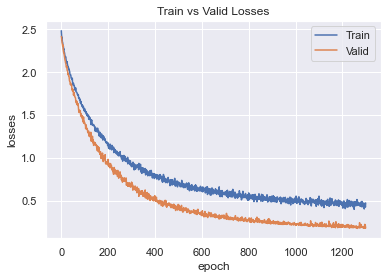

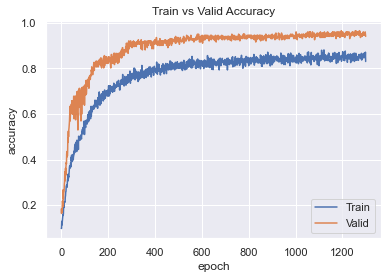

Fold 4
Reset trainable parameters of layer = Linear(in_features=512, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=11, bias=True)
In epoch 1/1300
[train metrics] loss:2.4205 accuracy:0.0767 recall:0.0795 precision:0.1209 f1:0.0676
[valid  metrics] loss:2.3829 accuracy:0.0743 recall:0.1169 precision:0.1463 f1:0.1090
================================save model_4================================
In epoch 2/1300
[train metrics] loss:2.3932 accuracy:0.0854 recall:0.0947 precision:0.1163 f1:0.0746
[valid  metrics] loss:2.3790 accuracy:0.0941 recall:0.1065 precision:0.2219 f1:0.1355
================================save model_4================================
In epoch 3/1300
[train metrics] loss:2.3805 accuracy:0.0854 recall:0.0893 pr

[train metrics] loss:1.9841 accuracy:0.3552 recall:0.3697 precision:0.4880 f1:0.3496
[valid  metrics] loss:1.9087 accuracy:0.4356 recall:0.4989 precision:0.5125 f1:0.4389
================================save model_4================================
In epoch 35/1300
[train metrics] loss:1.9862 accuracy:0.3465 recall:0.3668 precision:0.4323 f1:0.3273
[valid  metrics] loss:1.9080 accuracy:0.4554 recall:0.5210 precision:0.6886 f1:0.4587
================================save model_4================================
In epoch 36/1300
[train metrics] loss:1.9770 accuracy:0.3515 recall:0.3736 precision:0.4209 f1:0.3298
[valid  metrics] loss:1.8844 accuracy:0.4455 recall:0.4819 precision:0.6779 f1:0.4403
================================save model_4================================
In epoch 37/1300
[train metrics] loss:1.9643 accuracy:0.3688 recall:0.3925 precision:0.4786 f1:0.3533
[valid  metrics] loss:1.8691 accuracy:0.4356 recall:0.5007 precision:0.5872 f1:0.4349
================================sa

[train metrics] loss:1.6888 accuracy:0.5198 recall:0.5397 precision:0.5744 f1:0.4918
[valid  metrics] loss:1.5891 accuracy:0.6139 recall:0.6615 precision:0.7441 f1:0.5942
In epoch 71/1300
[train metrics] loss:1.7121 accuracy:0.5136 recall:0.5301 precision:0.5770 f1:0.4904
[valid  metrics] loss:1.5832 accuracy:0.5990 recall:0.6494 precision:0.6581 f1:0.5912
================================save model_4================================
In epoch 72/1300
[train metrics] loss:1.7000 accuracy:0.5198 recall:0.5362 precision:0.5717 f1:0.4894
[valid  metrics] loss:1.5764 accuracy:0.6287 recall:0.6781 precision:0.7726 f1:0.6165
================================save model_4================================
In epoch 73/1300
[train metrics] loss:1.7047 accuracy:0.4827 recall:0.5003 precision:0.5631 f1:0.4555
[valid  metrics] loss:1.5570 accuracy:0.6287 recall:0.6764 precision:0.7593 f1:0.6192
================================save model_4================================
In epoch 74/1300
[train metrics] l

[train metrics] loss:1.4863 accuracy:0.5879 recall:0.6005 precision:0.6314 f1:0.5558
[valid  metrics] loss:1.3500 accuracy:0.6782 recall:0.7276 precision:0.6983 f1:0.6480
In epoch 109/1300
[train metrics] loss:1.4764 accuracy:0.5916 recall:0.6024 precision:0.6390 f1:0.5638
[valid  metrics] loss:1.3311 accuracy:0.6683 recall:0.7139 precision:0.6798 f1:0.6327
In epoch 110/1300
[train metrics] loss:1.4676 accuracy:0.6176 recall:0.6285 precision:0.6361 f1:0.5802
[valid  metrics] loss:1.3166 accuracy:0.6683 recall:0.7175 precision:0.7719 f1:0.6366
In epoch 111/1300
[train metrics] loss:1.4760 accuracy:0.5903 recall:0.6039 precision:0.6213 f1:0.5614
[valid  metrics] loss:1.2773 accuracy:0.6782 recall:0.7289 precision:0.7447 f1:0.6612
================================save model_4================================
In epoch 112/1300
[train metrics] loss:1.4491 accuracy:0.5990 recall:0.6153 precision:0.6485 f1:0.5735
[valid  metrics] loss:1.3256 accuracy:0.6832 recall:0.7354 precision:0.7916 f1:0.6

[train metrics] loss:1.3161 accuracy:0.6324 recall:0.6406 precision:0.6664 f1:0.6046
[valid  metrics] loss:1.1385 accuracy:0.6881 recall:0.7436 precision:0.7826 f1:0.6949
In epoch 147/1300
[train metrics] loss:1.2685 accuracy:0.6696 recall:0.6816 precision:0.7107 f1:0.6482
[valid  metrics] loss:1.1291 accuracy:0.6881 recall:0.7393 precision:0.7504 f1:0.6768
In epoch 148/1300
[train metrics] loss:1.3131 accuracy:0.6349 recall:0.6453 precision:0.6757 f1:0.6073
[valid  metrics] loss:1.1330 accuracy:0.6931 recall:0.7430 precision:0.7531 f1:0.6909
In epoch 149/1300
[train metrics] loss:1.2838 accuracy:0.6535 recall:0.6683 precision:0.6937 f1:0.6295
[valid  metrics] loss:1.0867 accuracy:0.6683 recall:0.7214 precision:0.7487 f1:0.6543
================================save model_4================================
In epoch 150/1300
[train metrics] loss:1.2775 accuracy:0.6485 recall:0.6579 precision:0.6705 f1:0.6246
[valid  metrics] loss:1.1015 accuracy:0.7079 recall:0.7527 precision:0.7676 f1:0.6

[train metrics] loss:1.1588 accuracy:0.6955 recall:0.7053 precision:0.7275 f1:0.6834
[valid  metrics] loss:0.9452 accuracy:0.7624 recall:0.7995 precision:0.8144 f1:0.7750
================================save model_4================================
In epoch 187/1300
[train metrics] loss:1.1778 accuracy:0.6894 recall:0.6998 precision:0.7235 f1:0.6800
[valid  metrics] loss:0.9707 accuracy:0.7525 recall:0.7888 precision:0.8084 f1:0.7635
In epoch 188/1300
[train metrics] loss:1.1642 accuracy:0.6980 recall:0.7059 precision:0.7307 f1:0.6823
[valid  metrics] loss:1.0179 accuracy:0.7327 recall:0.7728 precision:0.7894 f1:0.7381
In epoch 189/1300
[train metrics] loss:1.1605 accuracy:0.6757 recall:0.6889 precision:0.6971 f1:0.6611
[valid  metrics] loss:0.9386 accuracy:0.7426 recall:0.7851 precision:0.8273 f1:0.7557
================================save model_4================================
In epoch 190/1300
[train metrics] loss:1.1552 accuracy:0.6869 recall:0.6997 precision:0.7157 f1:0.6770
[vali

[train metrics] loss:1.0579 accuracy:0.7339 recall:0.7426 precision:0.7448 f1:0.7256
[valid  metrics] loss:0.8662 accuracy:0.7723 recall:0.8002 precision:0.8129 f1:0.7764
In epoch 227/1300
[train metrics] loss:1.0580 accuracy:0.7389 recall:0.7505 precision:0.7487 f1:0.7324
[valid  metrics] loss:0.8554 accuracy:0.7871 recall:0.8196 precision:0.8388 f1:0.7929
In epoch 228/1300
[train metrics] loss:1.0553 accuracy:0.7463 recall:0.7537 precision:0.7651 f1:0.7361
[valid  metrics] loss:0.8802 accuracy:0.7723 recall:0.8052 precision:0.8339 f1:0.7806
In epoch 229/1300
[train metrics] loss:1.0322 accuracy:0.7351 recall:0.7440 precision:0.7535 f1:0.7313
[valid  metrics] loss:0.8467 accuracy:0.7822 recall:0.8159 precision:0.8399 f1:0.7872
================================save model_4================================
In epoch 230/1300
[train metrics] loss:1.0566 accuracy:0.7228 recall:0.7297 precision:0.7414 f1:0.7131
[valid  metrics] loss:0.8488 accuracy:0.7970 recall:0.8331 precision:0.8497 f1:0.8

[train metrics] loss:0.9462 accuracy:0.7698 recall:0.7782 precision:0.7834 f1:0.7689
[valid  metrics] loss:0.7897 accuracy:0.8267 recall:0.8557 precision:0.8656 f1:0.8291
In epoch 267/1300
[train metrics] loss:0.9942 accuracy:0.7339 recall:0.7404 precision:0.7421 f1:0.7265
[valid  metrics] loss:0.8036 accuracy:0.8267 recall:0.8557 precision:0.8637 f1:0.8292
In epoch 268/1300
[train metrics] loss:0.9409 accuracy:0.7809 recall:0.7858 precision:0.7907 f1:0.7751
[valid  metrics] loss:0.7863 accuracy:0.8317 recall:0.8487 precision:0.8576 f1:0.8366
In epoch 269/1300
[train metrics] loss:0.9606 accuracy:0.7463 recall:0.7548 precision:0.7503 f1:0.7436
[valid  metrics] loss:0.7400 accuracy:0.8317 recall:0.8587 precision:0.8594 f1:0.8352
In epoch 270/1300
[train metrics] loss:0.9331 accuracy:0.7809 recall:0.7897 precision:0.7921 f1:0.7787
[valid  metrics] loss:0.7980 accuracy:0.8366 recall:0.8608 precision:0.8663 f1:0.8384
In epoch 271/1300
[train metrics] loss:0.9829 accuracy:0.7475 recall:0.75

[train metrics] loss:0.8946 accuracy:0.7859 recall:0.7941 precision:0.7883 f1:0.7797
[valid  metrics] loss:0.6929 accuracy:0.8267 recall:0.8523 precision:0.8462 f1:0.8288
In epoch 309/1300
[train metrics] loss:0.8855 accuracy:0.7871 recall:0.7921 precision:0.7981 f1:0.7883
[valid  metrics] loss:0.6720 accuracy:0.8713 recall:0.8801 precision:0.8758 f1:0.8680
In epoch 310/1300
[train metrics] loss:0.9242 accuracy:0.7525 recall:0.7604 precision:0.7655 f1:0.7515
[valid  metrics] loss:0.6841 accuracy:0.8713 recall:0.8825 precision:0.8818 f1:0.8725
In epoch 311/1300
[train metrics] loss:0.9369 accuracy:0.7562 recall:0.7620 precision:0.7630 f1:0.7508
[valid  metrics] loss:0.6592 accuracy:0.8663 recall:0.8823 precision:0.8863 f1:0.8725
================================save model_4================================
In epoch 312/1300
[train metrics] loss:0.8614 accuracy:0.7785 recall:0.7842 precision:0.7810 f1:0.7741
[valid  metrics] loss:0.7062 accuracy:0.8861 recall:0.8927 precision:0.8869 f1:0.8

[train metrics] loss:0.8563 accuracy:0.7859 recall:0.7934 precision:0.7796 f1:0.7793
[valid  metrics] loss:0.6309 accuracy:0.8713 recall:0.8860 precision:0.8865 f1:0.8807
In epoch 350/1300
[train metrics] loss:0.8616 accuracy:0.7834 recall:0.7888 precision:0.7924 f1:0.7849
[valid  metrics] loss:0.6241 accuracy:0.8861 recall:0.8980 precision:0.8980 f1:0.8894
In epoch 351/1300
[train metrics] loss:0.8187 accuracy:0.7958 recall:0.8000 precision:0.8001 f1:0.7948
[valid  metrics] loss:0.6374 accuracy:0.8762 recall:0.8856 precision:0.8857 f1:0.8779
In epoch 352/1300
[train metrics] loss:0.8280 accuracy:0.7809 recall:0.7899 precision:0.7879 f1:0.7833
[valid  metrics] loss:0.5988 accuracy:0.8762 recall:0.8824 precision:0.8733 f1:0.8710
In epoch 353/1300
[train metrics] loss:0.8346 accuracy:0.7735 recall:0.7786 precision:0.7799 f1:0.7720
[valid  metrics] loss:0.6203 accuracy:0.8812 recall:0.8940 precision:0.8934 f1:0.8846
In epoch 354/1300
[train metrics] loss:0.8332 accuracy:0.7809 recall:0.78

[train metrics] loss:0.7962 accuracy:0.7834 recall:0.7870 precision:0.7931 f1:0.7839
[valid  metrics] loss:0.5413 accuracy:0.8762 recall:0.8887 precision:0.8862 f1:0.8842
================================save model_4================================
In epoch 391/1300
[train metrics] loss:0.8011 accuracy:0.7735 recall:0.7778 precision:0.7757 f1:0.7711
[valid  metrics] loss:0.5462 accuracy:0.8713 recall:0.8804 precision:0.8870 f1:0.8797
In epoch 392/1300
[train metrics] loss:0.7847 accuracy:0.7896 recall:0.7988 precision:0.7948 f1:0.7905
[valid  metrics] loss:0.5462 accuracy:0.8861 recall:0.8973 precision:0.8927 f1:0.8873
In epoch 393/1300
[train metrics] loss:0.7335 accuracy:0.8403 recall:0.8456 precision:0.8400 f1:0.8404
[valid  metrics] loss:0.5635 accuracy:0.8960 recall:0.9057 precision:0.8983 f1:0.8979
In epoch 394/1300
[train metrics] loss:0.7601 accuracy:0.7995 recall:0.8064 precision:0.7983 f1:0.7971
[valid  metrics] loss:0.5542 accuracy:0.8762 recall:0.8844 precision:0.8895 f1:0.8

[train metrics] loss:0.7327 accuracy:0.8069 recall:0.8117 precision:0.8134 f1:0.8080
[valid  metrics] loss:0.5566 accuracy:0.8812 recall:0.8900 precision:0.8897 f1:0.8871
In epoch 432/1300
[train metrics] loss:0.7304 accuracy:0.8131 recall:0.8192 precision:0.8129 f1:0.8123
[valid  metrics] loss:0.5258 accuracy:0.8960 recall:0.9075 precision:0.9021 f1:0.9017
In epoch 433/1300
[train metrics] loss:0.7437 accuracy:0.7946 recall:0.8020 precision:0.7963 f1:0.7952
[valid  metrics] loss:0.4897 accuracy:0.8911 recall:0.9010 precision:0.9013 f1:0.8974
================================save model_4================================
In epoch 434/1300
[train metrics] loss:0.7123 accuracy:0.8243 recall:0.8311 precision:0.8319 f1:0.8276
[valid  metrics] loss:0.5697 accuracy:0.8861 recall:0.8940 precision:0.8952 f1:0.8918
In epoch 435/1300
[train metrics] loss:0.7287 accuracy:0.8106 recall:0.8183 precision:0.8173 f1:0.8140
[valid  metrics] loss:0.5160 accuracy:0.8713 recall:0.8824 precision:0.8735 f1:0.8

[train metrics] loss:0.6970 accuracy:0.8218 recall:0.8273 precision:0.8230 f1:0.8216
[valid  metrics] loss:0.4620 accuracy:0.8861 recall:0.8966 precision:0.8927 f1:0.8918
================================save model_4================================
In epoch 473/1300
[train metrics] loss:0.6947 accuracy:0.8156 recall:0.8204 precision:0.8207 f1:0.8169
[valid  metrics] loss:0.4730 accuracy:0.8861 recall:0.8944 precision:0.8958 f1:0.8917
In epoch 474/1300
[train metrics] loss:0.7195 accuracy:0.8082 recall:0.8138 precision:0.8110 f1:0.8091
[valid  metrics] loss:0.4671 accuracy:0.8861 recall:0.8991 precision:0.8949 f1:0.8931
In epoch 475/1300
[train metrics] loss:0.6960 accuracy:0.8168 recall:0.8204 precision:0.8225 f1:0.8178
[valid  metrics] loss:0.5089 accuracy:0.8960 recall:0.9057 precision:0.9001 f1:0.8976
In epoch 476/1300
[train metrics] loss:0.7396 accuracy:0.7946 recall:0.8029 precision:0.8036 f1:0.7981
[valid  metrics] loss:0.4749 accuracy:0.8812 recall:0.8891 precision:0.8881 f1:0.8

[train metrics] loss:0.6298 accuracy:0.8317 recall:0.8367 precision:0.8404 f1:0.8357
[valid  metrics] loss:0.4422 accuracy:0.8911 recall:0.8974 precision:0.9008 f1:0.8971
In epoch 514/1300
[train metrics] loss:0.6462 accuracy:0.8205 recall:0.8265 precision:0.8204 f1:0.8210
[valid  metrics] loss:0.4709 accuracy:0.8861 recall:0.8966 precision:0.8940 f1:0.8917
In epoch 515/1300
[train metrics] loss:0.6994 accuracy:0.7970 recall:0.8078 precision:0.8036 f1:0.8035
[valid  metrics] loss:0.4364 accuracy:0.8861 recall:0.8944 precision:0.8950 f1:0.8918
In epoch 516/1300
[train metrics] loss:0.7074 accuracy:0.8205 recall:0.8256 precision:0.8190 f1:0.8195
[valid  metrics] loss:0.4591 accuracy:0.8762 recall:0.8918 precision:0.8927 f1:0.8871
In epoch 517/1300
[train metrics] loss:0.6859 accuracy:0.8193 recall:0.8231 precision:0.8250 f1:0.8206
[valid  metrics] loss:0.4370 accuracy:0.9010 recall:0.9114 precision:0.9125 f1:0.9086
In epoch 518/1300
[train metrics] loss:0.6729 accuracy:0.8119 recall:0.81

[train metrics] loss:0.6976 accuracy:0.7970 recall:0.8014 precision:0.8047 f1:0.7997
[valid  metrics] loss:0.4321 accuracy:0.9010 recall:0.9136 precision:0.9131 f1:0.9099
In epoch 556/1300
[train metrics] loss:0.6690 accuracy:0.8119 recall:0.8177 precision:0.8152 f1:0.8135
[valid  metrics] loss:0.4103 accuracy:0.8960 recall:0.9036 precision:0.9042 f1:0.9000
In epoch 557/1300
[train metrics] loss:0.6485 accuracy:0.8007 recall:0.8057 precision:0.8020 f1:0.7998
[valid  metrics] loss:0.4085 accuracy:0.9010 recall:0.9044 precision:0.9049 f1:0.9025
In epoch 558/1300
[train metrics] loss:0.6516 accuracy:0.8243 recall:0.8301 precision:0.8279 f1:0.8265
[valid  metrics] loss:0.4262 accuracy:0.8911 recall:0.9011 precision:0.9060 f1:0.8999
In epoch 559/1300
[train metrics] loss:0.6269 accuracy:0.8280 recall:0.8332 precision:0.8293 f1:0.8276
[valid  metrics] loss:0.4119 accuracy:0.8713 recall:0.8834 precision:0.8857 f1:0.8800
In epoch 560/1300
[train metrics] loss:0.6276 accuracy:0.8292 recall:0.83

[train metrics] loss:0.6587 accuracy:0.8144 recall:0.8226 precision:0.8133 f1:0.8154
[valid  metrics] loss:0.4190 accuracy:0.8960 recall:0.8998 precision:0.9061 f1:0.9000
In epoch 598/1300
[train metrics] loss:0.6306 accuracy:0.8168 recall:0.8214 precision:0.8204 f1:0.8187
[valid  metrics] loss:0.3962 accuracy:0.9059 recall:0.9119 precision:0.9144 f1:0.9114
In epoch 599/1300
[train metrics] loss:0.6378 accuracy:0.8403 recall:0.8439 precision:0.8484 f1:0.8445
[valid  metrics] loss:0.4019 accuracy:0.9010 recall:0.9103 precision:0.9142 f1:0.9083
In epoch 600/1300
[train metrics] loss:0.6172 accuracy:0.8131 recall:0.8179 precision:0.8208 f1:0.8166
[valid  metrics] loss:0.4316 accuracy:0.9010 recall:0.9079 precision:0.9114 f1:0.9061
In epoch 601/1300
[train metrics] loss:0.6045 accuracy:0.8292 recall:0.8360 precision:0.8325 f1:0.8326
[valid  metrics] loss:0.4232 accuracy:0.8960 recall:0.9021 precision:0.9103 f1:0.9024
In epoch 602/1300
[train metrics] loss:0.6118 accuracy:0.8329 recall:0.83

[train metrics] loss:0.6051 accuracy:0.8342 recall:0.8368 precision:0.8379 f1:0.8353
[valid  metrics] loss:0.3732 accuracy:0.8861 recall:0.8938 precision:0.8927 f1:0.8902
In epoch 641/1300
[train metrics] loss:0.6196 accuracy:0.8391 recall:0.8420 precision:0.8421 f1:0.8409
[valid  metrics] loss:0.4335 accuracy:0.9059 recall:0.9164 precision:0.9134 f1:0.9124
In epoch 642/1300
[train metrics] loss:0.6206 accuracy:0.8094 recall:0.8158 precision:0.8128 f1:0.8119
[valid  metrics] loss:0.3630 accuracy:0.9059 recall:0.9164 precision:0.9146 f1:0.9121
In epoch 643/1300
[train metrics] loss:0.5981 accuracy:0.8354 recall:0.8375 precision:0.8358 f1:0.8343
[valid  metrics] loss:0.3770 accuracy:0.9059 recall:0.9121 precision:0.9155 f1:0.9105
In epoch 644/1300
[train metrics] loss:0.5852 accuracy:0.8379 recall:0.8434 precision:0.8398 f1:0.8395
[valid  metrics] loss:0.3847 accuracy:0.8960 recall:0.9060 precision:0.9031 f1:0.9003
In epoch 645/1300
[train metrics] loss:0.5820 accuracy:0.8403 recall:0.84

[train metrics] loss:0.5844 accuracy:0.8255 recall:0.8328 precision:0.8289 f1:0.8275
[valid  metrics] loss:0.3593 accuracy:0.9059 recall:0.9146 precision:0.9166 f1:0.9123
In epoch 684/1300
[train metrics] loss:0.5764 accuracy:0.8255 recall:0.8300 precision:0.8272 f1:0.8260
[valid  metrics] loss:0.3602 accuracy:0.9208 recall:0.9244 precision:0.9257 f1:0.9237
In epoch 685/1300
[train metrics] loss:0.6095 accuracy:0.8131 recall:0.8218 precision:0.8147 f1:0.8174
[valid  metrics] loss:0.3634 accuracy:0.9109 recall:0.9216 precision:0.9229 f1:0.9177
In epoch 686/1300
[train metrics] loss:0.5614 accuracy:0.8255 recall:0.8311 precision:0.8280 f1:0.8270
[valid  metrics] loss:0.3551 accuracy:0.8960 recall:0.9047 precision:0.8984 f1:0.8976
In epoch 687/1300
[train metrics] loss:0.5583 accuracy:0.8403 recall:0.8452 precision:0.8427 f1:0.8403
[valid  metrics] loss:0.3691 accuracy:0.9059 recall:0.9146 precision:0.9166 f1:0.9123
In epoch 688/1300
[train metrics] loss:0.5962 accuracy:0.8292 recall:0.83

[train metrics] loss:0.5632 accuracy:0.8168 recall:0.8225 precision:0.8192 f1:0.8187
[valid  metrics] loss:0.3560 accuracy:0.9109 recall:0.9177 precision:0.9186 f1:0.9152
In epoch 727/1300
[train metrics] loss:0.5485 accuracy:0.8280 recall:0.8346 precision:0.8333 f1:0.8318
[valid  metrics] loss:0.3814 accuracy:0.9010 recall:0.9068 precision:0.9085 f1:0.9040
In epoch 728/1300
[train metrics] loss:0.5882 accuracy:0.8193 recall:0.8223 precision:0.8238 f1:0.8205
[valid  metrics] loss:0.3286 accuracy:0.9109 recall:0.9155 precision:0.9096 f1:0.9107
================================save model_4================================
In epoch 729/1300
[train metrics] loss:0.5534 accuracy:0.8391 recall:0.8455 precision:0.8441 f1:0.8424
[valid  metrics] loss:0.3763 accuracy:0.9059 recall:0.9094 precision:0.9057 f1:0.9055
In epoch 730/1300
[train metrics] loss:0.5665 accuracy:0.8317 recall:0.8355 precision:0.8381 f1:0.8353
[valid  metrics] loss:0.3671 accuracy:0.8564 recall:0.8717 precision:0.8767 f1:0.8

[train metrics] loss:0.5836 accuracy:0.8205 recall:0.8260 precision:0.8229 f1:0.8221
[valid  metrics] loss:0.3401 accuracy:0.9010 recall:0.9127 precision:0.9100 f1:0.9071
In epoch 769/1300
[train metrics] loss:0.5072 accuracy:0.8515 recall:0.8581 precision:0.8523 f1:0.8541
[valid  metrics] loss:0.3455 accuracy:0.8960 recall:0.9033 precision:0.9007 f1:0.8986
In epoch 770/1300
[train metrics] loss:0.5217 accuracy:0.8428 recall:0.8487 precision:0.8472 f1:0.8459
[valid  metrics] loss:0.3535 accuracy:0.8861 recall:0.8957 precision:0.8962 f1:0.8905
In epoch 771/1300
[train metrics] loss:0.5944 accuracy:0.8230 recall:0.8305 precision:0.8264 f1:0.8258
[valid  metrics] loss:0.3175 accuracy:0.9158 recall:0.9170 precision:0.9153 f1:0.9151
In epoch 772/1300
[train metrics] loss:0.5510 accuracy:0.8366 recall:0.8419 precision:0.8365 f1:0.8374
[valid  metrics] loss:0.3279 accuracy:0.9109 recall:0.9155 precision:0.9096 f1:0.9107
In epoch 773/1300
[train metrics] loss:0.5800 accuracy:0.8342 recall:0.83

[train metrics] loss:0.5327 accuracy:0.8441 recall:0.8466 precision:0.8492 f1:0.8465
[valid  metrics] loss:0.3282 accuracy:0.8960 recall:0.9029 precision:0.9000 f1:0.8981
In epoch 812/1300
[train metrics] loss:0.5845 accuracy:0.8094 recall:0.8137 precision:0.8145 f1:0.8126
[valid  metrics] loss:0.3751 accuracy:0.8960 recall:0.9067 precision:0.9042 f1:0.9000
In epoch 813/1300
[train metrics] loss:0.5427 accuracy:0.8342 recall:0.8372 precision:0.8435 f1:0.8378
[valid  metrics] loss:0.3338 accuracy:0.8960 recall:0.9005 precision:0.9020 f1:0.8991
In epoch 814/1300
[train metrics] loss:0.5383 accuracy:0.8366 recall:0.8442 precision:0.8419 f1:0.8409
[valid  metrics] loss:0.3387 accuracy:0.9109 recall:0.9195 precision:0.9153 f1:0.9143
In epoch 815/1300
[train metrics] loss:0.5534 accuracy:0.8280 recall:0.8307 precision:0.8341 f1:0.8295
[valid  metrics] loss:0.3346 accuracy:0.9010 recall:0.9119 precision:0.9062 f1:0.9045
In epoch 816/1300
[train metrics] loss:0.5345 accuracy:0.8304 recall:0.83

[train metrics] loss:0.5284 accuracy:0.8441 recall:0.8476 precision:0.8532 f1:0.8489
[valid  metrics] loss:0.3244 accuracy:0.9059 recall:0.9120 precision:0.9059 f1:0.9074
In epoch 853/1300
[train metrics] loss:0.5400 accuracy:0.8391 recall:0.8439 precision:0.8466 f1:0.8442
[valid  metrics] loss:0.3082 accuracy:0.9010 recall:0.9064 precision:0.9059 f1:0.9033
In epoch 854/1300
[train metrics] loss:0.5721 accuracy:0.8218 recall:0.8272 precision:0.8215 f1:0.8228
[valid  metrics] loss:0.2987 accuracy:0.9109 recall:0.9155 precision:0.9096 f1:0.9107
================================save model_4================================
In epoch 855/1300
[train metrics] loss:0.5127 accuracy:0.8478 recall:0.8525 precision:0.8528 f1:0.8511
[valid  metrics] loss:0.3052 accuracy:0.9059 recall:0.9162 precision:0.9106 f1:0.9085
In epoch 856/1300
[train metrics] loss:0.5268 accuracy:0.8379 recall:0.8453 precision:0.8415 f1:0.8414
[valid  metrics] loss:0.3327 accuracy:0.9010 recall:0.9127 precision:0.9081 f1:0.9

[train metrics] loss:0.5124 accuracy:0.8428 recall:0.8443 precision:0.8475 f1:0.8440
[valid  metrics] loss:0.3190 accuracy:0.8812 recall:0.8953 precision:0.8930 f1:0.8919
In epoch 895/1300
[train metrics] loss:0.4952 accuracy:0.8738 recall:0.8795 precision:0.8740 f1:0.8747
[valid  metrics] loss:0.2973 accuracy:0.8911 recall:0.9022 precision:0.8999 f1:0.8983
In epoch 896/1300
[train metrics] loss:0.5370 accuracy:0.8205 recall:0.8290 precision:0.8249 f1:0.8253
[valid  metrics] loss:0.2927 accuracy:0.9010 recall:0.9096 precision:0.9095 f1:0.9085
================================save model_4================================
In epoch 897/1300
[train metrics] loss:0.4819 accuracy:0.8577 recall:0.8616 precision:0.8614 f1:0.8598
[valid  metrics] loss:0.3240 accuracy:0.8911 recall:0.9057 precision:0.9048 f1:0.9018
In epoch 898/1300
[train metrics] loss:0.5170 accuracy:0.8379 recall:0.8417 precision:0.8471 f1:0.8416
[valid  metrics] loss:0.3128 accuracy:0.9059 recall:0.9133 precision:0.9101 f1:0.9

[train metrics] loss:0.5047 accuracy:0.8304 recall:0.8348 precision:0.8348 f1:0.8318
[valid  metrics] loss:0.2902 accuracy:0.9059 recall:0.9120 precision:0.9089 f1:0.9094
In epoch 938/1300
[train metrics] loss:0.5581 accuracy:0.8193 recall:0.8242 precision:0.8213 f1:0.8216
[valid  metrics] loss:0.3063 accuracy:0.8911 recall:0.8970 precision:0.9015 f1:0.8975
In epoch 939/1300
[train metrics] loss:0.4940 accuracy:0.8552 recall:0.8569 precision:0.8571 f1:0.8549
[valid  metrics] loss:0.2883 accuracy:0.9059 recall:0.9136 precision:0.9101 f1:0.9086
In epoch 940/1300
[train metrics] loss:0.5047 accuracy:0.8626 recall:0.8662 precision:0.8681 f1:0.8638
[valid  metrics] loss:0.2884 accuracy:0.9010 recall:0.9052 precision:0.9028 f1:0.9029
In epoch 941/1300
[train metrics] loss:0.5056 accuracy:0.8552 recall:0.8621 precision:0.8605 f1:0.8600
[valid  metrics] loss:0.2914 accuracy:0.8861 recall:0.8985 precision:0.8960 f1:0.8955
In epoch 942/1300
[train metrics] loss:0.5302 accuracy:0.8391 recall:0.84

[train metrics] loss:0.5138 accuracy:0.8304 recall:0.8365 precision:0.8314 f1:0.8318
[valid  metrics] loss:0.2938 accuracy:0.9059 recall:0.9094 precision:0.9138 f1:0.9079
In epoch 981/1300
[train metrics] loss:0.4613 accuracy:0.8552 recall:0.8568 precision:0.8563 f1:0.8556
[valid  metrics] loss:0.3269 accuracy:0.9059 recall:0.9074 precision:0.9042 f1:0.9047
In epoch 982/1300
[train metrics] loss:0.4986 accuracy:0.8441 recall:0.8445 precision:0.8479 f1:0.8452
[valid  metrics] loss:0.2914 accuracy:0.9109 recall:0.9167 precision:0.9144 f1:0.9130
In epoch 983/1300
[train metrics] loss:0.4986 accuracy:0.8354 recall:0.8404 precision:0.8406 f1:0.8382
[valid  metrics] loss:0.2870 accuracy:0.9010 recall:0.9047 precision:0.9047 f1:0.9043
In epoch 984/1300
[train metrics] loss:0.4715 accuracy:0.8478 recall:0.8546 precision:0.8534 f1:0.8523
[valid  metrics] loss:0.3209 accuracy:0.8960 recall:0.9020 precision:0.8996 f1:0.8993
In epoch 985/1300
[train metrics] loss:0.5149 accuracy:0.8193 recall:0.82

[train metrics] loss:0.5104 accuracy:0.8391 recall:0.8432 precision:0.8476 f1:0.8435
[valid  metrics] loss:0.2897 accuracy:0.9059 recall:0.9122 precision:0.9087 f1:0.9092
In epoch 1024/1300
[train metrics] loss:0.4834 accuracy:0.8453 recall:0.8495 precision:0.8459 f1:0.8459
[valid  metrics] loss:0.2773 accuracy:0.8911 recall:0.9026 precision:0.9034 f1:0.9019
In epoch 1025/1300
[train metrics] loss:0.5238 accuracy:0.8478 recall:0.8513 precision:0.8500 f1:0.8496
[valid  metrics] loss:0.2610 accuracy:0.9158 recall:0.9198 precision:0.9195 f1:0.9191
================================save model_4================================
In epoch 1026/1300
[train metrics] loss:0.4697 accuracy:0.8403 recall:0.8439 precision:0.8436 f1:0.8426
[valid  metrics] loss:0.2820 accuracy:0.9059 recall:0.9125 precision:0.9078 f1:0.9066
In epoch 1027/1300
[train metrics] loss:0.5248 accuracy:0.8243 recall:0.8322 precision:0.8302 f1:0.8294
[valid  metrics] loss:0.2803 accuracy:0.9059 recall:0.9160 precision:0.9105 f1

[train metrics] loss:0.4899 accuracy:0.8490 recall:0.8503 precision:0.8526 f1:0.8500
[valid  metrics] loss:0.2732 accuracy:0.9208 recall:0.9244 precision:0.9234 f1:0.9224
In epoch 1067/1300
[train metrics] loss:0.4836 accuracy:0.8490 recall:0.8558 precision:0.8460 f1:0.8496
[valid  metrics] loss:0.2712 accuracy:0.9059 recall:0.9091 precision:0.9120 f1:0.9103
In epoch 1068/1300
[train metrics] loss:0.4469 accuracy:0.8453 recall:0.8498 precision:0.8511 f1:0.8486
[valid  metrics] loss:0.2729 accuracy:0.9059 recall:0.9087 precision:0.9064 f1:0.9061
In epoch 1069/1300
[train metrics] loss:0.5048 accuracy:0.8366 recall:0.8402 precision:0.8423 f1:0.8394
[valid  metrics] loss:0.2834 accuracy:0.9010 recall:0.9087 precision:0.9023 f1:0.9040
In epoch 1070/1300
[train metrics] loss:0.5067 accuracy:0.8416 recall:0.8470 precision:0.8446 f1:0.8442
[valid  metrics] loss:0.2841 accuracy:0.9158 recall:0.9211 precision:0.9170 f1:0.9163
In epoch 1071/1300
[train metrics] loss:0.5000 accuracy:0.8403 recall

[train metrics] loss:0.4768 accuracy:0.8292 recall:0.8328 precision:0.8307 f1:0.8310
[valid  metrics] loss:0.2659 accuracy:0.9109 recall:0.9166 precision:0.9119 f1:0.9134
In epoch 1111/1300
[train metrics] loss:0.4610 accuracy:0.8540 recall:0.8578 precision:0.8603 f1:0.8578
[valid  metrics] loss:0.2867 accuracy:0.9109 recall:0.9157 precision:0.9152 f1:0.9136
In epoch 1112/1300
[train metrics] loss:0.4523 accuracy:0.8614 recall:0.8656 precision:0.8676 f1:0.8653
[valid  metrics] loss:0.2842 accuracy:0.9109 recall:0.9157 precision:0.9129 f1:0.9122
In epoch 1113/1300
[train metrics] loss:0.4672 accuracy:0.8564 recall:0.8616 precision:0.8642 f1:0.8618
[valid  metrics] loss:0.3006 accuracy:0.9208 recall:0.9196 precision:0.9214 f1:0.9198
In epoch 1114/1300
[train metrics] loss:0.4716 accuracy:0.8428 recall:0.8493 precision:0.8465 f1:0.8468
[valid  metrics] loss:0.2927 accuracy:0.9158 recall:0.9201 precision:0.9202 f1:0.9183
In epoch 1115/1300
[train metrics] loss:0.4848 accuracy:0.8329 recall

[train metrics] loss:0.4616 accuracy:0.8490 recall:0.8533 precision:0.8524 f1:0.8516
[valid  metrics] loss:0.2699 accuracy:0.9208 recall:0.9271 precision:0.9223 f1:0.9221
In epoch 1153/1300
[train metrics] loss:0.4555 accuracy:0.8626 recall:0.8682 precision:0.8632 f1:0.8650
[valid  metrics] loss:0.2883 accuracy:0.9109 recall:0.9168 precision:0.9128 f1:0.9125
In epoch 1154/1300
[train metrics] loss:0.4590 accuracy:0.8577 recall:0.8594 precision:0.8639 f1:0.8604
[valid  metrics] loss:0.2585 accuracy:0.9208 recall:0.9271 precision:0.9256 f1:0.9242
In epoch 1155/1300
[train metrics] loss:0.4631 accuracy:0.8441 recall:0.8500 precision:0.8495 f1:0.8478
[valid  metrics] loss:0.2674 accuracy:0.9208 recall:0.9271 precision:0.9256 f1:0.9242
In epoch 1156/1300
[train metrics] loss:0.5125 accuracy:0.8354 recall:0.8399 precision:0.8461 f1:0.8410
[valid  metrics] loss:0.2694 accuracy:0.9208 recall:0.9196 precision:0.9214 f1:0.9198
In epoch 1157/1300
[train metrics] loss:0.4585 accuracy:0.8490 recall

[train metrics] loss:0.4978 accuracy:0.8354 recall:0.8419 precision:0.8385 f1:0.8386
[valid  metrics] loss:0.2566 accuracy:0.9109 recall:0.9155 precision:0.9123 f1:0.9130
In epoch 1196/1300
[train metrics] loss:0.4403 accuracy:0.8552 recall:0.8577 precision:0.8633 f1:0.8582
[valid  metrics] loss:0.2614 accuracy:0.9257 recall:0.9314 precision:0.9288 f1:0.9284
In epoch 1197/1300
[train metrics] loss:0.4529 accuracy:0.8515 recall:0.8565 precision:0.8568 f1:0.8558
[valid  metrics] loss:0.2523 accuracy:0.9158 recall:0.9201 precision:0.9202 f1:0.9183
In epoch 1198/1300
[train metrics] loss:0.4660 accuracy:0.8663 recall:0.8699 precision:0.8715 f1:0.8688
[valid  metrics] loss:0.2781 accuracy:0.9158 recall:0.9227 precision:0.9183 f1:0.9182
In epoch 1199/1300
[train metrics] loss:0.4993 accuracy:0.8416 recall:0.8468 precision:0.8457 f1:0.8445
[valid  metrics] loss:0.2658 accuracy:0.9257 recall:0.9266 precision:0.9268 f1:0.9261
In epoch 1200/1300
[train metrics] loss:0.4489 accuracy:0.8552 recall

[train metrics] loss:0.4385 accuracy:0.8540 recall:0.8593 precision:0.8568 f1:0.8563
[valid  metrics] loss:0.2513 accuracy:0.9158 recall:0.9163 precision:0.9172 f1:0.9159
In epoch 1240/1300
[train metrics] loss:0.5321 accuracy:0.8379 recall:0.8430 precision:0.8422 f1:0.8405
[valid  metrics] loss:0.2560 accuracy:0.9158 recall:0.9225 precision:0.9183 f1:0.9184
In epoch 1241/1300
[train metrics] loss:0.4473 accuracy:0.8639 recall:0.8697 precision:0.8639 f1:0.8655
[valid  metrics] loss:0.2640 accuracy:0.9109 recall:0.9120 precision:0.9099 f1:0.9098
In epoch 1242/1300
[train metrics] loss:0.4416 accuracy:0.8564 recall:0.8619 precision:0.8648 f1:0.8622
[valid  metrics] loss:0.2603 accuracy:0.9059 recall:0.9109 precision:0.9117 f1:0.9103
In epoch 1243/1300
[train metrics] loss:0.4921 accuracy:0.8304 recall:0.8362 precision:0.8352 f1:0.8340
[valid  metrics] loss:0.2612 accuracy:0.9208 recall:0.9233 precision:0.9229 f1:0.9223
In epoch 1244/1300
[train metrics] loss:0.4632 accuracy:0.8713 recall

[train metrics] loss:0.4597 accuracy:0.8676 recall:0.8740 precision:0.8728 f1:0.8721
[valid  metrics] loss:0.2434 accuracy:0.9257 recall:0.9228 precision:0.9234 f1:0.9220
In epoch 1283/1300
[train metrics] loss:0.4291 accuracy:0.8589 recall:0.8649 precision:0.8631 f1:0.8626
[valid  metrics] loss:0.2685 accuracy:0.9158 recall:0.9225 precision:0.9183 f1:0.9184
In epoch 1284/1300
[train metrics] loss:0.4791 accuracy:0.8453 recall:0.8490 precision:0.8548 f1:0.8500
[valid  metrics] loss:0.3035 accuracy:0.9208 recall:0.9220 precision:0.9236 f1:0.9218
In epoch 1285/1300
[train metrics] loss:0.4439 accuracy:0.8601 recall:0.8650 precision:0.8634 f1:0.8626
[valid  metrics] loss:0.2618 accuracy:0.9059 recall:0.9087 precision:0.9064 f1:0.9061
In epoch 1286/1300
[train metrics] loss:0.4321 accuracy:0.8614 recall:0.8653 precision:0.8669 f1:0.8646
[valid  metrics] loss:0.2385 accuracy:0.9158 recall:0.9161 precision:0.9177 f1:0.9165
================================save model_4=========================

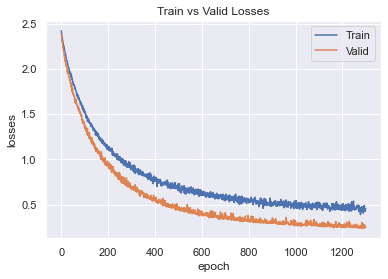

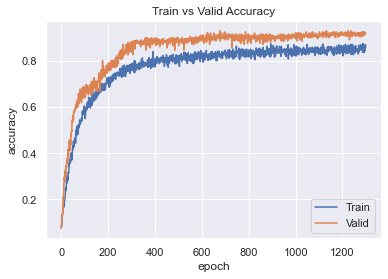

Fold 5
Reset trainable parameters of layer = Linear(in_features=512, out_features=128, bias=True)
Reset trainable parameters of layer = BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=128, out_features=32, bias=True)
Reset trainable parameters of layer = Linear(in_features=32, out_features=11, bias=True)
In epoch 1/1300
[train metrics] loss:2.4302 accuracy:0.0854 recall:0.1145 precision:0.0824 f1:0.0652
[valid  metrics] loss:2.4069 accuracy:0.1139 recall:0.1152 precision:0.0835 f1:0.0645
================================save model_5================================
In epoch 2/1300
[train metrics] loss:2.4003 accuracy:0.0965 recall:0.1163 precision:0.1318 f1:0.0756
[valid  metrics] loss:2.3434 accuracy:0.1485 recall:0.1510 precision:0.1280 f1:0.0938
================================save model_5================================
In epoch 3/1300
[train metrics] loss:2.3664 accuracy:0.1040 recall:0.1246 pr

[train metrics] loss:1.9328 accuracy:0.3589 recall:0.3735 precision:0.4135 f1:0.3343
[valid  metrics] loss:1.8429 accuracy:0.5446 recall:0.5435 precision:0.6574 f1:0.5279
In epoch 35/1300
[train metrics] loss:1.9089 accuracy:0.3725 recall:0.3890 precision:0.4699 f1:0.3525
[valid  metrics] loss:1.8260 accuracy:0.5495 recall:0.5392 precision:0.5750 f1:0.5198
================================save model_5================================
In epoch 36/1300
[train metrics] loss:1.9214 accuracy:0.3589 recall:0.3731 precision:0.4267 f1:0.3310
[valid  metrics] loss:1.8068 accuracy:0.5693 recall:0.5670 precision:0.6560 f1:0.5608
================================save model_5================================
In epoch 37/1300
[train metrics] loss:1.8815 accuracy:0.3874 recall:0.4140 precision:0.4736 f1:0.3643
[valid  metrics] loss:1.7955 accuracy:0.5396 recall:0.5368 precision:0.6696 f1:0.5090
================================save model_5================================
In epoch 38/1300
[train metrics] l

[train metrics] loss:1.6293 accuracy:0.5025 recall:0.5204 precision:0.5385 f1:0.4719
[valid  metrics] loss:1.4710 accuracy:0.6287 recall:0.6174 precision:0.7373 f1:0.6097
In epoch 70/1300
[train metrics] loss:1.6136 accuracy:0.5260 recall:0.5442 precision:0.5850 f1:0.5079
[valid  metrics] loss:1.4475 accuracy:0.6782 recall:0.6701 precision:0.7853 f1:0.6385
================================save model_5================================
In epoch 71/1300
[train metrics] loss:1.5989 accuracy:0.5285 recall:0.5431 precision:0.5724 f1:0.4950
[valid  metrics] loss:1.4116 accuracy:0.6683 recall:0.6601 precision:0.7620 f1:0.6465
================================save model_5================================
In epoch 72/1300
[train metrics] loss:1.5952 accuracy:0.5173 recall:0.5268 precision:0.5690 f1:0.4901
[valid  metrics] loss:1.4600 accuracy:0.6584 recall:0.6508 precision:0.7657 f1:0.6383
In epoch 73/1300
[train metrics] loss:1.6107 accuracy:0.5198 recall:0.5338 precision:0.5546 f1:0.4932
[valid  m

[train metrics] loss:1.3830 accuracy:0.6101 recall:0.6143 precision:0.6477 f1:0.5947
[valid  metrics] loss:1.1603 accuracy:0.6733 recall:0.6666 precision:0.7742 f1:0.6637
In epoch 109/1300
[train metrics] loss:1.3629 accuracy:0.6238 recall:0.6271 precision:0.6645 f1:0.6108
[valid  metrics] loss:1.2001 accuracy:0.7079 recall:0.7074 precision:0.7877 f1:0.7097
In epoch 110/1300
[train metrics] loss:1.3815 accuracy:0.6188 recall:0.6261 precision:0.6555 f1:0.6019
[valid  metrics] loss:1.1338 accuracy:0.7426 recall:0.7327 precision:0.7990 f1:0.7304
================================save model_5================================
In epoch 111/1300
[train metrics] loss:1.3647 accuracy:0.6077 recall:0.6049 precision:0.6498 f1:0.5905
[valid  metrics] loss:1.1499 accuracy:0.7673 recall:0.7586 precision:0.8094 f1:0.7561
In epoch 112/1300
[train metrics] loss:1.3519 accuracy:0.5978 recall:0.6109 precision:0.6305 f1:0.5854
[valid  metrics] loss:1.1726 accuracy:0.7525 recall:0.7440 precision:0.8207 f1:0.7

[train metrics] loss:1.1667 accuracy:0.7030 recall:0.7046 precision:0.7276 f1:0.6948
[valid  metrics] loss:0.9785 accuracy:0.8317 recall:0.8224 precision:0.8626 f1:0.8276
================================save model_5================================
In epoch 149/1300
[train metrics] loss:1.2291 accuracy:0.6584 recall:0.6640 precision:0.6899 f1:0.6501
[valid  metrics] loss:0.9574 accuracy:0.8119 recall:0.8041 precision:0.8514 f1:0.8122
================================save model_5================================
In epoch 150/1300
[train metrics] loss:1.2112 accuracy:0.6720 recall:0.6805 precision:0.6909 f1:0.6611
[valid  metrics] loss:0.9881 accuracy:0.8069 recall:0.8008 precision:0.8383 f1:0.8047
In epoch 151/1300
[train metrics] loss:1.1705 accuracy:0.6943 recall:0.7100 precision:0.7138 f1:0.6939
[valid  metrics] loss:0.9704 accuracy:0.8119 recall:0.8049 precision:0.8717 f1:0.8124
In epoch 152/1300
[train metrics] loss:1.1733 accuracy:0.6869 recall:0.6926 precision:0.7152 f1:0.6798
[vali

[train metrics] loss:1.0528 accuracy:0.7302 recall:0.7415 precision:0.7413 f1:0.7253
[valid  metrics] loss:0.8495 accuracy:0.8267 recall:0.8200 precision:0.8512 f1:0.8232
In epoch 189/1300
[train metrics] loss:1.0713 accuracy:0.7327 recall:0.7410 precision:0.7478 f1:0.7277
[valid  metrics] loss:0.8277 accuracy:0.8366 recall:0.8359 precision:0.8622 f1:0.8388
================================save model_5================================
In epoch 190/1300
[train metrics] loss:1.0900 accuracy:0.7327 recall:0.7405 precision:0.7495 f1:0.7279
[valid  metrics] loss:0.8483 accuracy:0.8416 recall:0.8342 precision:0.8693 f1:0.8418
In epoch 191/1300
[train metrics] loss:1.0832 accuracy:0.7351 recall:0.7342 precision:0.7536 f1:0.7270
[valid  metrics] loss:0.8650 accuracy:0.8465 recall:0.8436 precision:0.8773 f1:0.8495
In epoch 192/1300
[train metrics] loss:1.0381 accuracy:0.7611 recall:0.7719 precision:0.7723 f1:0.7555
[valid  metrics] loss:0.8551 accuracy:0.8614 recall:0.8592 precision:0.8759 f1:0.8

[train metrics] loss:0.9684 accuracy:0.7599 recall:0.7699 precision:0.7700 f1:0.7580
[valid  metrics] loss:0.7609 accuracy:0.8614 recall:0.8579 precision:0.8849 f1:0.8611
In epoch 228/1300
[train metrics] loss:0.9829 accuracy:0.7587 recall:0.7572 precision:0.7715 f1:0.7531
[valid  metrics] loss:0.7458 accuracy:0.8515 recall:0.8478 precision:0.8631 f1:0.8494
In epoch 229/1300
[train metrics] loss:0.9689 accuracy:0.7871 recall:0.7961 precision:0.7963 f1:0.7853
[valid  metrics] loss:0.7356 accuracy:0.8614 recall:0.8581 precision:0.8775 f1:0.8602
In epoch 230/1300
[train metrics] loss:0.9659 accuracy:0.7525 recall:0.7609 precision:0.7776 f1:0.7589
[valid  metrics] loss:0.7274 accuracy:0.8713 recall:0.8723 precision:0.8835 f1:0.8718
In epoch 231/1300
[train metrics] loss:0.9885 accuracy:0.7339 recall:0.7332 precision:0.7370 f1:0.7224
[valid  metrics] loss:0.7653 accuracy:0.8564 recall:0.8546 precision:0.8816 f1:0.8568
In epoch 232/1300
[train metrics] loss:0.9633 accuracy:0.7636 recall:0.76

[train metrics] loss:0.9005 accuracy:0.7661 recall:0.7708 precision:0.7757 f1:0.7662
[valid  metrics] loss:0.6520 accuracy:0.8663 recall:0.8693 precision:0.8782 f1:0.8654
In epoch 270/1300
[train metrics] loss:0.8797 accuracy:0.7822 recall:0.7879 precision:0.7943 f1:0.7817
[valid  metrics] loss:0.6690 accuracy:0.8812 recall:0.8815 precision:0.8946 f1:0.8813
In epoch 271/1300
[train metrics] loss:0.9031 accuracy:0.7834 recall:0.7882 precision:0.7912 f1:0.7801
[valid  metrics] loss:0.6509 accuracy:0.8861 recall:0.8851 precision:0.9013 f1:0.8874
In epoch 272/1300
[train metrics] loss:0.8785 accuracy:0.7847 recall:0.7913 precision:0.7963 f1:0.7853
[valid  metrics] loss:0.6921 accuracy:0.8564 recall:0.8578 precision:0.8708 f1:0.8550
In epoch 273/1300
[train metrics] loss:0.8570 accuracy:0.7896 recall:0.8025 precision:0.8015 f1:0.7960
[valid  metrics] loss:0.6575 accuracy:0.8713 recall:0.8732 precision:0.8854 f1:0.8733
In epoch 274/1300
[train metrics] loss:0.8821 accuracy:0.7809 recall:0.78

[train metrics] loss:0.8589 accuracy:0.7859 recall:0.7913 precision:0.7984 f1:0.7889
[valid  metrics] loss:0.5660 accuracy:0.8911 recall:0.8906 precision:0.9033 f1:0.8917
================================save model_5================================
In epoch 312/1300
[train metrics] loss:0.8278 accuracy:0.7896 recall:0.7985 precision:0.7943 f1:0.7904
[valid  metrics] loss:0.6028 accuracy:0.9010 recall:0.8995 precision:0.9181 f1:0.9006
In epoch 313/1300
[train metrics] loss:0.8315 accuracy:0.7970 recall:0.7992 precision:0.8033 f1:0.7964
[valid  metrics] loss:0.5785 accuracy:0.9010 recall:0.9014 precision:0.9109 f1:0.9001
In epoch 314/1300
[train metrics] loss:0.8072 accuracy:0.7933 recall:0.8057 precision:0.7952 f1:0.7961
[valid  metrics] loss:0.5950 accuracy:0.8812 recall:0.8815 precision:0.8930 f1:0.8805
In epoch 315/1300
[train metrics] loss:0.8143 accuracy:0.7946 recall:0.8046 precision:0.8000 f1:0.7961
[valid  metrics] loss:0.5860 accuracy:0.8960 recall:0.8955 precision:0.9054 f1:0.8

[train metrics] loss:0.7683 accuracy:0.8119 recall:0.8172 precision:0.8206 f1:0.8163
[valid  metrics] loss:0.5424 accuracy:0.9059 recall:0.9048 precision:0.9232 f1:0.9073
In epoch 353/1300
[train metrics] loss:0.7577 accuracy:0.8106 recall:0.8156 precision:0.8174 f1:0.8125
[valid  metrics] loss:0.5227 accuracy:0.9010 recall:0.9014 precision:0.9069 f1:0.9009
================================save model_5================================
In epoch 354/1300
[train metrics] loss:0.7661 accuracy:0.8007 recall:0.8118 precision:0.8017 f1:0.8024
[valid  metrics] loss:0.5296 accuracy:0.9109 recall:0.9078 precision:0.9230 f1:0.9098
In epoch 355/1300
[train metrics] loss:0.7568 accuracy:0.8082 recall:0.8158 precision:0.8162 f1:0.8116
[valid  metrics] loss:0.5820 accuracy:0.9010 recall:0.9002 precision:0.9098 f1:0.9007
In epoch 356/1300
[train metrics] loss:0.7472 accuracy:0.8119 recall:0.8204 precision:0.8183 f1:0.8163
[valid  metrics] loss:0.6002 accuracy:0.8861 recall:0.8842 precision:0.8939 f1:0.8

[train metrics] loss:0.7400 accuracy:0.8032 recall:0.8127 precision:0.7986 f1:0.8027
[valid  metrics] loss:0.5041 accuracy:0.9109 recall:0.9112 precision:0.9134 f1:0.9093
In epoch 393/1300
[train metrics] loss:0.7420 accuracy:0.7871 recall:0.7952 precision:0.7907 f1:0.7893
[valid  metrics] loss:0.4819 accuracy:0.9109 recall:0.9118 precision:0.9113 f1:0.9103
In epoch 394/1300
[train metrics] loss:0.7372 accuracy:0.8032 recall:0.8085 precision:0.8031 f1:0.8032
[valid  metrics] loss:0.5026 accuracy:0.9010 recall:0.9017 precision:0.9061 f1:0.8986
In epoch 395/1300
[train metrics] loss:0.7368 accuracy:0.8168 recall:0.8224 precision:0.8196 f1:0.8178
[valid  metrics] loss:0.4928 accuracy:0.9158 recall:0.9153 precision:0.9218 f1:0.9145
In epoch 396/1300
[train metrics] loss:0.7471 accuracy:0.7958 recall:0.8027 precision:0.8005 f1:0.7978
[valid  metrics] loss:0.5099 accuracy:0.8960 recall:0.8996 precision:0.9071 f1:0.8966
In epoch 397/1300
[train metrics] loss:0.7175 accuracy:0.8168 recall:0.81

[train metrics] loss:0.6623 accuracy:0.8366 recall:0.8459 precision:0.8414 f1:0.8419
[valid  metrics] loss:0.4586 accuracy:0.9059 recall:0.9061 precision:0.9110 f1:0.9064
In epoch 435/1300
[train metrics] loss:0.6850 accuracy:0.8007 recall:0.8104 precision:0.8100 f1:0.8072
[valid  metrics] loss:0.4684 accuracy:0.9059 recall:0.9057 precision:0.9089 f1:0.9052
In epoch 436/1300
[train metrics] loss:0.6951 accuracy:0.8082 recall:0.8144 precision:0.8123 f1:0.8107
[valid  metrics] loss:0.4702 accuracy:0.9059 recall:0.9041 precision:0.9103 f1:0.9049
In epoch 437/1300
[train metrics] loss:0.6686 accuracy:0.8280 recall:0.8352 precision:0.8321 f1:0.8318
[valid  metrics] loss:0.4915 accuracy:0.9010 recall:0.9014 precision:0.9146 f1:0.9008
In epoch 438/1300
[train metrics] loss:0.7095 accuracy:0.8045 recall:0.8149 precision:0.8087 f1:0.8095
[valid  metrics] loss:0.5123 accuracy:0.9158 recall:0.9175 precision:0.9142 f1:0.9142
In epoch 439/1300
[train metrics] loss:0.6816 accuracy:0.8230 recall:0.82

[train metrics] loss:0.6496 accuracy:0.8156 recall:0.8261 precision:0.8215 f1:0.8213
[valid  metrics] loss:0.4264 accuracy:0.9010 recall:0.8969 precision:0.9152 f1:0.9006
In epoch 477/1300
[train metrics] loss:0.6977 accuracy:0.7983 recall:0.8011 precision:0.7999 f1:0.7975
[valid  metrics] loss:0.4197 accuracy:0.9059 recall:0.9013 precision:0.9147 f1:0.9051
In epoch 478/1300
[train metrics] loss:0.6532 accuracy:0.8366 recall:0.8401 precision:0.8461 f1:0.8406
[valid  metrics] loss:0.4393 accuracy:0.9109 recall:0.9079 precision:0.9169 f1:0.9085
In epoch 479/1300
[train metrics] loss:0.6453 accuracy:0.8057 recall:0.8098 precision:0.8110 f1:0.8093
[valid  metrics] loss:0.4331 accuracy:0.9158 recall:0.9161 precision:0.9192 f1:0.9163
In epoch 480/1300
[train metrics] loss:0.6557 accuracy:0.8144 recall:0.8213 precision:0.8170 f1:0.8156
[valid  metrics] loss:0.4282 accuracy:0.8911 recall:0.8909 precision:0.9004 f1:0.8910
In epoch 481/1300
[train metrics] loss:0.6846 accuracy:0.8131 recall:0.81

[train metrics] loss:0.6460 accuracy:0.8131 recall:0.8196 precision:0.8164 f1:0.8155
[valid  metrics] loss:0.4071 accuracy:0.8911 recall:0.8908 precision:0.9018 f1:0.8905
In epoch 519/1300
[train metrics] loss:0.6684 accuracy:0.7970 recall:0.8086 precision:0.7993 f1:0.8021
[valid  metrics] loss:0.3906 accuracy:0.9010 recall:0.8993 precision:0.9122 f1:0.9008
In epoch 520/1300
[train metrics] loss:0.6244 accuracy:0.8342 recall:0.8370 precision:0.8375 f1:0.8356
[valid  metrics] loss:0.4201 accuracy:0.9208 recall:0.9196 precision:0.9238 f1:0.9195
In epoch 521/1300
[train metrics] loss:0.6725 accuracy:0.7995 recall:0.8066 precision:0.8010 f1:0.8007
[valid  metrics] loss:0.4213 accuracy:0.8960 recall:0.8954 precision:0.9082 f1:0.8968
In epoch 522/1300
[train metrics] loss:0.5917 accuracy:0.8342 recall:0.8420 precision:0.8445 f1:0.8415
[valid  metrics] loss:0.3969 accuracy:0.8911 recall:0.8888 precision:0.9020 f1:0.8893
In epoch 523/1300
[train metrics] loss:0.6404 accuracy:0.8119 recall:0.81

[train metrics] loss:0.5922 accuracy:0.8342 recall:0.8427 precision:0.8365 f1:0.8377
[valid  metrics] loss:0.3897 accuracy:0.9010 recall:0.9011 precision:0.9094 f1:0.9010
In epoch 561/1300
[train metrics] loss:0.5831 accuracy:0.8366 recall:0.8425 precision:0.8395 f1:0.8389
[valid  metrics] loss:0.3626 accuracy:0.9257 recall:0.9255 precision:0.9257 f1:0.9247
================================save model_5================================
In epoch 562/1300
[train metrics] loss:0.5808 accuracy:0.8218 recall:0.8292 precision:0.8252 f1:0.8251
[valid  metrics] loss:0.3934 accuracy:0.9059 recall:0.9064 precision:0.9110 f1:0.9056
In epoch 563/1300
[train metrics] loss:0.6094 accuracy:0.8181 recall:0.8232 precision:0.8231 f1:0.8195
[valid  metrics] loss:0.3856 accuracy:0.9010 recall:0.8993 precision:0.9132 f1:0.9011
In epoch 564/1300
[train metrics] loss:0.6178 accuracy:0.8205 recall:0.8257 precision:0.8238 f1:0.8224
[valid  metrics] loss:0.3754 accuracy:0.8960 recall:0.8972 precision:0.9002 f1:0.8

[train metrics] loss:0.5877 accuracy:0.8280 recall:0.8337 precision:0.8290 f1:0.8299
[valid  metrics] loss:0.3348 accuracy:0.9158 recall:0.9151 precision:0.9237 f1:0.9158
================================save model_5================================
In epoch 603/1300
[train metrics] loss:0.6039 accuracy:0.8106 recall:0.8184 precision:0.8172 f1:0.8160
[valid  metrics] loss:0.3400 accuracy:0.9208 recall:0.9210 precision:0.9225 f1:0.9198
In epoch 604/1300
[train metrics] loss:0.5879 accuracy:0.8243 recall:0.8300 precision:0.8329 f1:0.8294
[valid  metrics] loss:0.3428 accuracy:0.9257 recall:0.9244 precision:0.9292 f1:0.9249
In epoch 605/1300
[train metrics] loss:0.5872 accuracy:0.8193 recall:0.8286 precision:0.8238 f1:0.8227
[valid  metrics] loss:0.3655 accuracy:0.8960 recall:0.8915 precision:0.9106 f1:0.8946
In epoch 606/1300
[train metrics] loss:0.5371 accuracy:0.8564 recall:0.8610 precision:0.8541 f1:0.8559
[valid  metrics] loss:0.3732 accuracy:0.9208 recall:0.9202 precision:0.9235 f1:0.9

[train metrics] loss:0.5925 accuracy:0.8218 recall:0.8324 precision:0.8280 f1:0.8273
[valid  metrics] loss:0.3385 accuracy:0.9307 recall:0.9310 precision:0.9307 f1:0.9295
In epoch 646/1300
[train metrics] loss:0.5571 accuracy:0.8304 recall:0.8407 precision:0.8300 f1:0.8334
[valid  metrics] loss:0.3376 accuracy:0.9059 recall:0.9061 precision:0.9115 f1:0.9060
In epoch 647/1300
[train metrics] loss:0.5730 accuracy:0.8366 recall:0.8422 precision:0.8455 f1:0.8421
[valid  metrics] loss:0.3271 accuracy:0.9109 recall:0.9089 precision:0.9166 f1:0.9103
================================save model_5================================
In epoch 648/1300
[train metrics] loss:0.5938 accuracy:0.8267 recall:0.8366 precision:0.8267 f1:0.8297
[valid  metrics] loss:0.3647 accuracy:0.8911 recall:0.8916 precision:0.9062 f1:0.8917
In epoch 649/1300
[train metrics] loss:0.5207 accuracy:0.8540 recall:0.8558 precision:0.8605 f1:0.8571
[valid  metrics] loss:0.3345 accuracy:0.9208 recall:0.9189 precision:0.9255 f1:0.9

[train metrics] loss:0.5367 accuracy:0.8329 recall:0.8357 precision:0.8433 f1:0.8376
[valid  metrics] loss:0.3315 accuracy:0.9158 recall:0.9121 precision:0.9249 f1:0.9163
In epoch 688/1300
[train metrics] loss:0.5629 accuracy:0.8230 recall:0.8309 precision:0.8267 f1:0.8272
[valid  metrics] loss:0.3178 accuracy:0.9208 recall:0.9211 precision:0.9211 f1:0.9201
In epoch 689/1300
[train metrics] loss:0.5441 accuracy:0.8416 recall:0.8427 precision:0.8495 f1:0.8444
[valid  metrics] loss:0.3342 accuracy:0.9158 recall:0.9168 precision:0.9220 f1:0.9162
In epoch 690/1300
[train metrics] loss:0.5595 accuracy:0.8329 recall:0.8402 precision:0.8321 f1:0.8347
[valid  metrics] loss:0.3418 accuracy:0.9010 recall:0.9001 precision:0.9110 f1:0.9015
In epoch 691/1300
[train metrics] loss:0.5403 accuracy:0.8255 recall:0.8335 precision:0.8321 f1:0.8314
[valid  metrics] loss:0.3695 accuracy:0.9208 recall:0.9210 precision:0.9248 f1:0.9198
In epoch 692/1300
[train metrics] loss:0.5692 accuracy:0.8329 recall:0.83

[train metrics] loss:0.5468 accuracy:0.8391 recall:0.8418 precision:0.8391 f1:0.8393
[valid  metrics] loss:0.3220 accuracy:0.9059 recall:0.9043 precision:0.9141 f1:0.9055
In epoch 731/1300
[train metrics] loss:0.5813 accuracy:0.8205 recall:0.8280 precision:0.8310 f1:0.8275
[valid  metrics] loss:0.3043 accuracy:0.9158 recall:0.9120 precision:0.9237 f1:0.9163
In epoch 732/1300
[train metrics] loss:0.5520 accuracy:0.8193 recall:0.8320 precision:0.8230 f1:0.8249
[valid  metrics] loss:0.3234 accuracy:0.9158 recall:0.9159 precision:0.9240 f1:0.9168
In epoch 733/1300
[train metrics] loss:0.5810 accuracy:0.8193 recall:0.8248 precision:0.8221 f1:0.8220
[valid  metrics] loss:0.3036 accuracy:0.9208 recall:0.9201 precision:0.9268 f1:0.9215
In epoch 734/1300
[train metrics] loss:0.5188 accuracy:0.8552 recall:0.8615 precision:0.8553 f1:0.8562
[valid  metrics] loss:0.3038 accuracy:0.9158 recall:0.9146 precision:0.9205 f1:0.9152
In epoch 735/1300
[train metrics] loss:0.5282 accuracy:0.8304 recall:0.83

[train metrics] loss:0.5236 accuracy:0.8515 recall:0.8562 precision:0.8540 f1:0.8533
[valid  metrics] loss:0.3097 accuracy:0.9208 recall:0.9169 precision:0.9318 f1:0.9214
In epoch 774/1300
[train metrics] loss:0.5456 accuracy:0.8181 recall:0.8286 precision:0.8245 f1:0.8244
[valid  metrics] loss:0.3095 accuracy:0.9158 recall:0.9145 precision:0.9197 f1:0.9152
In epoch 775/1300
[train metrics] loss:0.5301 accuracy:0.8379 recall:0.8411 precision:0.8420 f1:0.8402
[valid  metrics] loss:0.2959 accuracy:0.9208 recall:0.9202 precision:0.9231 f1:0.9201
In epoch 776/1300
[train metrics] loss:0.5463 accuracy:0.8205 recall:0.8262 precision:0.8260 f1:0.8254
[valid  metrics] loss:0.2981 accuracy:0.9307 recall:0.9296 precision:0.9374 f1:0.9307
In epoch 777/1300
[train metrics] loss:0.5174 accuracy:0.8403 recall:0.8460 precision:0.8466 f1:0.8450
[valid  metrics] loss:0.2882 accuracy:0.9109 recall:0.9105 precision:0.9123 f1:0.9096
================================save model_5=============================

[train metrics] loss:0.5029 accuracy:0.8577 recall:0.8620 precision:0.8566 f1:0.8586
[valid  metrics] loss:0.3087 accuracy:0.9158 recall:0.9143 precision:0.9205 f1:0.9150
In epoch 817/1300
[train metrics] loss:0.5504 accuracy:0.8267 recall:0.8390 precision:0.8306 f1:0.8334
[valid  metrics] loss:0.3135 accuracy:0.9059 recall:0.9063 precision:0.9173 f1:0.9075
In epoch 818/1300
[train metrics] loss:0.5214 accuracy:0.8267 recall:0.8340 precision:0.8290 f1:0.8294
[valid  metrics] loss:0.3012 accuracy:0.9158 recall:0.9145 precision:0.9202 f1:0.9154
In epoch 819/1300
[train metrics] loss:0.5424 accuracy:0.8230 recall:0.8295 precision:0.8303 f1:0.8281
[valid  metrics] loss:0.2962 accuracy:0.9109 recall:0.9076 precision:0.9175 f1:0.9108
In epoch 820/1300
[train metrics] loss:0.5214 accuracy:0.8292 recall:0.8379 precision:0.8347 f1:0.8349
[valid  metrics] loss:0.3045 accuracy:0.9158 recall:0.9143 precision:0.9236 f1:0.9162
In epoch 821/1300
[train metrics] loss:0.5243 accuracy:0.8391 recall:0.84

[train metrics] loss:0.4920 accuracy:0.8626 recall:0.8686 precision:0.8683 f1:0.8668
[valid  metrics] loss:0.2794 accuracy:0.9307 recall:0.9299 precision:0.9345 f1:0.9308
In epoch 861/1300
[train metrics] loss:0.5101 accuracy:0.8441 recall:0.8521 precision:0.8429 f1:0.8459
[valid  metrics] loss:0.2832 accuracy:0.9208 recall:0.9188 precision:0.9277 f1:0.9214
In epoch 862/1300
[train metrics] loss:0.5135 accuracy:0.8230 recall:0.8306 precision:0.8320 f1:0.8285
[valid  metrics] loss:0.2980 accuracy:0.9158 recall:0.9154 precision:0.9175 f1:0.9150
In epoch 863/1300
[train metrics] loss:0.5035 accuracy:0.8453 recall:0.8501 precision:0.8535 f1:0.8501
[valid  metrics] loss:0.2959 accuracy:0.9059 recall:0.9058 precision:0.9137 f1:0.9072
In epoch 864/1300
[train metrics] loss:0.5379 accuracy:0.8391 recall:0.8465 precision:0.8405 f1:0.8420
[valid  metrics] loss:0.2864 accuracy:0.9208 recall:0.9178 precision:0.9273 f1:0.9211
In epoch 865/1300
[train metrics] loss:0.4885 accuracy:0.8676 recall:0.87

[train metrics] loss:0.4837 accuracy:0.8540 recall:0.8598 precision:0.8601 f1:0.8591
[valid  metrics] loss:0.2798 accuracy:0.9109 recall:0.9098 precision:0.9136 f1:0.9100
In epoch 904/1300
[train metrics] loss:0.4796 accuracy:0.8502 recall:0.8552 precision:0.8571 f1:0.8547
[valid  metrics] loss:0.2927 accuracy:0.9158 recall:0.9156 precision:0.9202 f1:0.9154
In epoch 905/1300
[train metrics] loss:0.4562 accuracy:0.8391 recall:0.8476 precision:0.8389 f1:0.8414
[valid  metrics] loss:0.2677 accuracy:0.9208 recall:0.9180 precision:0.9270 f1:0.9214
In epoch 906/1300
[train metrics] loss:0.4865 accuracy:0.8564 recall:0.8621 precision:0.8577 f1:0.8583
[valid  metrics] loss:0.2876 accuracy:0.9059 recall:0.9049 precision:0.9127 f1:0.9059
In epoch 907/1300
[train metrics] loss:0.5155 accuracy:0.8255 recall:0.8308 precision:0.8245 f1:0.8246
[valid  metrics] loss:0.2940 accuracy:0.9158 recall:0.9140 precision:0.9236 f1:0.9160
In epoch 908/1300
[train metrics] loss:0.4704 accuracy:0.8478 recall:0.85

[train metrics] loss:0.4788 accuracy:0.8515 recall:0.8582 precision:0.8525 f1:0.8537
[valid  metrics] loss:0.2540 accuracy:0.9356 recall:0.9343 precision:0.9379 f1:0.9346
In epoch 947/1300
[train metrics] loss:0.4571 accuracy:0.8738 recall:0.8823 precision:0.8745 f1:0.8770
[valid  metrics] loss:0.2663 accuracy:0.9257 recall:0.9248 precision:0.9286 f1:0.9256
In epoch 948/1300
[train metrics] loss:0.5104 accuracy:0.8379 recall:0.8440 precision:0.8429 f1:0.8415
[valid  metrics] loss:0.2890 accuracy:0.9010 recall:0.9009 precision:0.9086 f1:0.9013
In epoch 949/1300
[train metrics] loss:0.5060 accuracy:0.8280 recall:0.8314 precision:0.8318 f1:0.8299
[valid  metrics] loss:0.2812 accuracy:0.9158 recall:0.9155 precision:0.9170 f1:0.9150
In epoch 950/1300
[train metrics] loss:0.4958 accuracy:0.8391 recall:0.8435 precision:0.8444 f1:0.8431
[valid  metrics] loss:0.2569 accuracy:0.9356 recall:0.9345 precision:0.9400 f1:0.9362
In epoch 951/1300
[train metrics] loss:0.4710 accuracy:0.8490 recall:0.85

[train metrics] loss:0.4814 accuracy:0.8490 recall:0.8532 precision:0.8534 f1:0.8515
[valid  metrics] loss:0.2691 accuracy:0.9010 recall:0.9012 precision:0.9089 f1:0.9025
In epoch 990/1300
[train metrics] loss:0.4634 accuracy:0.8589 recall:0.8673 precision:0.8599 f1:0.8615
[valid  metrics] loss:0.2653 accuracy:0.9208 recall:0.9208 precision:0.9214 f1:0.9200
In epoch 991/1300
[train metrics] loss:0.4722 accuracy:0.8540 recall:0.8610 precision:0.8609 f1:0.8593
[valid  metrics] loss:0.2548 accuracy:0.9158 recall:0.9183 precision:0.9134 f1:0.9140
In epoch 992/1300
[train metrics] loss:0.4569 accuracy:0.8391 recall:0.8479 precision:0.8415 f1:0.8432
[valid  metrics] loss:0.2666 accuracy:0.9158 recall:0.9165 precision:0.9168 f1:0.9153
In epoch 993/1300
[train metrics] loss:0.4811 accuracy:0.8441 recall:0.8499 precision:0.8453 f1:0.8457
[valid  metrics] loss:0.2970 accuracy:0.9109 recall:0.9098 precision:0.9184 f1:0.9122
In epoch 994/1300
[train metrics] loss:0.4376 accuracy:0.8626 recall:0.86

[train metrics] loss:0.4447 accuracy:0.8453 recall:0.8496 precision:0.8510 f1:0.8489
[valid  metrics] loss:0.2543 accuracy:0.9109 recall:0.9114 precision:0.9127 f1:0.9107
In epoch 1033/1300
[train metrics] loss:0.4994 accuracy:0.8391 recall:0.8427 precision:0.8415 f1:0.8405
[valid  metrics] loss:0.2628 accuracy:0.9208 recall:0.9233 precision:0.9203 f1:0.9194
In epoch 1034/1300
[train metrics] loss:0.5140 accuracy:0.8292 recall:0.8346 precision:0.8263 f1:0.8285
[valid  metrics] loss:0.2505 accuracy:0.9307 recall:0.9309 precision:0.9367 f1:0.9310
In epoch 1035/1300
[train metrics] loss:0.4835 accuracy:0.8391 recall:0.8492 precision:0.8440 f1:0.8459
[valid  metrics] loss:0.2566 accuracy:0.9257 recall:0.9251 precision:0.9289 f1:0.9261
In epoch 1036/1300
[train metrics] loss:0.4945 accuracy:0.8441 recall:0.8499 precision:0.8503 f1:0.8484
[valid  metrics] loss:0.2883 accuracy:0.9158 recall:0.9162 precision:0.9201 f1:0.9160
In epoch 1037/1300
[train metrics] loss:0.4752 accuracy:0.8502 recall

[train metrics] loss:0.4647 accuracy:0.8342 recall:0.8412 precision:0.8450 f1:0.8414
[valid  metrics] loss:0.2440 accuracy:0.9307 recall:0.9297 precision:0.9347 f1:0.9311
In epoch 1076/1300
[train metrics] loss:0.4844 accuracy:0.8416 recall:0.8462 precision:0.8497 f1:0.8467
[valid  metrics] loss:0.2586 accuracy:0.9158 recall:0.9165 precision:0.9192 f1:0.9164
In epoch 1077/1300
[train metrics] loss:0.4533 accuracy:0.8552 recall:0.8603 precision:0.8542 f1:0.8555
[valid  metrics] loss:0.2515 accuracy:0.9208 recall:0.9219 precision:0.9230 f1:0.9208
In epoch 1078/1300
[train metrics] loss:0.4532 accuracy:0.8577 recall:0.8650 precision:0.8624 f1:0.8627
[valid  metrics] loss:0.2558 accuracy:0.9307 recall:0.9310 precision:0.9324 f1:0.9303
In epoch 1079/1300
[train metrics] loss:0.4560 accuracy:0.8502 recall:0.8531 precision:0.8603 f1:0.8557
[valid  metrics] loss:0.2396 accuracy:0.9208 recall:0.9223 precision:0.9197 f1:0.9192
================================save model_5=========================

[train metrics] loss:0.4768 accuracy:0.8515 recall:0.8593 precision:0.8577 f1:0.8567
[valid  metrics] loss:0.2532 accuracy:0.9109 recall:0.9132 precision:0.9179 f1:0.9114
In epoch 1119/1300
[train metrics] loss:0.4519 accuracy:0.8453 recall:0.8520 precision:0.8516 f1:0.8508
[valid  metrics] loss:0.2296 accuracy:0.9406 recall:0.9396 precision:0.9433 f1:0.9405
================================save model_5================================
In epoch 1120/1300
[train metrics] loss:0.4871 accuracy:0.8403 recall:0.8462 precision:0.8431 f1:0.8436
[valid  metrics] loss:0.2517 accuracy:0.9257 recall:0.9230 precision:0.9305 f1:0.9253
In epoch 1121/1300
[train metrics] loss:0.4729 accuracy:0.8490 recall:0.8530 precision:0.8531 f1:0.8515
[valid  metrics] loss:0.2485 accuracy:0.9109 recall:0.9119 precision:0.9157 f1:0.9112
In epoch 1122/1300
[train metrics] loss:0.4684 accuracy:0.8453 recall:0.8550 precision:0.8468 f1:0.8499
[valid  metrics] loss:0.2424 accuracy:0.9257 recall:0.9301 precision:0.9252 f1

[train metrics] loss:0.4524 accuracy:0.8465 recall:0.8520 precision:0.8523 f1:0.8515
[valid  metrics] loss:0.2495 accuracy:0.9109 recall:0.9143 precision:0.9133 f1:0.9104
In epoch 1162/1300
[train metrics] loss:0.4688 accuracy:0.8478 recall:0.8535 precision:0.8552 f1:0.8524
[valid  metrics] loss:0.2577 accuracy:0.9208 recall:0.9212 precision:0.9256 f1:0.9205
In epoch 1163/1300
[train metrics] loss:0.4534 accuracy:0.8354 recall:0.8430 precision:0.8452 f1:0.8426
[valid  metrics] loss:0.2944 accuracy:0.9356 recall:0.9362 precision:0.9368 f1:0.9354
In epoch 1164/1300
[train metrics] loss:0.4703 accuracy:0.8490 recall:0.8577 precision:0.8517 f1:0.8537
[valid  metrics] loss:0.2345 accuracy:0.9406 recall:0.9388 precision:0.9444 f1:0.9408
In epoch 1165/1300
[train metrics] loss:0.4290 accuracy:0.8700 recall:0.8746 precision:0.8656 f1:0.8689
[valid  metrics] loss:0.2405 accuracy:0.9406 recall:0.9399 precision:0.9410 f1:0.9395
In epoch 1166/1300
[train metrics] loss:0.4490 accuracy:0.8490 recall

[train metrics] loss:0.4578 accuracy:0.8490 recall:0.8530 precision:0.8521 f1:0.8510
[valid  metrics] loss:0.2337 accuracy:0.9356 recall:0.9338 precision:0.9423 f1:0.9369
In epoch 1206/1300
[train metrics] loss:0.4438 accuracy:0.8540 recall:0.8615 precision:0.8595 f1:0.8596
[valid  metrics] loss:0.2480 accuracy:0.9208 recall:0.9215 precision:0.9295 f1:0.9218
In epoch 1207/1300
[train metrics] loss:0.4025 accuracy:0.8626 recall:0.8667 precision:0.8712 f1:0.8672
[valid  metrics] loss:0.2437 accuracy:0.9307 recall:0.9295 precision:0.9358 f1:0.9316
In epoch 1208/1300
[train metrics] loss:0.4175 accuracy:0.8676 recall:0.8727 precision:0.8685 f1:0.8692
[valid  metrics] loss:0.2258 accuracy:0.9307 recall:0.9313 precision:0.9311 f1:0.9301
================================save model_5================================
In epoch 1209/1300
[train metrics] loss:0.4379 accuracy:0.8626 recall:0.8699 precision:0.8708 f1:0.8693
[valid  metrics] loss:0.2779 accuracy:0.9208 recall:0.9219 precision:0.9243 f1

[train metrics] loss:0.4381 accuracy:0.8540 recall:0.8609 precision:0.8606 f1:0.8598
[valid  metrics] loss:0.2460 accuracy:0.9208 recall:0.9232 precision:0.9234 f1:0.9210
In epoch 1249/1300
[train metrics] loss:0.4656 accuracy:0.8354 recall:0.8422 precision:0.8467 f1:0.8427
[valid  metrics] loss:0.2420 accuracy:0.9307 recall:0.9298 precision:0.9354 f1:0.9310
In epoch 1250/1300
[train metrics] loss:0.4395 accuracy:0.8453 recall:0.8523 precision:0.8512 f1:0.8499
[valid  metrics] loss:0.2377 accuracy:0.9307 recall:0.9281 precision:0.9370 f1:0.9314
In epoch 1251/1300
[train metrics] loss:0.4388 accuracy:0.8614 recall:0.8684 precision:0.8673 f1:0.8663
[valid  metrics] loss:0.2454 accuracy:0.9158 recall:0.9176 precision:0.9216 f1:0.9162
In epoch 1252/1300
[train metrics] loss:0.4973 accuracy:0.8354 recall:0.8415 precision:0.8414 f1:0.8397
[valid  metrics] loss:0.2609 accuracy:0.9257 recall:0.9269 precision:0.9296 f1:0.9257
In epoch 1253/1300
[train metrics] loss:0.4418 accuracy:0.8329 recall

[train metrics] loss:0.4207 accuracy:0.8614 recall:0.8677 precision:0.8698 f1:0.8672
[valid  metrics] loss:0.2473 accuracy:0.9208 recall:0.9222 precision:0.9292 f1:0.9222
In epoch 1291/1300
[train metrics] loss:0.4464 accuracy:0.8589 recall:0.8633 precision:0.8635 f1:0.8627
[valid  metrics] loss:0.2242 accuracy:0.9208 recall:0.9199 precision:0.9247 f1:0.9208
In epoch 1292/1300
[train metrics] loss:0.4377 accuracy:0.8614 recall:0.8683 precision:0.8610 f1:0.8639
[valid  metrics] loss:0.2172 accuracy:0.9257 recall:0.9259 precision:0.9287 f1:0.9258
================================save model_5================================
In epoch 1293/1300
[train metrics] loss:0.4304 accuracy:0.8651 recall:0.8724 precision:0.8662 f1:0.8679
[valid  metrics] loss:0.2608 accuracy:0.9307 recall:0.9319 precision:0.9320 f1:0.9306
In epoch 1294/1300
[train metrics] loss:0.4332 accuracy:0.8626 recall:0.8707 precision:0.8696 f1:0.8690
[valid  metrics] loss:0.2266 accuracy:0.9406 recall:0.9399 precision:0.9443 f1

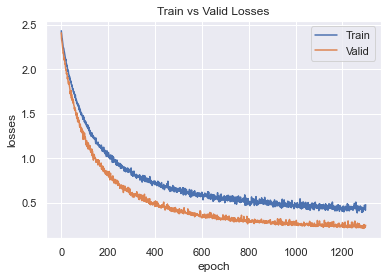

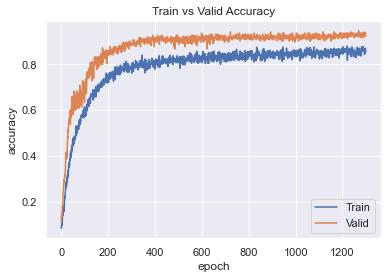

In [79]:
# load ===================================================================
model_comb = LinearModel_1(input_size,num_classes).to(device)

model_comb_dict = model_comb.state_dict()
fft_dict = torch.load('Model1_fft_Fold_2_allclass_twoinputs_net_parameter.pth')
raw_dict = torch.load('Model1_raw_Fold_2_allclass_twoinputs_net_parameter.pth')

fft_dict = {k: v for k, v in fft_dict.items() if k in model_comb_dict}
raw_dict = {k: v for k, v in raw_dict.items() if k in model_comb_dict}

model_comb_dict.update(fft_dict)
model_comb_dict.update(raw_dict)

model_comb.load_state_dict(model_comb_dict)

# freeze ===================================================================
count = 0
for child in model_comb.children():
    count += 1
    if count<3 :
        for param in child.parameters():
            param.requires_grad = False

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_comb.parameters()), lr=learning_rate)

# train ===================================================================
test_losses = []
test_acc = []

for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(n_train))):
    print('Fold {}'.format(fold+1))
    train_losses = []
    eval_losses = []
    train_acc = []
    eval_acc = []
    
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = dataloader.DataLoader(train_data, batch_size = batch_size, sampler=train_sampler)
    val_loader = dataloader.DataLoader(train_data, batch_size = batch_size, sampler=val_sampler)
    
    # reset the model
    model_comb.apply(reset_weights)
    min_loss= 100 # ramdom big number
    
    for epoch in range(num_epochs):
    
        print('In epoch {}/{}'.format(epoch+1,num_epochs))
        train(model_comb,device,train_loader,optimizer)
        val_loss = validation(model_comb,device,val_loader)
        # test(model_comb,device,test_loader)
        
        if(val_loss<min_loss):
            min_loss = val_loss
            print(f'================================save model_{fold+1}================================')
            torch.save(model_comb.state_dict(), f'Model1_comb_Fold_{fold+1}_allclass_twoinputs_net_parameter.pth')
    
    # plot training & testing loss ======================================================
    plt.plot(train_losses)
    plt.plot(eval_losses)
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid Losses')
    plt.show()

    # plot training & testing accuracy ======================================================
    plt.plot(train_acc)
    plt.plot(eval_acc)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid Accuracy')
    plt.savefig("Accuracy_All-class.png")
    plt.show()   

### pick the best final model

[test  metrics] loss:0.3924 accuracy:0.8933 recall:0.8946 precision:0.9016 f1:0.8967
*****************************************************************************************
              precision    recall  f1-score   support

         0.0       0.54      0.95      0.69        20
         1.0       0.76      0.59      0.67        22
         2.0       0.90      0.72      0.80        25
         3.0       0.88      0.88      0.88        24
         4.0       1.00      1.00      1.00        11
         5.0       0.94      0.89      0.92        19
         6.0       0.93      1.00      0.96        26
         7.0       1.00      0.82      0.90        22
         8.0       0.88      0.94      0.91        32
         9.0       0.93      0.86      0.89        29
        10.0       0.90      0.83      0.86        23

    accuracy                           0.86       253
   macro avg       0.88      0.86      0.86       253
weighted avg       0.88      0.86      0.86       253

显示百分比：
[[ 0.

<ipython-input-11-75ecb7cc6426>:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = softmax(output)
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


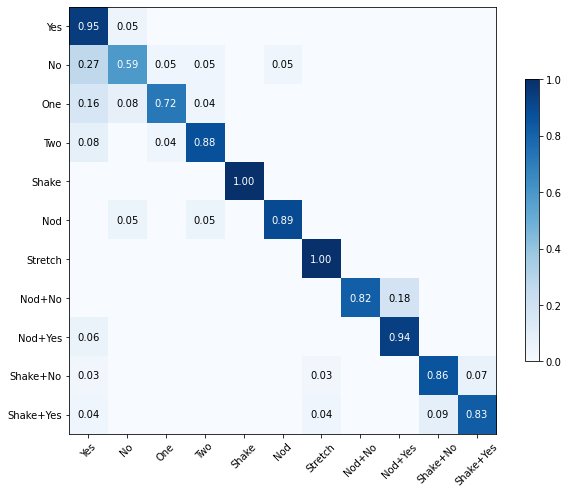

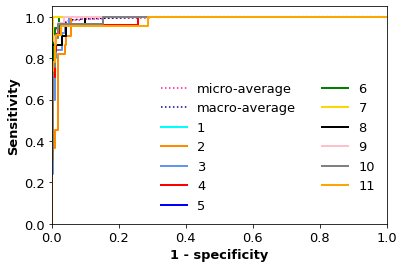

In [13]:
model_comb_final = LinearModel_1(input_size,num_classes).to(device)
state_dict = torch.load('Model1_comb_Fold_4_allclass_twoinputs_net_parameter.pth')
model_comb_final.load_state_dict(state_dict)

test(model_comb_final,device,test_loader)
test_metrics(model_comb_final,device,test_loader)

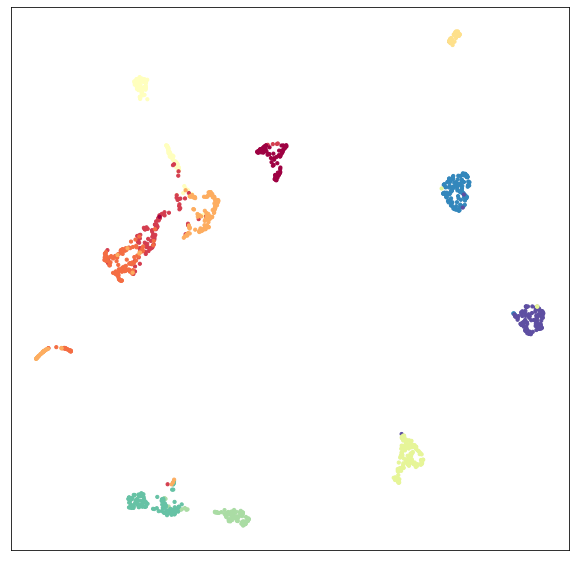

In [17]:
# UMAP visualization
model_comb_final.visu.register_forward_hook(get_activation('visu'))
second_layer_output = visualization(model_comb_final,device,all_loader)

mapper = umap.UMAP(random_state=42).fit_transform(second_layer_output.squeeze().cpu())

plt.figure(figsize=(10,10))
plt.scatter(mapper[:,0],mapper[:,1],c=all_data.label.squeeze(),s=10,cmap='Spectral')
plt.xticks([])
plt.yticks([])
#plt.axis('off')
plt.savefig("UMAP_All-class.png", transparent=True)
plt.show()

In [ ]:
# tensorboard --logdir="D:\Xin Zhang\Sensor\conbination\combination_log"